# **Amazing International Airlines Inc. (AIAI)**

## **Context**

Amazing International Airlines Inc. (AIAI) is a global airline seeking to enhance its customer loyalty program through **data-driven personalization**.  
In an increasingly competitive aviation market, AIAI aims to leverage **advanced segmentation analytics** to design tailored services and marketing strategies for its diverse customer base.

Your task is to analyze **three years of loyalty and flight activity data** to uncover meaningful customer segments that can guide business decisions and strategic initiatives.  

The segmentation should integrate multiple analytical perspectives, including:

- **Value-based segmentation** — grouping customers by their economic contribution and loyalty value.  
- **Behavioral segmentation** — analyzing flight frequency, point redemption habits, and travel companions.  
- **Demographic segmentation** — considering personal attributes such as gender, income, education, and location to reveal distinctive travel profiles.  

Ultimately, the objective is to **combine these perspectives into a unified segmentation framework**, supporting AIAI in creating differentiated experiences and maximizing long-term customer value.


## **Expected Outcomes**

In this notebook, we will perform a comprehensive **Exploratory Data Analysis (EDA)** aligned with the CRISP-DM methodology, focusing on:

- Descriptive statistics and visualization of key variables.  
- Identification of data quality issues and potential biases.  
- Detection of trends, patterns, and anomalies across customer behaviors.  
- Development of engineered features that may enhance future clustering performance.  
- Clear communication of insights to support strategic decision-making.

## **Data Definition**



### Dataset 1: `DM_AIAI_CustomerDB.csv`

| **Variable** | **Description** |
|---------------|-----------------|
| Loyalty# | Unique customer identifier for loyalty program members |
| First Name | Customer’s first name |
| Last Name | Customer’s last name |
| Customer Name | Customer’s full name (concatenated) |
| Country | Customer’s country of residence |
| Province or State | Customer’s province or state |
| City | Customer’s city of residence |
| Latitude | Geographic latitude coordinate of customer location |
| Longitude | Geographic longitude coordinate of customer location |
| Postal code | Customer’s postal/ZIP code |
| Gender | Customer’s gender |
| Education | Customer’s highest education level |
| Location Code | Urban/Suburban/Rural classification of customer residence |
| Income | Customer’s annual income |
| Marital Status | Customer’s marital status |
| LoyaltyStatus | Current tier status in loyalty program (Star > Nova > Aurora) |
| EnrollmentDateOpening | Date when customer joined the loyalty program |
| CancellationDate | Date when customer left the program |
| Customer Lifetime Value | Total calculated monetary value of customer relationship |
| EnrollmentType | Method of joining loyalty program |

### Dataset 2: `DM_AIAI_FlightsDB.csv`

| **Variable** | **Description** |
|---------------|-----------------|
| Loyalty# | Unique customer identifier linking to CustomerDB |
| Year | Year of flight activity record |
| Month | Month of flight activity record (1–12) |
| YearMonthDate | First day of the month for the activity period |
| NumFlights | Total number of flights taken by customer in the month |
| NumFlightsWithCompanions | Number of flights where customer traveled with companions |
| DistanceKM | Total distance traveled in kilometers for the month |
| PointsAccumulated | Loyalty points earned by customer during the month |
| PointsRedeemed | Loyalty points spent/redeemed by customer during the month |
| DollarCostPointsRedeemed | Dollar value of points redeemed during the month |





### **Methodological Note**

This segmentation initiative originates from a **pedagogical impetus embedded in data-centric inquiry**, aligning technical exploration with **business-oriented insight generation**.  
All analyses are conducted under the **CRISP-DM framework**, progressing from Business Understanding and Data Understanding toward Modeling and Evaluation.

---

This section imports the essential Python libraries and defines reusable functions that will support the exploratory data analysis (EDA) process for the **Amazing International Airlines Inc. (AIAI)** segmentation project.  
All functions are designed for clarity, reproducibility, and consistency across the analysis workflow.

# **Libraries and Functions**

# Import Packages and read files

In [1]:
#%load_ext nb_black

# Library to suppress warnings or deprecation notes
!pip install scikit-learn
!pip install geopy
!pip install folium
!pip install pdfkit


import warnings

warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data

import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from sklearn.manifold import TSNE

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import math
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
import datetime
from sklearn.impute import KNNImputer 
import plotly.express as px
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy import stats
import matplotlib.cm as cm
from sklearn import metrics
from sklearn.metrics import make_scorer, silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram
from sklearn.model_selection import GridSearchCV

## **Functions**

### Files to be loaded:
- `DM_AIAI_CustomerDB.csv` — customer-level information from the loyalty program  
- `DM_AIAI_FlightsDB.csv` — monthly flight activity data linked via the `Loyalty#` key  

### Objective:
Load both datasets from the local working directory into pandas DataFrames for subsequent cleaning, exploration, and feature engineering.


In [2]:
FlightsDB = pd.read_csv('data/DM_AIAI_FlightsDB.csv', sep = ',')
CustomerDB = pd.read_csv('data/DM_AIAI_CustomerDB.csv', sep = ',')

# Initial Expectation

In [3]:
CustomerDB.head()

Unnamed: 0  Loyalty# First Name    Last Name        Customer Name Country  \
0           0    480934    Cecilia  Householder  Cecilia Householder  Canada   
1           1    549612      Dayle        Menez          Dayle Menez  Canada   
2           2    429460     Necole       Hannon        Necole Hannon  Canada   
3           3    608370      Queen        Hagee          Queen Hagee  Canada   
4           4    530508     Claire      Latting       Claire Latting  Canada   

  Province or State       City   Latitude   Longitude  ...  Gender Education  \
0           Ontario    Toronto  43.653225  -79.383186  ...  female  Bachelor   
1           Alberta   Edmonton  53.544388 -113.490930  ...    male   College   
2  British Columbia  Vancouver  49.282730 -123.120740  ...    male   College   
3           Ontario    Toronto  43.653225  -79.383186  ...    male   College   
4            Quebec       Hull  45.428730  -75.713364  ...    male  Bachelor   

  Location Code   Income  Marital Status LoyaltyStatus EnrollmentDateOpening  \
0         Urban  70146.0         Married          Star             2/15/2019   
1         Rural      0.0        Divorced          Star              3/9/2019   
2         Urban      0.0          Single          Star             7/14/2017   
3      Suburban      0.0          Single          Star             2/17/2016   
4      Suburban  97832.0         Married          Star            10/25/2017   

  CancellationDate Customer Lifetime Value  EnrollmentType  
0              NaN                 3839.14        Standard  
1              NaN                 3839.61        Standard  
2         1/8/2021                 3839.75        Standard  
3              NaN                 3839.75        Standard  
4              NaN                 3842.79  2021 Promotion  

[5 rows x 21 columns]

In [4]:
FlightsDB.head()

Loyalty#  Year  Month YearMonthDate  NumFlights  NumFlightsWithCompanions  \
0    413052  2021     12     12/1/2021         2.0                       2.0   
1    464105  2021     12     12/1/2021         0.0                       0.0   
2    681785  2021     12     12/1/2021        10.0                       3.0   
3    185013  2021     12     12/1/2021        16.0                       4.0   
4    216596  2021     12     12/1/2021         9.0                       0.0   

   DistanceKM  PointsAccumulated  PointsRedeemed  DollarCostPointsRedeemed  
0      9384.0              938.0             0.0                       0.0  
1         0.0                0.0             0.0                       0.0  
2     14745.0             1474.0             0.0                       0.0  
3     26311.0             2631.0          3213.0                      32.0  
4     19275.0             1927.0             0.0                       0.0

In [5]:
CustomerDB = CustomerDB.copy()
CustomerDB = CustomerDB.drop(columns=['Unnamed: 0'])
CustomerDB.tail()

Loyalty# First Name Last Name    Customer Name Country  \
16916    100012      Ethan  Thompson   Ethan Thompson  Canada   
16917    100013      Layla     Young      Layla Young  Canada   
16918    100014     Amelia   Bennett   Amelia Bennett  Canada   
16919    100015   Benjamin    Wilson  Benjamin Wilson  Canada   
16920    100016       Emma    Martin      Emma Martin  Canada   

      Province or State          City   Latitude   Longitude Postal code  \
16916            Quebec   Quebec City  46.759733  -71.141009     Y0C 7D6   
16917           Alberta      Edmonton  53.524829 -113.546357     L3S 9Y3   
16918     New Brunswick       Moncton  46.051866  -64.825428     G2S 2B6   
16919            Quebec   Quebec City  46.862970  -71.133444     B1Z 8T3   
16920  British Columbia  Dawson Creek  55.720562 -120.160090     M4A 1E4   

       Gender Education Location Code  Income Marital Status LoyaltyStatus  \
16916    male  Bachelor      Suburban     NaN         Single          Star   
16917  female  Bachelor         Rural     NaN        Married          Star   
16918    male  Bachelor         Rural     NaN        Married          Star   
16919  female   College         Urban     NaN        Married          Star   
16920  female    Master      Suburban     NaN         Single          Star   

      EnrollmentDateOpening CancellationDate  Customer Lifetime Value  \
16916             2/27/2019        2/27/2019                      NaN   
16917             9/20/2017        9/20/2017                      NaN   
16918            11/28/2020       11/28/2020                      NaN   
16919              4/9/2020         4/9/2020                      NaN   
16920             7/21/2020        7/21/2020                      NaN   

      EnrollmentType  
16916       Standard  
16917       Standard  
16918       Standard  
16919       Standard  
16920       Standard

In [6]:
FlightsDB.tail()

Loyalty#  Year  Month YearMonthDate  NumFlights  \
608431    999902  2019     12     12/1/2019         7.2   
608432    999911  2019     12     12/1/2019         0.0   
608433    999940  2019     12     12/1/2019        14.4   
608434    999982  2019     12     12/1/2019         0.0   
608435    999986  2019     12     12/1/2019         0.0   

        NumFlightsWithCompanions  DistanceKM  PointsAccumulated  \
608431                       0.0     30766.5            3076.65   
608432                       0.0         0.0               0.00   
608433                       0.9     18261.0            1826.10   
608434                       0.0         0.0               0.00   
608435                       0.0         0.0               0.00   

        PointsRedeemed  DollarCostPointsRedeemed  
608431             0.0                       0.0  
608432             0.0                       0.0  
608433             0.0                       0.0  
608434             0.0                       0.0  
608435             0.0                       0.0

In [7]:
print(CustomerDB.columns)

print(f"Customer dataset: {CustomerDB.shape[0]} rows × {CustomerDB.shape[1]} columns")


Index(['Loyalty#', 'First Name', 'Last Name', 'Customer Name', 'Country',
       'Province or State', 'City', 'Latitude', 'Longitude', 'Postal code',
       'Gender', 'Education', 'Location Code', 'Income', 'Marital Status',
       'LoyaltyStatus', 'EnrollmentDateOpening', 'CancellationDate',
       'Customer Lifetime Value', 'EnrollmentType'],
      dtype='object')
Customer dataset: 16921 rows × 20 columns


In [8]:
print(FlightsDB.columns)

print(f"Flights dataset:  {FlightsDB.shape[0]} rows × {FlightsDB.shape[1]} columns")


Index(['Loyalty#', 'Year', 'Month', 'YearMonthDate', 'NumFlights',
       'NumFlightsWithCompanions', 'DistanceKM', 'PointsAccumulated',
       'PointsRedeemed', 'DollarCostPointsRedeemed'],
      dtype='object')
Flights dataset:  608436 rows × 10 columns


# **Exploratory Data Analysis**

This section focuses on the **Data Understanding** phase of the CRISP-DM framework.  
We explore the structure, completeness, and consistency of both datasets — `CustomerDB` and `FlightsDB` — to assess their readiness for clustering and feature engineering.


## Dataframe structure and datatypes

In this section, we inspect the structure and data types of the two AIAI datasets:  
- `CustomerDB`: loyalty program and demographic information.  
- `FlightsDB`: monthly flight activity data.

This step helps us confirm that the data was imported correctly, identify column types, and detect potential inconsistencies (e.g., numeric fields stored as objects).

In [9]:
print("=== Customer Dataset Info ===")
CustomerDB.info()

=== Customer Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16921 entries, 0 to 16920
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Loyalty#                 16921 non-null  int64  
 1   First Name               16921 non-null  object 
 2   Last Name                16921 non-null  object 
 3   Customer Name            16921 non-null  object 
 4   Country                  16921 non-null  object 
 5   Province or State        16921 non-null  object 
 6   City                     16921 non-null  object 
 7   Latitude                 16921 non-null  float64
 8   Longitude                16921 non-null  float64
 9   Postal code              16921 non-null  object 
 10  Gender                   16921 non-null  object 
 11  Education                16921 non-null  object 
 12  Location Code            16921 non-null  object 
 13  Income                   16901 non-null  float

From the dataset, we can conclude the following:
- **'Income'** and **'Customer Lifetime Value'** have exactly the same missing values, suggesting that these two variables are likely related.
- **CancellationDate** has a large number of missing values, indicating that the majority of customers are likely still active.
- **EnrollmentDateOpening** and **CancellationDate** should be convert to DateTime

In [10]:
print("\n=== Flights Dataset Info ===")
FlightsDB.info()


=== Flights Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608436 entries, 0 to 608435
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Loyalty#                  608436 non-null  int64  
 1   Year                      608436 non-null  int64  
 2   Month                     608436 non-null  int64  
 3   YearMonthDate             608436 non-null  object 
 4   NumFlights                608436 non-null  float64
 5   NumFlightsWithCompanions  608436 non-null  float64
 6   DistanceKM                608436 non-null  float64
 7   PointsAccumulated         608436 non-null  float64
 8   PointsRedeemed            608436 non-null  float64
 9   DollarCostPointsRedeemed  608436 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 46.4+ MB


From the dataset, we can conclude the following:

- No missing values 

- **YearMonthDate** should be converted to datetime

- **NumFlights**, **NumFlightsWithCompanions**, **PointsAccumulated** and **PointsRedeemed** should be converted to integer

In [11]:
CustomerDB.dtypes

Loyalty#                     int64
First Name                  object
Last Name                   object
Customer Name               object
Country                     object
Province or State           object
City                        object
Latitude                   float64
Longitude                  float64
Postal code                 object
Gender                      object
Education                   object
Location Code               object
Income                     float64
Marital Status              object
LoyaltyStatus               object
EnrollmentDateOpening       object
CancellationDate            object
Customer Lifetime Value    float64
EnrollmentType              object
dtype: object

The types of the following features in CustomerDB should be:
- **'EnrollmentDateOpening'**: datetime64
- **'CancellationDate'**: datetime64

This will be addressed in the Data Types section to ensure proper handling for filtering, comparison, and time-based analysis.


In [12]:
FlightsDB.dtypes

Loyalty#                      int64
Year                          int64
Month                         int64
YearMonthDate                object
NumFlights                  float64
NumFlightsWithCompanions    float64
DistanceKM                  float64
PointsAccumulated           float64
PointsRedeemed              float64
DollarCostPointsRedeemed    float64
dtype: object

The types of the following features in FlightsDB should be:
- **'NumFlights'**: int64
- **'NumFlightswithCompanions'**: int64
- **'PointsAccumulated'**: int64
- **'PointsRedeemed'**: int64

In [13]:
CustomerDB.nunique()

Loyalty#                   16757
First Name                  4941
Last Name                  15404
Customer Name              16921
Country                        1
Province or State             11
City                          29
Latitude                      49
Longitude                     49
Postal code                   75
Gender                         2
Education                      5
Location Code                  3
Income                      5694
Marital Status                 3
LoyaltyStatus                  3
EnrollmentDateOpening       2449
CancellationDate            1260
Customer Lifetime Value     7996
EnrollmentType                 2
dtype: int64

The feature **Country** contains only a single unique value, meaning it provides no meaningful information for analysis. Therefore, it is recommended to drop this feature.

The features **EnrollmentType** and **Gender** each have only two unique categories. Since they are binary, we can transform them into boolean variables for easier analysis and modeling.

In [14]:
FlightsDB.nunique()

Loyalty#                    16737
Year                            3
Month                          12
YearMonthDate                  36
NumFlights                     41
NumFlightsWithCompanions       22
DistanceKM                  66762
PointsAccumulated           37064
PointsRedeemed               8146
DollarCostPointsRedeemed      104
dtype: int64

# Descriptive Statistics

## CustomerDB

In [15]:
CustomerDB.describe(include='all').T

count unique          top   freq           mean  \
Loyalty#                 16921.0    NaN          NaN    NaN  550197.393771   
First Name                 16921   4941         Deon     13            NaN   
Last Name                  16921  15404      Salberg      4            NaN   
Customer Name              16921  16921  Emma Martin      1            NaN   
Country                    16921      1       Canada  16921            NaN   
Province or State          16921     11      Ontario   5468            NaN   
City                       16921     29      Toronto   3390            NaN   
Latitude                 16921.0    NaN          NaN    NaN        47.1745   
Longitude                16921.0    NaN          NaN    NaN     -91.814768   
Postal code                16921     75      V6E 3D9    917            NaN   
Gender                     16921      2       female   8497            NaN   
Education                  16921      5     Bachelor  10586            NaN   
Location Code              16921      3     Suburban   5716            NaN   
Income                   16901.0    NaN          NaN    NaN     37758.0384   
Marital Status             16921      3      Married   9842            NaN   
LoyaltyStatus              16921      3         Star   7761            NaN   
EnrollmentDateOpening      16921   2449     4/3/2015     34            NaN   
CancellationDate            2310   1260     7/7/2020      8            NaN   
Customer Lifetime Value  16901.0    NaN          NaN    NaN    7990.460188   
EnrollmentType             16921      2     Standard  15773            NaN   

                                   std        min        25%        50%  \
Loyalty#                 259251.503597   100011.0   326823.0   550896.0   
First Name                         NaN        NaN        NaN        NaN   
Last Name                          NaN        NaN        NaN        NaN   
Customer Name                      NaN        NaN        NaN        NaN   
Country                            NaN        NaN        NaN        NaN   
Province or State                  NaN        NaN        NaN        NaN   
City                               NaN        NaN        NaN        NaN   
Latitude                      3.307971  42.984924  44.231171  46.087818   
Longitude                    22.242429 -135.05684 -120.23766 -79.383186   
Postal code                        NaN        NaN        NaN        NaN   
Gender                             NaN        NaN        NaN        NaN   
Education                          NaN        NaN        NaN        NaN   
Location Code                      NaN        NaN        NaN        NaN   
Income                    30368.992499        0.0        0.0    34161.0   
Marital Status                     NaN        NaN        NaN        NaN   
LoyaltyStatus                      NaN        NaN        NaN        NaN   
EnrollmentDateOpening              NaN        NaN        NaN        NaN   
CancellationDate                   NaN        NaN        NaN        NaN   
Customer Lifetime Value    6863.173093    1898.01    3979.72    5780.18   
EnrollmentType                     NaN        NaN        NaN        NaN   

                               75%        max  
Loyalty#                  772438.0   999999.0  
First Name                     NaN        NaN  
Last Name                      NaN        NaN  
Customer Name                  NaN        NaN  
Country                        NaN        NaN  
Province or State              NaN        NaN  
City                           NaN        NaN  
Latitude                  49.28273  60.721188  
Longitude               -74.596184 -52.712578  
Postal code                    NaN        NaN  
Gender                         NaN        NaN  
Education                      NaN        NaN  
Location Code                  NaN        NaN  
Income                     62396.0    99981.0  
Marital Status                 NaN        NaN  
LoyaltyStatus                  NaN        Na

All customers are located in Canada; the most common province is Ontario and the most common city is Toronto. The Province or State we could encode as one-hot for modeling.

The **"Income"** field has a mean of about 37,758, with a wide range (0 to 99,981), so it means that each customer, in average receives a income of 37k per year.

**Customer Lifetime Value** also shows significant variability, highlighting a broad spectrum of customer worth.

**Loyalty Status** has three categories, with "Star" being the most common.

Most accounts were opened with the "Standard" enrollment type. We see that we clearly don't have a fairly balanced category, so we may drop it. Let's see if this category has a significant relationship with the other features.

There are many more enrollments than cancellations, suggesting most customers remain active.

**First Name**, **Last Name** and **Customer Name** does not seems to have significant relevance, so we will drop them.

Encode **Province**, **City**, **Education**, **LoyaltyStatus** with one-hot or ordinal encoding.


## FlightsDB

In [16]:
FlightsDB.describe().T

count           mean            std       min  \
Loyalty#                  608436.0  550037.873084  258935.180575  100018.0   
Year                      608436.0    2020.000000       0.816497    2019.0   
Month                     608436.0       6.500000       3.452055       1.0   
NumFlights                608436.0       3.908107       5.057889       0.0   
NumFlightsWithCompanions  608436.0       0.983944       2.003785       0.0   
DistanceKM                608436.0    7939.341419   10260.421873       0.0   
PointsAccumulated         608436.0     793.777781    1025.918521       0.0   
PointsRedeemed            608436.0     235.251678     983.233374       0.0   
DollarCostPointsRedeemed  608436.0       2.324835       9.725168       0.0   

                                25%         50%          75%       max  
Loyalty#                  326961.00  550834.000  772194.0000  999986.0  
Year                        2019.00    2020.000    2021.0000    2021.0  
Month                          3.75       6.500       9.2500      12.0  
NumFlights                     0.00       0.000       7.2000      21.0  
NumFlightsWithCompanions       0.00       0.000       0.9000      11.0  
DistanceKM                     0.00     856.400   15338.1750   42040.0  
PointsAccumulated              0.00      85.275    1533.7125    4204.0  
PointsRedeemed                 0.00       0.000       0.0000    7496.0  
DollarCostPointsRedeemed       0.00       0.000       0.0000      74.0

In [17]:
FlightsDB = FlightsDB.copy()

agg_by_customer = FlightsDB.groupby('Loyalty#')[['NumFlights', 'NumFlightsWithCompanions',
                                                 'DistanceKM', 'PointsAccumulated', 'PointsRedeemed', 'DollarCostPointsRedeemed']].mean().reset_index()
agg_by_customer.describe().T

count           mean            std       min  \
Loyalty#                  16737.0  549735.880445  258912.132453  100018.0   
NumFlights                16737.0       3.917364       2.240442       0.0   
NumFlightsWithCompanions  16737.0       0.986079       0.650682       0.0   
DistanceKM                16737.0    7956.482846    4546.290236       0.0   
PointsAccumulated         16737.0     795.491577     454.552857       0.0   
PointsRedeemed            16737.0     235.857617     241.082095       0.0   
DollarCostPointsRedeemed  16737.0       2.330821       2.384114       0.0   

                                    25%            50%            75%  \
Loyalty#                  326603.000000  550434.000000  772019.000000   
NumFlights                     1.944444       4.516667       5.636111   
NumFlightsWithCompanions       0.436111       1.019444       1.461111   
DistanceKM                  3970.388889    9196.005556   11469.319444   
PointsAccumulated            396.944444     919.370000    1146.718056   
PointsRedeemed                 0.000000     179.972222     375.386111   
DollarCostPointsRedeemed       0.000000       1.777778       3.705556   

                                    max  
Loyalty#                  999986.000000  
NumFlights                     9.677778  
NumFlightsWithCompanions       3.444444  
DistanceKM                 19798.044444  
PointsAccumulated           1979.568333  
PointsRedeemed              1597.994444  
DollarCostPointsRedeemed      15.888889

# Missing Values

## CustomerDB

In [18]:
CustomerDB.isna().sum()

Loyalty#                       0
First Name                     0
Last Name                      0
Customer Name                  0
Country                        0
Province or State              0
City                           0
Latitude                       0
Longitude                      0
Postal code                    0
Gender                         0
Education                      0
Location Code                  0
Income                        20
Marital Status                 0
LoyaltyStatus                  0
EnrollmentDateOpening          0
CancellationDate           14611
Customer Lifetime Value       20
EnrollmentType                 0
dtype: int64

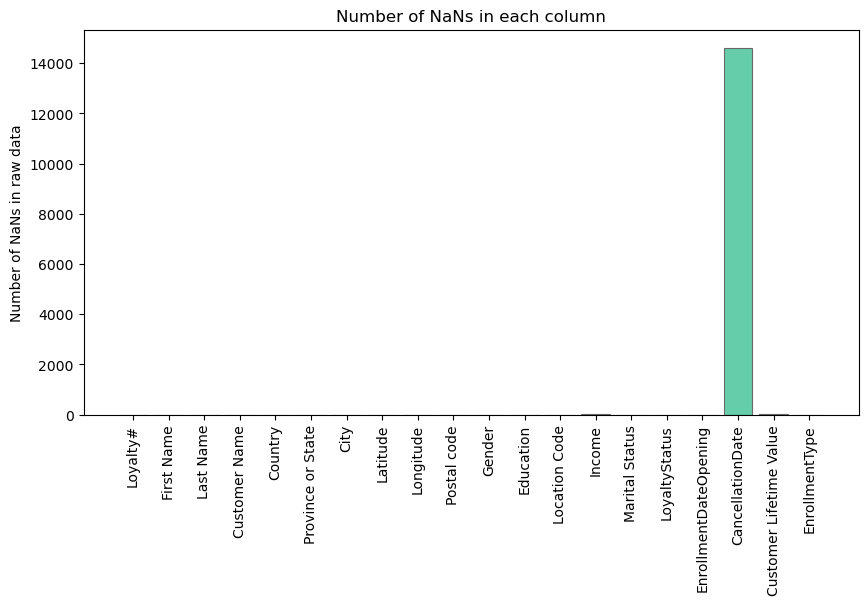

In [19]:
CustomerDB = CustomerDB.copy()
number_of_nans = CustomerDB.isnull().sum()
x_xis = number_of_nans.index.tolist()
plt.figure(figsize=(10, 5))
plt.xticks(rotation=90)
plt.ylabel('Number of NaNs in raw data')
plt.title('Number of NaNs in each column')
plt.bar(x=x_xis, height=number_of_nans, color='mediumaquamarine', edgecolor='dimgray', linewidth=0.8)

plt.show()

In [20]:
# Total rows
total_rows = CustomerDB.shape[0]

# Count of NaNs per column
nan_count = CustomerDB.isna().sum()

# Percentage of NaNs per column
nan_percentage = (nan_count / total_rows) * 100

# Display
nan_percentage


Loyalty#                    0.000000
First Name                  0.000000
Last Name                   0.000000
Customer Name               0.000000
Country                     0.000000
Province or State           0.000000
City                        0.000000
Latitude                    0.000000
Longitude                   0.000000
Postal code                 0.000000
Gender                      0.000000
Education                   0.000000
Location Code               0.000000
Income                      0.118196
Marital Status              0.000000
LoyaltyStatus               0.000000
EnrollmentDateOpening       0.000000
CancellationDate           86.348325
Customer Lifetime Value     0.118196
EnrollmentType              0.000000
dtype: float64

The variable CancellationDate contains approximately 86% missing values. This is expected, as missing entries correspond to active loyalty members who have not left the program. Only around 14% of customers show a valid cancellation date, indicating a relatively low churn rate across all loyalty tiers (Aurora, Nova, Star).

In [21]:
FlightsDB.isnull().sum()

Loyalty#                    0
Year                        0
Month                       0
YearMonthDate               0
NumFlights                  0
NumFlightsWithCompanions    0
DistanceKM                  0
PointsAccumulated           0
PointsRedeemed              0
DollarCostPointsRedeemed    0
dtype: int64

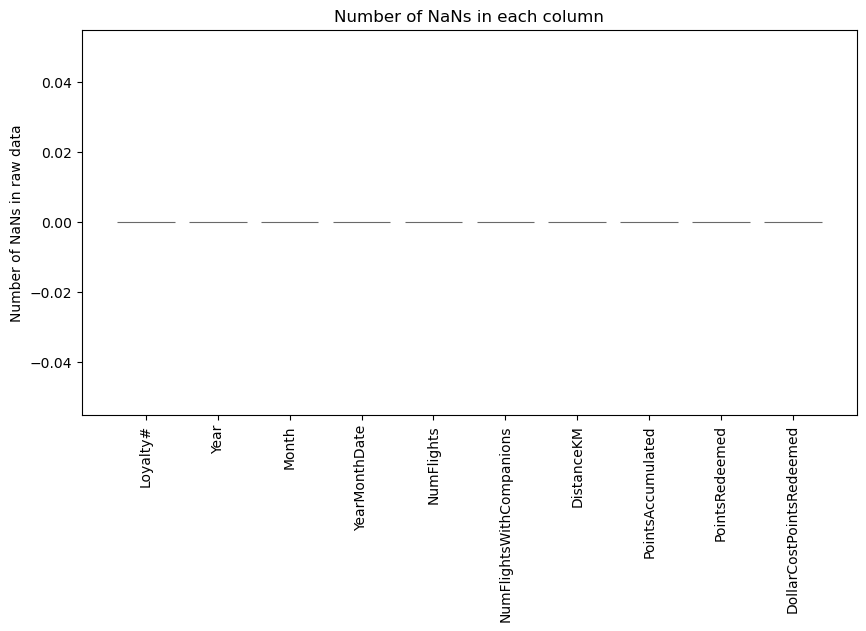

In [22]:
FlightsDB = FlightsDB.copy()

number_of_nans = FlightsDB.isnull().sum()
x_xis = number_of_nans.index.tolist()
plt.figure(figsize=(10, 5))
plt.xticks(rotation=90)
plt.ylabel('Number of NaNs in raw data')
plt.title('Number of NaNs in each column')
plt.bar(x=x_xis, height=number_of_nans, color='mediumaquamarine', edgecolor='dimgray', linewidth=0.8)

plt.show()

### Missing Values in CustomerDB

#### Cancellation Date



In [23]:
CustomerDB['CancellationDate'] = CustomerDB['CancellationDate'].fillna('Active')

**Discutir o que fazer com este missing value, se usamos active ou se criamos nova feature**

#### Income

In [24]:
# Filter rows where Income is missing
income_nan_df = CustomerDB[CustomerDB['Income'].isna()]

# Show how many customers have missing income
print(f"Total customers with missing Income: {income_nan_df.shape[0]}")

income_nan_df.head(20)

Total customers with missing Income: 20


Loyalty# First Name Last Name    Customer Name Country  \
16901    999987      Layla    Murphy     Layla Murphy  Canada   
16902    999988       Jana    Parker      Jana Parker  Canada   
16903    999989      Ethan    Parker     Ethan Parker  Canada   
16904    999990       Ryan  Anderson    Ryan Anderson  Canada   
16905    999991     Olivia      Cote      Olivia Cote  Canada   
16906    999992       Ella       Roy         Ella Roy  Canada   
16907    999993     Elijah      Cook      Elijah Cook  Canada   
16908    999994      Ethan      Chan       Ethan Chan  Canada   
16909    999995       Liam      Wong        Liam Wong  Canada   
16910    999996   Isabella      Ross    Isabella Ross  Canada   
16911    999997      Grace    Miller     Grace Miller  Canada   
16912    999998       Noah  Thompson    Noah Thompson  Canada   
16913    999999       Noah    Walker      Noah Walker  Canada   
16914    100017      Grace    Fortin     Grace Fortin  Canada   
16915    100011     Amelia      Ross      Amelia Ross  Canada   
16916    100012      Ethan  Thompson   Ethan Thompson  Canada   
16917    100013      Layla     Young      Layla Young  Canada   
16918    100014     Amelia   Bennett   Amelia Bennett  Canada   
16919    100015   Benjamin    Wilson  Benjamin Wilson  Canada   
16920    100016       Emma    Martin      Emma Martin  Canada   

      Province or State          City   Latitude   Longitude Postal code  \
16901     New Brunswick   Fredericton  46.029263  -66.565150     R4H 2Y2   
16902            Quebec      Montreal  45.573672  -73.523012     N6B 1N3   
16903           Ontario       Trenton  44.075379  -77.550375     P8F 5C8   
16904     New Brunswick       Moncton  46.106617  -64.714267     B6P 6D0   
16905     New Brunswick   Fredericton  45.950000  -66.652437     X3W 5N2   
16906           Ontario       Toronto  43.706878  -79.437412     P6D 6N2   
16907  British Columbia  Dawson Creek  55.701475 -120.181716     W6H 0Z7   
16908           Ontario        Ottawa  45.365906  -75.723181     B2F 3E1   
16909           Ontario        Ottawa  45.471557  -75.704868     B3A 2R0   
16910           Ontario       Toronto  43.690489  -79.436758     B4W 4M6   
16911     New Brunswick       Moncton  46.067243  -64.729480     S5R 0X5   
16912            Quebec   Quebec City  46.749897  -71.238050     K7T 9I9   
16913           Alberta      Edmonton  53.549353 -113.509109     S7D 0V1   
16914  British Columbia  Dawson Creek  55.751178 -120.264920     E0K 5I2   
16915           Ontario       Toronto  43.593187  -79.444335     W9D 4Q9   
16916            Quebec   Quebec City  46.759733  -71.141009     Y0C 7D6   
16917           Alberta      Edmonton  53.524829 -113.546357     L3S 9Y3   
16918     New Brunswick       Moncton  46.051866  -64.825428     G2S 2B6   
16919            Quebec   Quebec City  46.862970  -71.133444     B1Z 8T3   
16920  British Columbia  Dawson Creek  55.720562 -120.160090     M4A 1E4   

       Gender Education Location Code  Income Marital Status LoyaltyStatus  \
16901  female  Bachelor         Urban     NaN         Single          Star   
16902    male   College         Rural     NaN         Single          Star   
16903    male   College         Rural     NaN        Married          Star   
16904  female   College         Rural     NaN        Married          Star   
16905  female   College      Suburban     NaN        Married          Star   
16906    male   College      Suburban     NaN         Single          Star   
16907  female   College      Suburban     NaN        Married          Star   
16908  female   College         Rural     NaN        Married          Star   
16909  female   College      Suburban     NaN        Married          Star   
16910  female  Bachelor      Suburban     NaN         Single          Star   
16911    male   College         Urban     NaN        Married          Star   
16912    male  Bachelor         Urban     NaN         Single          Star   
16913    male  Bachelor       

In [25]:
CustomerDB['Income'] = pd.to_numeric(CustomerDB['Income'], errors='coerce')

n_total = len(CustomerDB)
n_nan   = CustomerDB['Income'].isna().sum()
n_zero  = (CustomerDB['Income'] == 0).sum()

print(f"Total rows: {n_total}")
print(f"NaN Income: {n_nan}  ({n_nan/n_total:.2%})")
print(f"Zero Income: {n_zero}  ({n_zero/n_total:.2%})")

valid = n_total - n_nan
if valid > 0:
    print(f"Zero among valid (non-NaN): {n_zero}  ({n_zero/valid:.2%})")

ct_tier = pd.crosstab(CustomerDB['LoyaltyStatus'], CustomerDB['Income'].eq(0))
ct_tier.columns = ['Income!=0', 'Income==0']
display(ct_tier)
display((ct_tier.div(ct_tier.sum(axis=1), axis=0) * 100).round(2))  # percentagens por tier

negatives = (CustomerDB['Income'] < 0).sum()
print(f"Negative incomes: {negatives}")


Total rows: 16921
NaN Income: 20  (0.12%)
Zero Income: 4273  (25.25%)
Zero among valid (non-NaN): 4273  (25.28%)


Income!=0  Income==0
LoyaltyStatus                      
Aurora              2643        795
Nova                4377       1345
Star                5628       2133

Income!=0  Income==0
LoyaltyStatus                      
Aurora             76.88      23.12
Nova               76.49      23.51
Star               72.52      27.48

Negative incomes: 0


All of the 20 customers with Income equals to nan have the same date for Cancellation and Enrollment, which suggers that the customer signed up and canceled on the same day.

The **Income** is missing, so the system likely never collected profile data for these customers because they did not complete or activate their account.

The same for **Customer Lifetime Value**, since the customers never activate their accounts, the CLV will be equal to missing value.

#### CLV

In [26]:
# Filter rows where CLV is missing
clv_missing_df = CustomerDB[CustomerDB['Customer Lifetime Value'].isna()]

# Count how many
total_clv_missing = clv_missing_df.shape[0]
print(f"Total customers with missing CLV: {total_clv_missing}")


Total customers with missing CLV: 20


Here we are comparing this 20 rows in FlightsDB

In [27]:
CustomerDB['Loyalty#'] = CustomerDB['Loyalty#'].astype(str).str.strip()
FlightsDB['Loyalty#']  = FlightsDB['Loyalty#'].astype(str).str.strip()

customers_na = CustomerDB[(CustomerDB['Income'].isna()) & (CustomerDB['Customer Lifetime Value'].isna())]

ids_na = customers_na['Loyalty#'].tolist()

flights_match = FlightsDB[FlightsDB['Loyalty#'].isin(ids_na)]

print(flights_match)

Empty DataFrame
Columns: [Loyalty#, Year, Month, YearMonthDate, NumFlights, NumFlightsWithCompanions, DistanceKM, PointsAccumulated, PointsRedeemed, DollarCostPointsRedeemed]
Index: []


In [28]:
# Replace NaN incomes and customer lifetime value with 0
CustomerDB = CustomerDB.copy()
CustomerDB['Income'] = CustomerDB['Income'].fillna(0)
CustomerDB['Customer Lifetime Value'] = CustomerDB['Customer Lifetime Value'].fillna(0)

#### What we analysed & why CLV=0 and Income=0 for those 20 cases

**What we checked**
- We normalized the join key `Loyalty#` and performed an **anti-join** to find customers who are present in the CustomerDB but have **no rows** in the FlightsDB.
- For those customers, we verified that there is **no flight activity** at all (no flights, distance, points accumulated or redeemed, nor dollar redemptions).

**Findings**
- We identified **Star-tier customers** who **enrolled and later cancelled** (based on `EnrollmentDateOpening` and `CancellationDate`) **without any recorded flight activity** during the observation window.
- Because CLV in this dataset is operationally tied to loyalty activity (points accumulated/redeemed and their dollar value), these customers have **no observable contribution** to CLV.

**Decision & rationale**
- We set `Customer Lifetime Value = 0` and `Income = 0` **only** for customers with **CLV missing** *and* **no flight activity**.
- This is a **transparent, conservative, and business-consistent** treatment: no activity → no realized (or observable) value.
- We deliberately avoided imputing a positive value (e.g., tier/country median) because that would fabricate value not supported by behavior, potentially biasing segmentation and KPIs.

**Notes**
- If a different business rule is preferred (e.g., imputing a peer median for reporting comparability), keep a flag and document it clearly as **imputed** rather than observed.
- All other customers retain their original Income and CLV values.


# Data Types
## CustomerDB
We should change the data types of the following features to datetime:

- **EnrollmentDateOpening**

- **CancellationDate**


Discuss if we change now or after

In [29]:
CustomerDB['EnrollmentDateOpening']= pd.to_datetime(CustomerDB['EnrollmentDateOpening'], errors='coerce')
CustomerDB['CancellationDate']= pd.to_datetime(CustomerDB['CancellationDate'], errors='coerce') 

## FlightsDB

We should change the data types of the following features:
- **NumFlights**: to int
- **NumFlightsWithCompanions**: to int
- **PointsAccumulated**: to int 
- **PointsRedeemed**: to int
- **YearMonthDatr**: to datetime

In [30]:
# List of columns to convert
int_columns = ['NumFlights', 'NumFlightsWithCompanions', 'PointsAccumulated', 'PointsRedeemed']

# Convert each column to integer, using 'Int64' for nullable integers
for col in int_columns:
    FlightsDB[col] = pd.to_numeric(FlightsDB[col], errors='coerce').astype('int64')

# Convert both columns to datetime
FlightsDB['YearMonthDate'] = pd.to_datetime(
    FlightsDB['YearMonthDate'], errors='coerce'
)


# Duplicated values in the Primary Key and in all Dataset
## CustomerDB


In [31]:
# Select all fully duplicate rows (all columns must match)
fully_duplicated_rows = CustomerDB[CustomerDB.duplicated(keep=False)]

# Display the fully duplicated rows
fully_duplicated_rows

Empty DataFrame
Columns: [Loyalty#, First Name, Last Name, Customer Name, Country, Province or State, City, Latitude, Longitude, Postal code, Gender, Education, Location Code, Income, Marital Status, LoyaltyStatus, EnrollmentDateOpening, CancellationDate, Customer Lifetime Value, EnrollmentType]
Index: []

In [32]:
# Select all columns except 'Loyalty#'
cols_except_loyalty = [c for c in CustomerDB.columns if c != 'Loyalty#']

# Find duplicated rows ignoring 'Loyalty#'
duplicates_ignore_loyalty = CustomerDB[CustomerDB.duplicated(subset=cols_except_loyalty, keep=False)]

# Optional: sort for easier inspection
duplicates_ignore_loyalty = duplicates_ignore_loyalty.sort_values(by=['First Name','Last Name','EnrollmentDateOpening'])

# Display
duplicates_ignore_loyalty


Empty DataFrame
Columns: [Loyalty#, First Name, Last Name, Customer Name, Country, Province or State, City, Latitude, Longitude, Postal code, Gender, Education, Location Code, Income, Marital Status, LoyaltyStatus, EnrollmentDateOpening, CancellationDate, Customer Lifetime Value, EnrollmentType]
Index: []

By the shape of the dataset, the primary key should be **Loyalty#**

In [33]:
primary_key = 'Loyalty#'
unique_values = CustomerDB[primary_key].unique().shape
n_rows = CustomerDB[primary_key].shape [0]
if unique_values != n_rows:
    print('oh no! there are repetitions!')
else:
    print("all good! no repetitions!")

oh no! there are repetitions!


In [34]:
# Select all rows with duplicated Loyalty#
duplicated_loyalty = CustomerDB[CustomerDB['Loyalty#'].duplicated(keep=False)]

# Sort by Loyalty# and EnrollmentDateOpening
duplicated_loyalty_sorted = duplicated_loyalty.sort_values(by=['Loyalty#', 'EnrollmentDateOpening'])

# Display the result
duplicated_loyalty_sorted

Loyalty# First Name    Last Name       Customer Name Country  \
1646    101902       Hans  Schlottmann    Hans Schlottmann  Canada   
2668    101902         Yi        Nesti            Yi Nesti  Canada   
15988   106001     Maudie       Hyland       Maudie Hyland  Canada   
700     106001     Ivette       Peifer       Ivette Peifer  Canada   
9413    106509    Ardelia   Whitehorse  Ardelia Whitehorse  Canada   
...        ...        ...          ...                 ...     ...   
5038    989528     Sharri     Boughman     Sharri Boughman  Canada   
9890    990512      Magda       Sopher        Magda Sopher  Canada   
14478   990512       Ione      Snowden        Ione Snowden  Canada   
6981    992168  Frederick       Samaha    Frederick Samaha  Canada   
16380   992168     Crysta       Bennin       Crysta Bennin  Canada   

      Province or State         City   Latitude   Longitude Postal code  \
1646            Ontario       London  42.984924  -81.245277     M5B 3E4   
2668            Ontario      Toronto  43.653225  -79.383186     M8Y 4K8   
15988     New Brunswick  Fredericton  45.963589  -66.643112     E3B 2H2   
700              Quebec     Montreal  45.501690  -73.567253     H2Y 4R4   
9413            Ontario      Toronto  43.653225  -79.383186     M8Y 4K8   
...                 ...          ...        ...         ...         ...   
5038             Quebec     Montreal  45.501690  -73.567253     H2T 2J6   
9890            Ontario      Toronto  43.653225  -79.383186     P1W 1K4   
14478  British Columbia    Vancouver  49.282730 -123.120740     V5R 1W3   
6981            Ontario      Toronto  43.653225  -79.383186     P1J 8T7   
16380           Ontario       Ottawa  45.421532  -75.697189     K1F 2R2   

       Gender             Education Location Code   Income Marital Status  \
1646   female               College         Rural      0.0        Married   
2668   female              Bachelor         Urban  79090.0        Married   
15988  female                Master      Suburban  14973.0       Divorced   
700    female  High School or Below      Suburban  10037.0         Single   
9413     male              Bachelor         Rural  30915.0        Married   
...       ...                   ...           ...      ...            ...   
5038   female               College         Rural      0.0       Divorced   
9890     male               College      Suburban      0.0         Single   
14478  female               College         Urban      0.0         Single   
6981     male  High School or Below      Suburban  22906.0        Married   
16380  female                Master         Urban  22828.0        Married   

      LoyaltyStatus EnrollmentDateOpening CancellationDate  \
1646         Aurora            2020-01-07              NaT   
2668         Aurora            2020-03-19              NaT   
15988          Star            2015-07-16              NaT   
700            Star            2016-01-11              NaT   
9413           Nova            2020-04-25       2021-10-07   
...             ...                   ...              ...   
5038           Nova            2020-05-01              NaT   
9890           Star            2018-10-21              NaT   
14478          Star            2021-08-20              NaT   
6981           Nova            2015-09-26              NaT   
16380          Star            2017-12-18              NaT   

       Customer Lifetime Value EnrollmentType  
1646                   6265.34       Standard  
2668                   8609.16       Standard  
15988                 12168.74       Standard  
700                    4914.04       Standard  
9413                  16727.77       Standard  
...                        ...            ...  
5038                   3370.07       Standard  
9890                   1904.00       Standard  
14478                  6870.61       Standard  
6981                   5746.33       Standard  
16380                 16473.17       Standard  

[327 rows x 20 co

In [35]:
# Find duplicated combinations
duplicates = CustomerDB.groupby(['Loyalty#', 'EnrollmentDateOpening']).size().reset_index(name='count')
duplicates = duplicates[duplicates['count'] > 1]

print("Duplicated combinations:")
print(duplicates)

Duplicated combinations:
Empty DataFrame
Columns: [Loyalty#, EnrollmentDateOpening, count]
Index: []


In [36]:
# Count occurrences of each Loyalty#
loyalty_counts = CustomerDB['Loyalty#'].value_counts()

# Filter Loyalty# that appear more than 3 times
loyalty_repeated = loyalty_counts[loyalty_counts > 3]

print("Loyalty# appearing more than 3 times:")
print(loyalty_repeated)

Loyalty# appearing more than 3 times:
Series([], Name: count, dtype: int64)


In [37]:
CustomerDB = CustomerDB.copy()

num_removed = len(duplicated_loyalty)
print(f"Rowws that will be removed: {num_removed}")

duplicated_loyalty_list = duplicated_loyalty['Loyalty#'].tolist()  # se for DataFrame


CustomerDB = CustomerDB[~CustomerDB['Loyalty#'].isin(duplicated_loyalty_list)]


Rowws that will be removed: 327


In [38]:
duplicated_loyalty_filtered = duplicated_loyalty[duplicated_loyalty['CancellationDate'].isna()]
duplicated_loyalty_filtered.to_csv('duplicated_loyalty_filtered.csv')


In [39]:
merged_duplicated_flights = pd.merge(
    duplicated_loyalty_filtered,  
    FlightsDB,                     
    how='inner',
    on='Loyalty#'
)

merged_duplicated_flights.to_csv('merged_duplicated_flights.csv', index=False)


#### What we analysed in duplicated rows

**Findings**
- We identified rows in CustomerDB with the same **Loyalty#** but different values in the other features.
- The maximum number of rows with the same **Loyalty#** is 2

**Decision & rationale**
- First, we removed all rows in CustomerDB with duplicated **Loyalty#**.
- We saved the 284 remaining duplicate rows to a CSV file, excluding those where **CancellationDate** is not null. These rows were saved because, upon inspection, we did not find any information that would allow us to determine which record should be retained over the other. Essentially, there was no objective criterion to choose between the duplicate customers.
- For the next delivery, we plan to analyze these duplicates in more detail by examining their respective clusters. This will allow us to make informed decisions for each case where multiple customers share the same **Loyalty#**.


## FlightsDB

In [40]:
# Find fully duplicated rows (identical across all columns)
duplicate_rows = FlightsDB[FlightsDB.duplicated(keep='first')]

# Print the number of fully duplicated rows
print(f"Number of fully duplicated rows: {duplicate_rows.shape[0]}")

# Display the first few duplicated rows
duplicate_rows.head()


Number of fully duplicated rows: 2903


Loyalty#  Year  Month YearMonthDate  NumFlights  \
3150   263267  2020      6    2020-06-01           0   
3442   584833  2020      6    2020-06-01           0   
5193   351615  2020      5    2020-05-01           0   
5371   979115  2020      5    2020-05-01           0   
5397   951353  2020      5    2020-05-01           0   

      NumFlightsWithCompanions  DistanceKM  PointsAccumulated  PointsRedeemed  \
3150                         0         0.0                  0               0   
3442                         0         0.0                  0               0   
5193                         0         0.0                  0               0   
5371                         0         0.0                  0               0   
5397                         0         0.0                  0               0   

      DollarCostPointsRedeemed  
3150                       0.0  
3442                       0.0  
5193                       0.0  
5371                       0.0  
5397                       0.0

In [41]:
num_duplicates = duplicate_rows.shape[0]
total_rows = FlightsDB.shape[0]
percentage_duplicates = (num_duplicates / total_rows) * 100
print(f"Percentage of fully duplicated rows: {percentage_duplicates:.2f}%")

Percentage of fully duplicated rows: 0.48%


In [42]:
dupe_patterns = (
    FlightsDB
      .value_counts()            
      .reset_index(name='count')
      .query('count > 1')
      .sort_values('count', ascending=False)
)
print(f"Distinct duplicated patterns: {len(dupe_patterns)}")
display(dupe_patterns.head(10))


Distinct duplicated patterns: 2875


Loyalty#  Year  Month YearMonthDate  NumFlights  NumFlightsWithCompanions  \
11   678205  2019     12    2019-12-01           0                         0   
12   678205  2020      1    2020-01-01           0                         0   
13   678205  2020      2    2020-02-01           0                         0   
14   678205  2020      3    2020-03-01           0                         0   
15   678205  2020      4    2020-04-01           0                         0   
16   678205  2020      5    2020-05-01           0                         0   
17   678205  2020      6    2020-06-01           0                         0   
18   678205  2020      7    2020-07-01           0                         0   
19   678205  2020      8    2020-08-01           0                         0   
20   678205  2020      9    2020-09-01           0                         0   

    DistanceKM  PointsAccumulated  PointsRedeemed  DollarCostPointsRedeemed  \
11         0.0                  0               0                       0.0   
12         0.0                  0               0                       0.0   
13         0.0                  0               0                       0.0   
14         0.0                  0               0                       0.0   
15         0.0                  0               0                       0.0   
16         0.0                  0               0                       0.0   
17         0.0                  0               0                       0.0   
18         0.0                  0               0                       0.0   
19         0.0                  0               0                       0.0   
20         0.0                  0               0                       0.0   

    count  
11      3  
12      3  
13      3  
14      3  
15      3  
16      3  
17      3  
18      3  
19      3  
20      3

In [43]:
# Remove fully duplicated rows (keeping only the first occurrence)
FlightsDB =FlightsDB.copy()
FlightsDB = FlightsDB.drop_duplicates(keep='first')

# Confirm the result
print(f"New number of rows after removing duplicates: {FlightsDB.shape[0]}")
FlightsDB.duplicated().sum()

New number of rows after removing duplicates: 605533


np.int64(0)

In [44]:
# Count how many unique months exist per (Loyalty#, Year)
month_counts = (
    FlightsDB.groupby(['Loyalty#', 'Year'])['Month']
    .nunique()
    .reset_index(name='MonthCount')
)

# Show only those that don't have all 12 months
incomplete = month_counts[month_counts['MonthCount'] < 12]
problem = month_counts[month_counts['MonthCount'] >12]
print(incomplete)
print(problem)

Empty DataFrame
Columns: [Loyalty#, Year, MonthCount]
Index: []
Empty DataFrame
Columns: [Loyalty#, Year, MonthCount]
Index: []


# Consistency in Features and Between Features
## Loyalty# between FlightsDB and CustomerDB

In [45]:
# Get unique loyalty IDs from both dataframes

CustomerDB = CustomerDB.copy()
FlightsDB = FlightsDB.copy()

loy_customer = set(CustomerDB['Loyalty#'].unique())
loy_flights = set(FlightsDB['Loyalty#'].unique())

print(f"CustomerDB has {len(loy_customer)} unique loyalty IDs.")
print(f"FlightsDB has {len(loy_flights)} unique loyalty IDs.")
if loy_customer == loy_flights:
    print("✅ Both datasets have exactly the same Loyalty# IDs.")
else:
    print("❌ The sets of Loyalty# are not identical.")



CustomerDB has 16594 unique loyalty IDs.
FlightsDB has 16737 unique loyalty IDs.
❌ The sets of Loyalty# are not identical.


In [46]:
# IDs that are in FlightsDB but not in CustomerDB
extra_in_flights = loy_flights - loy_customer

# IDs that are in CustomerDB but not in FlightsDB
extra_in_customers = loy_customer - loy_flights

print(f"Loyalty# only in FlightsDB: {len(extra_in_flights)}")
print(f"Loyalty# only in CustomerDB: {len(extra_in_customers)}")

# Optionally, see a few examples
print("\nExamples only in FlightsDB:", list(extra_in_flights)[:10])
print("Examples only in CustomerDB:", list(extra_in_customers)[:10])

summary = pd.DataFrame({
    'Only_in_CustomerDB': [len(extra_in_customers)],
    'Only_in_FlightsDB': [len(extra_in_flights)],
    'In_Both': [len(loy_customer & loy_flights)]
})

print(summary)


Loyalty# only in FlightsDB: 163
Loyalty# only in CustomerDB: 20

Examples only in FlightsDB: ['369638', '328623', '890702', '896861', '958491', '750665', '322169', '790940', '181082', '903359']
Examples only in CustomerDB: ['999992', '100011', '999987', '999995', '999991', '100015', '100014', '999997', '999996', '999993']
   Only_in_CustomerDB  Only_in_FlightsDB  In_Both
0                  20                163    16574


The 20 rows corresponds to the ones where CLV and Income are equal to 0 and customers cancellation date and enrollment date are the same.

## CustomerDB

In [47]:
numerical_columns_customer = CustomerDB.select_dtypes(include=['number']).columns.tolist()
categorical_columns_customer = CustomerDB.select_dtypes(exclude=['number']).columns.tolist()

for col in numerical_columns_customer:
    print(f"---{col}---")
    print(CustomerDB[col].unique())
    print()

---Latitude---
[43.653225 53.544388 49.28273  45.42873  44.101128 45.50169  55.759628
 46.813877 46.087818 45.963589 45.421532 46.118462 51.048615 50.116322
 48.380894 56.23418  49.895138 46.522099 49.328625 44.648766 42.984924
 48.428421 50.44521  49.887951 47.561508 44.231171 51.178398 60.721188
 46.238239 46.029263 45.573672 44.075379 46.106617 45.95     43.706878
 55.701475 45.365906 45.471557 43.690489 46.067243 46.749897 53.549353
 55.751178 43.593187 46.759733 53.524829 46.051866 46.86297  55.720562]

---Longitude---
[ -79.383186 -113.49093  -123.12074   -75.713364  -77.576309  -73.567253
 -120.23766   -71.207977  -64.778229  -66.643112  -75.697189  -74.596184
 -114.07085  -122.95736   -89.247681 -117.28938   -97.138374  -80.953033
 -123.16019   -63.575237  -81.245277 -123.36565  -104.6189   -119.49601
  -52.712578  -76.485954 -115.5708   -135.05684   -63.131069  -66.56515
  -73.523012  -77.550375  -64.714267  -66.652437  -79.437412 -120.181716
  -75.723181  -75.704868  -79.4367

In [48]:
for col in categorical_columns_customer:
    print(f"---{col}---")
    print(CustomerDB[col].unique())
    print()

---Loyalty#---
['480934' '549612' '429460' ... '100014' '100015' '100016']

---First Name---
['Cecilia' 'Dayle' 'Necole' ... 'Juliann' 'Olivia' 'Liam']

---Last Name---
['Householder' 'Menez' 'Hannon' ... 'Bennett' 'Wilson' 'Martin']

---Customer Name---
['Cecilia Householder' 'Dayle Menez' 'Necole Hannon' ... 'Amelia Bennett'
 'Benjamin Wilson' 'Emma Martin']

---Country---
['Canada']

---Province or State---
['Ontario' 'Alberta' 'British Columbia' 'Quebec' 'New Brunswick'
 'Manitoba' 'Nova Scotia' 'Saskatchewan' 'Newfoundland' 'Yukon'
 'Prince Edward Island']

---City---
['Toronto' 'Edmonton' 'Vancouver' 'Hull' 'Trenton' 'Montreal'
 'Dawson Creek' 'Quebec City' 'Moncton' 'Fredericton' 'Ottawa' 'Tremblant'
 'Calgary' 'Whistler' 'Thunder Bay' 'Peace River' 'Winnipeg' 'Sudbury'
 'West Vancouver' 'Halifax' 'London' 'Victoria' 'Regina' 'Kelowna'
 "St. John's" 'Kingston' 'Banff' 'Whitehorse' 'Charlottetown']

---Postal code---
['M2Z 4K1' 'T3G 6Y6' 'V6E 3D9' 'P1W 1K4' 'J8Y 3Z5' 'P5S 6R4' 'K

### Gender

In [49]:
CustomerDB['Gender'] = CustomerDB['Gender'].str.capitalize()

### Postal Code

In [50]:
# Canadian postal code format: A1A 1A1
pattern = r'^[A-Z]\d[A-Z] \d[A-Z]\d$'

# Check format validity
CustomerDB['ValidPostalCode'] = CustomerDB['Postal code'].str.match(pattern)

# Filter invalid postal codes
invalid_postal = CustomerDB[~CustomerDB['ValidPostalCode']]

# Show unique invalid postal codes with province/state and loyalty ID
unique_invalid = invalid_postal[['Postal code', 'Province or State']].drop_duplicates()

print(unique_invalid)



    Postal code Province or State
73      V10 6T5  British Columbia
110     V09 2E9  British Columbia


### First Name, Last Name and Customer Name

In [51]:
# Clean spaces
CustomerDB['First Name'] = CustomerDB['First Name'].str.strip()
CustomerDB['Last Name'] = CustomerDB['Last Name'].str.strip()
CustomerDB['Customer Name'] = CustomerDB['Customer Name'].str.strip()

# Updated pattern (allows accents, hyphens, apostrophes, spaces)
pattern = r'^[A-Z][A-Za-zÀ-ÿ\' -]*$'

invalid_names = CustomerDB[
    ~CustomerDB['First Name'].fillna('').str.match(pattern) |
    ~CustomerDB['Last Name'].fillna('').str.match(pattern) |
    ~CustomerDB['Customer Name'].fillna('').str.match(pattern)
]

print(invalid_names[['Loyalty#', 'First Name', 'Last Name', 'Customer Name']].drop_duplicates())


Empty DataFrame
Columns: [Loyalty#, First Name, Last Name, Customer Name]
Index: []


### Latitude, Loyalty#, Longitude, Income and CLV

In [52]:
# Define expected ranges for each column
rules = {
    'Loyalty#': lambda x: x >= 0,
    'Latitude': lambda x: (x >= -90) & (x <= 90),
    'Longitude': lambda x: (x >= -180) & (x <= 180),
    'Income': lambda x: x >= 0,
    'Customer Lifetime Value': lambda x: x >= 0
}

# Check each column
for col in numerical_columns_customer:
    invalid_rows = CustomerDB[~rules[col](CustomerDB[col])]
    print(f"--- {col} ---")
    if invalid_rows.empty:
        print("All values are consistent ✅\n")
    else:
        print(f"Inconsistent values found ({len(invalid_rows)} rows):")
        print(invalid_rows[[col]])
        print("\n")


--- Latitude ---
All values are consistent ✅

--- Longitude ---
All values are consistent ✅

--- Income ---
All values are consistent ✅

--- Customer Lifetime Value ---
All values are consistent ✅



### EnrollmentDateOpening and CancellationDate 

In [53]:
# Rows where CancellationDate is before EnrollmentDateOpening
CustomerDB=CustomerDB.copy()
invalid_dates = CustomerDB[
    (CustomerDB['CancellationDate'].notna()) & 
    (CustomerDB['CancellationDate'] < CustomerDB['EnrollmentDateOpening'])
]

print("Rows with CancellationDate before EnrollmentDate:")
display(invalid_dates)


Rows with CancellationDate before EnrollmentDate:


Loyalty# First Name    Last Name        Customer Name Country  \
72      357549     Elisha        Furna         Elisha Furna  Canada   
77      265297     Ebonie        Radde         Ebonie Radde  Canada   
176     845613     Jerald      Shiring       Jerald Shiring  Canada   
210     830547     Dortha        Detar         Dortha Detar  Canada   
304     514900      Edith      Forslin        Edith Forslin  Canada   
...        ...        ...          ...                  ...     ...   
16514   584796   Julieann   Mclaughlan  Julieann Mclaughlan  Canada   
16522   774931       Cira       Defide          Cira Defide  Canada   
16551   275807     Arturo     Michaeli      Arturo Michaeli  Canada   
16634   433307     Lyndon  Vogelgesang   Lyndon Vogelgesang  Canada   
16757   893127     Bernie        Morea         Bernie Morea  Canada   

      Province or State       City   Latitude   Longitude Postal code  ...  \
72     British Columbia   Whistler  50.116322 -122.957360     V6T 1Y8  ...   
77             Manitoba   Winnipeg  49.895138  -97.138374     R2C 0M5  ...   
176              Quebec   Montreal  45.501690  -73.567253     H2Y 4R4  ...   
210    British Columbia  Vancouver  49.282730 -123.120740     V5R 1W3  ...   
304             Ontario    Toronto  43.653225  -79.383186     P1L 8X8  ...   
...                 ...        ...        ...         ...         ...  ...   
16514  British Columbia  Vancouver  49.282730 -123.120740     V6E 3D9  ...   
16522  British Columbia   Whistler  50.116322 -122.957360     V6T 1Y8  ...   
16551          Manitoba   Winnipeg  49.895138  -97.138374     R2C 0M5  ...   
16634          Manitoba   Winnipeg  49.895138  -97.138374     R2C 0M5  ...   
16757  British Columbia  Vancouver  49.282730 -123.120740     V6E 3D9  ...   

      Education Location Code   Income  Marital Status LoyaltyStatus  \
72     Bachelor         Rural  60817.0          Single          Star   
77     Bachelor         Urban  39101.0         Married          Star   
176    Bachelor         Urban  30598.0         Married          Star   
210    Bachelor         Rural  26245.0          Single          Star   
304    Bachelor         Urban  80892.0         Married          Star   
...         ...           ...      ...             ...           ...   
16514  Bachelor         Rural  59853.0          Single          Star   
16522  Bachelor         Rural  33588.0         Married          Star   
16551  Bachelor         Urban  71467.0        Divorced          Star   
16634  Bachelor      Suburban  80540.0         Married          Star   
16757  Bachelor         Urban  33806.0        Divorced          Star   

      EnrollmentDateOpening CancellationDate Customer Lifetime Value  \
72               2021-09-21       2019-05-21                 3964.73   
77               2021-07-17       2019-03-17                 3978.67   
176              2021-10-13       2019-06-13                 4198.03   
210              2021-05-11       2019-01-11                 4271.20   
304              2021-07-20       2019-03-20                 4425.91   
...                     ...              ...                     ...   
16514            2021-08-18       2019-04-18                19454.41   
16522            2021-07-21       2019-03-21                19731.34   
16551            2021-10-18       2019-06-18                20446.60   
16634            2021-08-03       2019-04-03                22758.91   
16757            2021-08-20       2019-04-20                27789.69   

       EnrollmentType ValidPostalCode  
72           Standard            True  
77           Standard            True  
176          Standard            True  
210          Standard            True  
304          Standard            True  
...               ...             ...  
16514        Standard            True  
16522        Standard            True  
16551        Standard            True  
16634        Standard            True  
16757        Standard            True  

[199 

### CLV and Cancellation Date

In [54]:
# Filter only customers who have a cancellation date (i.e., actually canceled)
canceled_df = CustomerDB[CustomerDB['CancellationDate'].notna()].copy()

# Create a boolean column to check if the cancellation happened before enrollment
canceled_df['CancelBeforeEnrollment'] = canceled_df['CancellationDate'] < canceled_df['EnrollmentDateOpening']

# Calculate the mean CLV for each group (True = canceled before enrollment, False = after)
mean_clv = canceled_df.groupby('CancelBeforeEnrollment')['Customer Lifetime Value'].mean()

# Display results
print("Average Customer Lifetime Value by cancellation timing:")
print(mean_clv)


Average Customer Lifetime Value by cancellation timing:
CancelBeforeEnrollment
False    8025.382928
True     8349.072010
Name: Customer Lifetime Value, dtype: float64


### Customer Name

In [55]:
# Create a full name from first and last name
CustomerDB=CustomerDB.copy()

CustomerDB['FullName'] = CustomerDB['First Name'].str.strip() + ' ' + CustomerDB['Last Name'].str.strip()

# Compare with Customer Name
name_inconsistencies = CustomerDB[CustomerDB['FullName'] != CustomerDB['Customer Name'].str.strip()]

# Display inconsistent rows
name_inconsistencies[['Loyalty#','First Name','Last Name','Customer Name','FullName']]

if name_inconsistencies.empty:
    print("All names are correct")
else:
    print("Please review this columns")


All names are correct


In [56]:
# Create full name
CustomerDB['FullName'] = CustomerDB['First Name'].str.strip() + ' ' + CustomerDB['Last Name'].str.strip()

# Find duplicated names
duplicates_names = CustomerDB[CustomerDB.duplicated(subset='FullName', keep=False)]

# Sort for easier inspection
duplicates_names = duplicates_names.sort_values(by='FullName')

duplicates_names[['Loyalty#','First Name','Last Name','Customer Name','EnrollmentDateOpening']]


Empty DataFrame
Columns: [Loyalty#, First Name, Last Name, Customer Name, EnrollmentDateOpening]
Index: []

### Latitude and Longitude

We are asking geopy to look up to the city and return the latitude and longitude.

In [57]:
from geopy.geocoders import Nominatim
import time

CustomerDB=CustomerDB.copy()


# Initialize geolocator with a longer timeout
geolocator = Nominatim(user_agent="geo_check", timeout=10)

# Function to safely geocode with exception handling
def safe_geocode(query):
    try:
        return geolocator.geocode(query)
    except:
        return None

# Get unique city/province combinations
unique_locations = CustomerDB[['City', 'Province or State']].drop_duplicates()
location_dict = {}

for _, row in unique_locations.iterrows():
    query = f"{row['City']}, {row['Province or State']}"
    loc = safe_geocode(query)
    if loc:
        location_dict[(row['City'], row['Province or State'])] = (loc.latitude, loc.longitude)
    else:
        location_dict[(row['City'], row['Province or State'])] = (None, None)
    time.sleep(1)  # wait 1 second between requests to avoid overload

# Print results
for k, v in location_dict.items():
    print(k, v)


('Toronto', 'Ontario') (43.6534817, -79.3839347)
('Edmonton', 'Alberta') (53.5462055, -113.491241)
('Vancouver', 'British Columbia') (49.2608724, -123.113952)
('Hull', 'Quebec') (45.4405842, -75.7326823)
('Trenton', 'Ontario') (44.1019126, -77.57539)
('Montreal', 'Quebec') (45.5031824, -73.5698065)
('Dawson Creek', 'British Columbia') (55.7605306, -120.2364453)
('Quebec City', 'Quebec') (46.8137431, -71.2084061)
('Moncton', 'New Brunswick') (46.0985679, -64.8004265)
('Fredericton', 'New Brunswick') (45.9488278, -66.6291827)
('Ottawa', 'Ontario') (45.4208777, -75.6901106)
('Tremblant', 'Quebec') (46.2096904, -74.5859231)
('Calgary', 'Alberta') (51.0456064, -114.057541)
('Whistler', 'British Columbia') (50.1171903, -122.9543022)
('Thunder Bay', 'Ontario') (48.406414, -89.259796)
('Peace River', 'Alberta') (56.2337111, -117.2910839)
('Winnipeg', 'Manitoba') (49.8955367, -97.1384584)
('Sudbury', 'Ontario') (46.49272, -80.991211)
('West Vancouver', 'British Columbia') (49.3311208, -123.1594

In [58]:
from math import radians, cos, sin, asin, sqrt

# Haversine distance function to compute distance between two lat/lon points
def haversine(lon1, lat1, lon2, lat2):
    if None in [lon1, lat1, lon2, lat2]:
        return None
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of Earth in km
    return c * r

# Apply distance calculation to CustomerDB
CustomerDB['distance_to_ref_km'] = CustomerDB.apply(
    lambda row: haversine(
        row['Longitude'], row['Latitude'],
        location_dict.get((row['City'], row['Province or State']), (None, None))[1],
        location_dict.get((row['City'], row['Province or State']), (None, None))[0]
    ),
    axis=1
)

# Flag records with mismatch (e.g., more than 10 km from reference)
CustomerDB['coordinates_match'] = CustomerDB['distance_to_ref_km'] <= 10

# See mismatches
mismatches = CustomerDB[CustomerDB['coordinates_match'] == False]

print(f"Total mismatches: {len(mismatches)}")
print(mismatches[['City', 'Province or State', 'Latitude', 'Longitude', 'distance_to_ref_km']])


Total mismatches: 391
              City Province or State   Latitude  Longitude  distance_to_ref_km
29       Tremblant            Quebec  46.118462 -74.596184           10.174868
57       Tremblant            Quebec  46.118462 -74.596184           10.174868
133      Tremblant            Quebec  46.118462 -74.596184           10.174868
168      Tremblant            Quebec  46.118462 -74.596184           10.174868
196      Tremblant            Quebec  46.118462 -74.596184           10.174868
...            ...               ...        ...        ...                 ...
16755    Tremblant            Quebec  46.118462 -74.596184           10.174868
16785    Tremblant            Quebec  46.118462 -74.596184           10.174868
16890    Tremblant            Quebec  46.118462 -74.596184           10.174868
16892    Tremblant            Quebec  46.118462 -74.596184           10.174868
16901  Fredericton     New Brunswick  46.029263 -66.565150           10.220955

[391 rows x 5 columns]


We can check that we have 399 rows with latitude and longitude inconsistent, and all belongs to the same City that is Tremblant, Quebec.

Since the distance is not that big and it's the same city, we will not do anything and we will keep just the way as it is.

To see this, we create two features called coordinates_match and distance_to_ref_km

### Loyalty Status (Star > Nova > Aurora)

In [59]:
CustomerDB = CustomerDB.copy()
tier_order = {"Aurora": 1, "Nova": 2, "Star": 3}
CustomerDB["TierRank"] = CustomerDB["LoyaltyStatus"].map(tier_order)

unexpected_tiers = CustomerDB[~CustomerDB["LoyaltyStatus"].isin(tier_order.keys())]["LoyaltyStatus"].unique()
print("Unexpected LoyaltyStatus values:", unexpected_tiers)

# 2. Basic statistics by tier
tier_counts = CustomerDB["LoyaltyStatus"].value_counts()
print("\nCounts per tier:\n", tier_counts)

# For example, a Star member with 0 flights or 0 points
high_tier_low_activity = CustomerDB[(CustomerDB["TierRank"] == 3) & (CustomerDB["Customer Lifetime Value"] <= 0)]
print("\nHigh-tier customers with very low activity:\n", high_tier_low_activity)

Unexpected LoyaltyStatus values: []

Counts per tier:
 LoyaltyStatus
Star      7618
Nova      5611
Aurora    3365
Name: count, dtype: int64

High-tier customers with very low activity:
       Loyalty# First Name Last Name    Customer Name Country  \
16901   999987      Layla    Murphy     Layla Murphy  Canada   
16902   999988       Jana    Parker      Jana Parker  Canada   
16903   999989      Ethan    Parker     Ethan Parker  Canada   
16904   999990       Ryan  Anderson    Ryan Anderson  Canada   
16905   999991     Olivia      Cote      Olivia Cote  Canada   
16906   999992       Ella       Roy         Ella Roy  Canada   
16907   999993     Elijah      Cook      Elijah Cook  Canada   
16908   999994      Ethan      Chan       Ethan Chan  Canada   
16909   999995       Liam      Wong        Liam Wong  Canada   
16910   999996   Isabella      Ross    Isabella Ross  Canada   
16911   999997      Grace    Miller     Grace Miller  Canada   
16912   999998       Noah  Thompson    Noah Th

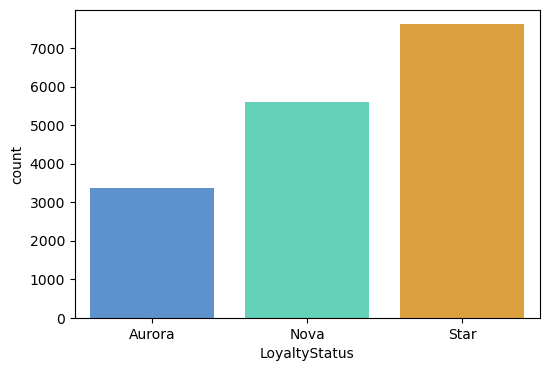

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(
    data=CustomerDB,
    x="LoyaltyStatus",
    order=["Aurora", "Nova", "Star"],
    palette=["#4A90E2", "#50E3C2", "#F5A623"]
)
plt.show()


### Income and Customer Lifetime Value

In [61]:
CustomerDB = CustomerDB.copy()

income_clv = CustomerDB[['Income', 'Customer Lifetime Value']].dropna()
threshold_income = income_clv['Income'].quantile(0.1)
threshold_clv = income_clv['Customer Lifetime Value'].quantile(0.9)
suspicious = CustomerDB[
    (CustomerDB['Income'] < threshold_income) &
    (CustomerDB['Customer Lifetime Value'] > threshold_clv)
]

print(f"\nPossible inconsistencies found: {len(suspicious)} customers")
display(suspicious[['Loyalty#', 'Income', 'Customer Lifetime Value']].head(10))


Possible inconsistencies found: 0 customers


Empty DataFrame
Columns: [Loyalty#, Income, Customer Lifetime Value]
Index: []

For **CustomerDB** dataset we checked some inconsistencies:

- We have some rows where **Cancellation Date** is smaller than **Enrollment Date Opening**
- **Latitude** and **Longitude** who don't match with the city or province,
- Some High-tier customers with very low activity


## FlightsDB

In [62]:
numerical_columns_flights = FlightsDB.select_dtypes(include=['number']).columns.tolist()
categorical_columns_flights = FlightsDB.select_dtypes(exclude=['number']).columns.tolist()

for col in numerical_columns_flights:
    print(f"---{col}---")
    print(FlightsDB[col].unique())
    print()

---Year---
[2021 2020 2019]

---Month---
[12  6  5  4  3  2  1 11 10  9  8  7]

---NumFlights---
[ 2  0 10 16  9 12 17  6 11  7  3 13 14  8  5  4  1 15 18 20 19 21]

---NumFlightsWithCompanions---
[ 2  0  3  4  7  9  5  6  1  8 10 11]

---DistanceKM---
[ 9384.      0.  14745.  ... 11732.4 31998.6 26789.4]

---PointsAccumulated---
[ 938    0 1474 ... 4107   23   21]

---PointsRedeemed---
[   0 3213 4638 ... 5691 4598 5527]

---DollarCostPointsRedeemed---
[ 0.  32.  46.  40.  51.  62.  48.  50.  59.  43.  37.  41.  53.  56.
 31.  30.  63.  33.  44.  58.  60.  57.  36.  29.  42.  54.  45.  35.
 67.  39.  65.  34.  61.  66.  38.  47.  55.  68.  69.  64.  52.  49.
 71.  72.  27.  28.  70.  25.  26.  24.  23.  21.  22.  74.  73.  32.4
 36.9 27.9 21.6 26.1 31.5 33.3 22.5 40.5 28.8 37.8 24.3 20.7 29.7 30.6
 35.1 25.2 23.4 34.2 41.4 39.6 19.8 38.7 18.9 51.3 42.3 52.2 50.4 45.9
 47.7 48.6 43.2 46.8 44.1 49.5 53.1 57.6 60.3 62.1 54.9 58.5 55.8 56.7
 63.9 61.2 64.8 59.4 65.7 66.6]



In [63]:
for col in categorical_columns_flights:
    print(f"---{col}---")
    print(FlightsDB[col].unique())
    print()

---Loyalty#---
['413052' '464105' '681785' ... '144328' '179042' '854855']

---YearMonthDate---
<DatetimeArray>
['2021-12-01 00:00:00', '2020-06-01 00:00:00', '2020-05-01 00:00:00',
 '2020-04-01 00:00:00', '2020-03-01 00:00:00', '2020-02-01 00:00:00',
 '2020-01-01 00:00:00', '2021-11-01 00:00:00', '2021-10-01 00:00:00',
 '2021-06-01 00:00:00', '2021-09-01 00:00:00', '2021-05-01 00:00:00',
 '2021-04-01 00:00:00', '2021-08-01 00:00:00', '2021-07-01 00:00:00',
 '2021-03-01 00:00:00', '2021-02-01 00:00:00', '2021-01-01 00:00:00',
 '2020-12-01 00:00:00', '2020-11-01 00:00:00', '2020-10-01 00:00:00',
 '2020-09-01 00:00:00', '2020-08-01 00:00:00', '2020-07-01 00:00:00',
 '2019-01-01 00:00:00', '2019-02-01 00:00:00', '2019-03-01 00:00:00',
 '2019-04-01 00:00:00', '2019-05-01 00:00:00', '2019-06-01 00:00:00',
 '2019-07-01 00:00:00', '2019-08-01 00:00:00', '2019-09-01 00:00:00',
 '2019-10-01 00:00:00', '2019-11-01 00:00:00', '2019-12-01 00:00:00']
Length: 36, dtype: datetime64[ns]



### Month

In [64]:
# Check months are between 1 and 12
invalid_months = FlightsDB[(FlightsDB['Month'] < 1) | (FlightsDB['Month'] > 12)]
print("Invalid months (should be 1-12):")
print(invalid_months[['YearMonthDate', 'Month']])


Invalid months (should be 1-12):
Empty DataFrame
Columns: [YearMonthDate, Month]
Index: []


### YearMonthDate

In [65]:
# Extract month, day, year as integers
FlightsDB['month'] = FlightsDB['YearMonthDate'].dt.month
FlightsDB['day'] = FlightsDB['YearMonthDate'].dt.day
FlightsDB['year'] = FlightsDB['YearMonthDate'].dt.year

# Check months are 1-12
invalid_months = FlightsDB[(FlightsDB['month'] < 1) | (FlightsDB['month'] > 12)]

# Check days are 1-31
invalid_days = FlightsDB[(FlightsDB['day'] < 1) | (FlightsDB['day'] > 31)]

# Check years are within expected range
invalid_years = FlightsDB[~FlightsDB['year'].isin([2019, 2020, 2021])]

# Print only relevant columns
print("Invalid months:\n", invalid_months[['YearMonthDate','month']])
print("Invalid days:\n", invalid_days[['YearMonthDate','day']])
print("Invalid years (should only be 2019, 2020, 2021):\n", invalid_years[['YearMonthDate','year']])

# Summary of results
if invalid_months.empty and invalid_days.empty and invalid_years.empty:
    print("All dates appear valid.")
else:
    print(f"Invalid date components detected: {len(invalid_months) + len(invalid_days) + len(invalid_years)} issues")



Invalid months:
 Empty DataFrame
Columns: [YearMonthDate, month]
Index: []
Invalid days:
 Empty DataFrame
Columns: [YearMonthDate, day]
Index: []
Invalid years (should only be 2019, 2020, 2021):
 Empty DataFrame
Columns: [YearMonthDate, year]
Index: []
All dates appear valid.


### Numerical Features > 0

In [66]:
invalid_numeric = FlightsDB[(FlightsDB[numerical_columns_flights] < 0).any(axis=1)]

print("\nRows with negative numeric values:")
print(invalid_numeric[['YearMonthDate'] + numerical_columns_flights])

# Summary
if invalid_months.empty and invalid_numeric.empty:
    print("\nAll months and numeric values are valid.")
else:
    print(f"\nFound {len(invalid_months)} invalid months and {len(invalid_numeric)} rows with negative numeric values.")


Rows with negative numeric values:
Empty DataFrame
Columns: [YearMonthDate, Year, Month, NumFlights, NumFlightsWithCompanions, DistanceKM, PointsAccumulated, PointsRedeemed, DollarCostPointsRedeemed]
Index: []

All months and numeric values are valid.


### Points Accumulated and Points Redeemed

In [67]:
# Group by Loyalty# and sum the relevant numeric columns
FlightsDB = FlightsDB.copy()

loyalty_summary = FlightsDB.groupby('Loyalty#').agg({
    'PointsAccumulated': 'sum',
    'PointsRedeemed': 'sum',
    'NumFlights': 'sum',
    'NumFlightsWithCompanions': 'sum',
    'DistanceKM': 'sum'
}).reset_index()

# Check points consistency: PointsAccumulated >= PointsRedeemed
loyalty_summary['points_consistent'] = loyalty_summary['PointsAccumulated'] >= loyalty_summary['PointsRedeemed']

# Identify rows where consistency fails
points_issues = loyalty_summary[loyalty_summary['points_consistent'] == False]

print("Loyalty# with Points Issues (Accumulated < Redeemed):")

print(f"Customers with points violations: {len(points_issues)}")
points_issues.head()



Loyalty# with Points Issues (Accumulated < Redeemed):
Customers with points violations: 458


Loyalty#  PointsAccumulated  PointsRedeemed  NumFlights  \
81    103975               5457            9014          50   
120   106444              12108           12947          47   
170   108857               8036           10549          44   
174   109023              21902           25590         165   
299   116238               6771            6798          48   

     NumFlightsWithCompanions  DistanceKM  points_consistent  
81                         11     54588.0              False  
120                        10    121106.0              False  
170                        10     80398.9              False  
174                        41    219114.3              False  
299                        14     67729.0              False

### Number of Flights and Number of Flights with Companions

In [68]:
# Check flights consistency: NumFlights >= NumFlightsWithCompanions
loyalty_summary['flights_consistent'] = loyalty_summary['NumFlights'] >= loyalty_summary['NumFlightsWithCompanions']

flights_issues = loyalty_summary[loyalty_summary['flights_consistent']==False]
print("\nLoyalty# with Flights Issues (NumFlights < NumFlightsWithCompanions):")
flights_issues.head()


Loyalty# with Flights Issues (NumFlights < NumFlightsWithCompanions):


Empty DataFrame
Columns: [Loyalty#, PointsAccumulated, PointsRedeemed, NumFlights, NumFlightsWithCompanions, DistanceKM, points_consistent, flights_consistent]
Index: []

### Distance KM and Points Accumulated

In [69]:
# Filter rows where DistanceKM > 0 but PointsAccumulated is 0 or missing
FlightsDB = FlightsDB.copy()

distance_no_points = FlightsDB[
    (FlightsDB['DistanceKM'] > 0) & 
    ((FlightsDB['PointsAccumulated'] == 0) | (FlightsDB['PointsAccumulated'].isna()))
]

# Show first few problematic rows
print("Sample rows where DistanceKM > 0 but PointsAccumulated is missing or zero:")
print(distance_no_points.head())

# Count total number of such rows
num_distance_no_points = distance_no_points.shape[0]
print(f"\nTotal rows with DistanceKM > 0 but PointsAccumulated = 0 or NaN: {num_distance_no_points}")


Sample rows where DistanceKM > 0 but PointsAccumulated is missing or zero:
Empty DataFrame
Columns: [Loyalty#, Year, Month, YearMonthDate, NumFlights, NumFlightsWithCompanions, DistanceKM, PointsAccumulated, PointsRedeemed, DollarCostPointsRedeemed, month, day, year]
Index: []

Total rows with DistanceKM > 0 but PointsAccumulated = 0 or NaN: 0


In [70]:
# Filter rows where PointsAccumulated > 0 but DistanceKM is 0 or missing
points_no_distance = FlightsDB[
    (FlightsDB['PointsAccumulated'] > 0) &
    ((FlightsDB['DistanceKM'] == 0) | (FlightsDB['DistanceKM'].isna()))
]

# Show first few problematic rows
print("Sample rows where PointsAccumulated > 0 but DistanceKM = 0 or NaN:")
print(points_no_distance.head())

# Count total number of such rows
num_points_no_distance = points_no_distance.shape[0]
print(f"\nTotal rows with PointsAccumulated > 0 but DistanceKM = 0 or NaN: {num_points_no_distance}")


Sample rows where PointsAccumulated > 0 but DistanceKM = 0 or NaN:
Empty DataFrame
Columns: [Loyalty#, Year, Month, YearMonthDate, NumFlights, NumFlightsWithCompanions, DistanceKM, PointsAccumulated, PointsRedeemed, DollarCostPointsRedeemed, month, day, year]
Index: []

Total rows with PointsAccumulated > 0 but DistanceKM = 0 or NaN: 0


### Points Redeemed and Dollar Cost Points Redeemed

In [71]:
FlightsDB = FlightsDB.copy()

# Check logical consistency between PointsRedeemed and DollarCostPointsRedeemed
inconsistent_costs = FlightsDB[
    (FlightsDB["PointsRedeemed"] == 0) & (FlightsDB["DollarCostPointsRedeemed"] > 0)
]

print(f"Number of inconsistent rows: {len(inconsistent_costs)}")

# Optional: show some examples
if not inconsistent_costs.empty:
    display(inconsistent_costs.head(10))


Number of inconsistent rows: 0


Some inconsistencies found in **FlightsDB**:
- There are some rows where **Points Accumulated** are smaller than **Points Redeemed**

## CustomerDB

### Univariate Analysis

In [72]:
CustomerDB.to_csv('CustomerDB_clean.csv')

In [73]:
# Verificar se existem valores duplicados na coluna 'Loyalty#'
duplicates = CustomerDB[CustomerDB.duplicated(subset=['Loyalty#'], keep=False)]

# Mostrar as linhas duplicadas
duplicates

Empty DataFrame
Columns: [Loyalty#, First Name, Last Name, Customer Name, Country, Province or State, City, Latitude, Longitude, Postal code, Gender, Education, Location Code, Income, Marital Status, LoyaltyStatus, EnrollmentDateOpening, CancellationDate, Customer Lifetime Value, EnrollmentType, ValidPostalCode, FullName, distance_to_ref_km, coordinates_match, TierRank]
Index: []

[0 rows x 25 columns]

#### Categorical Features

##### Histograms

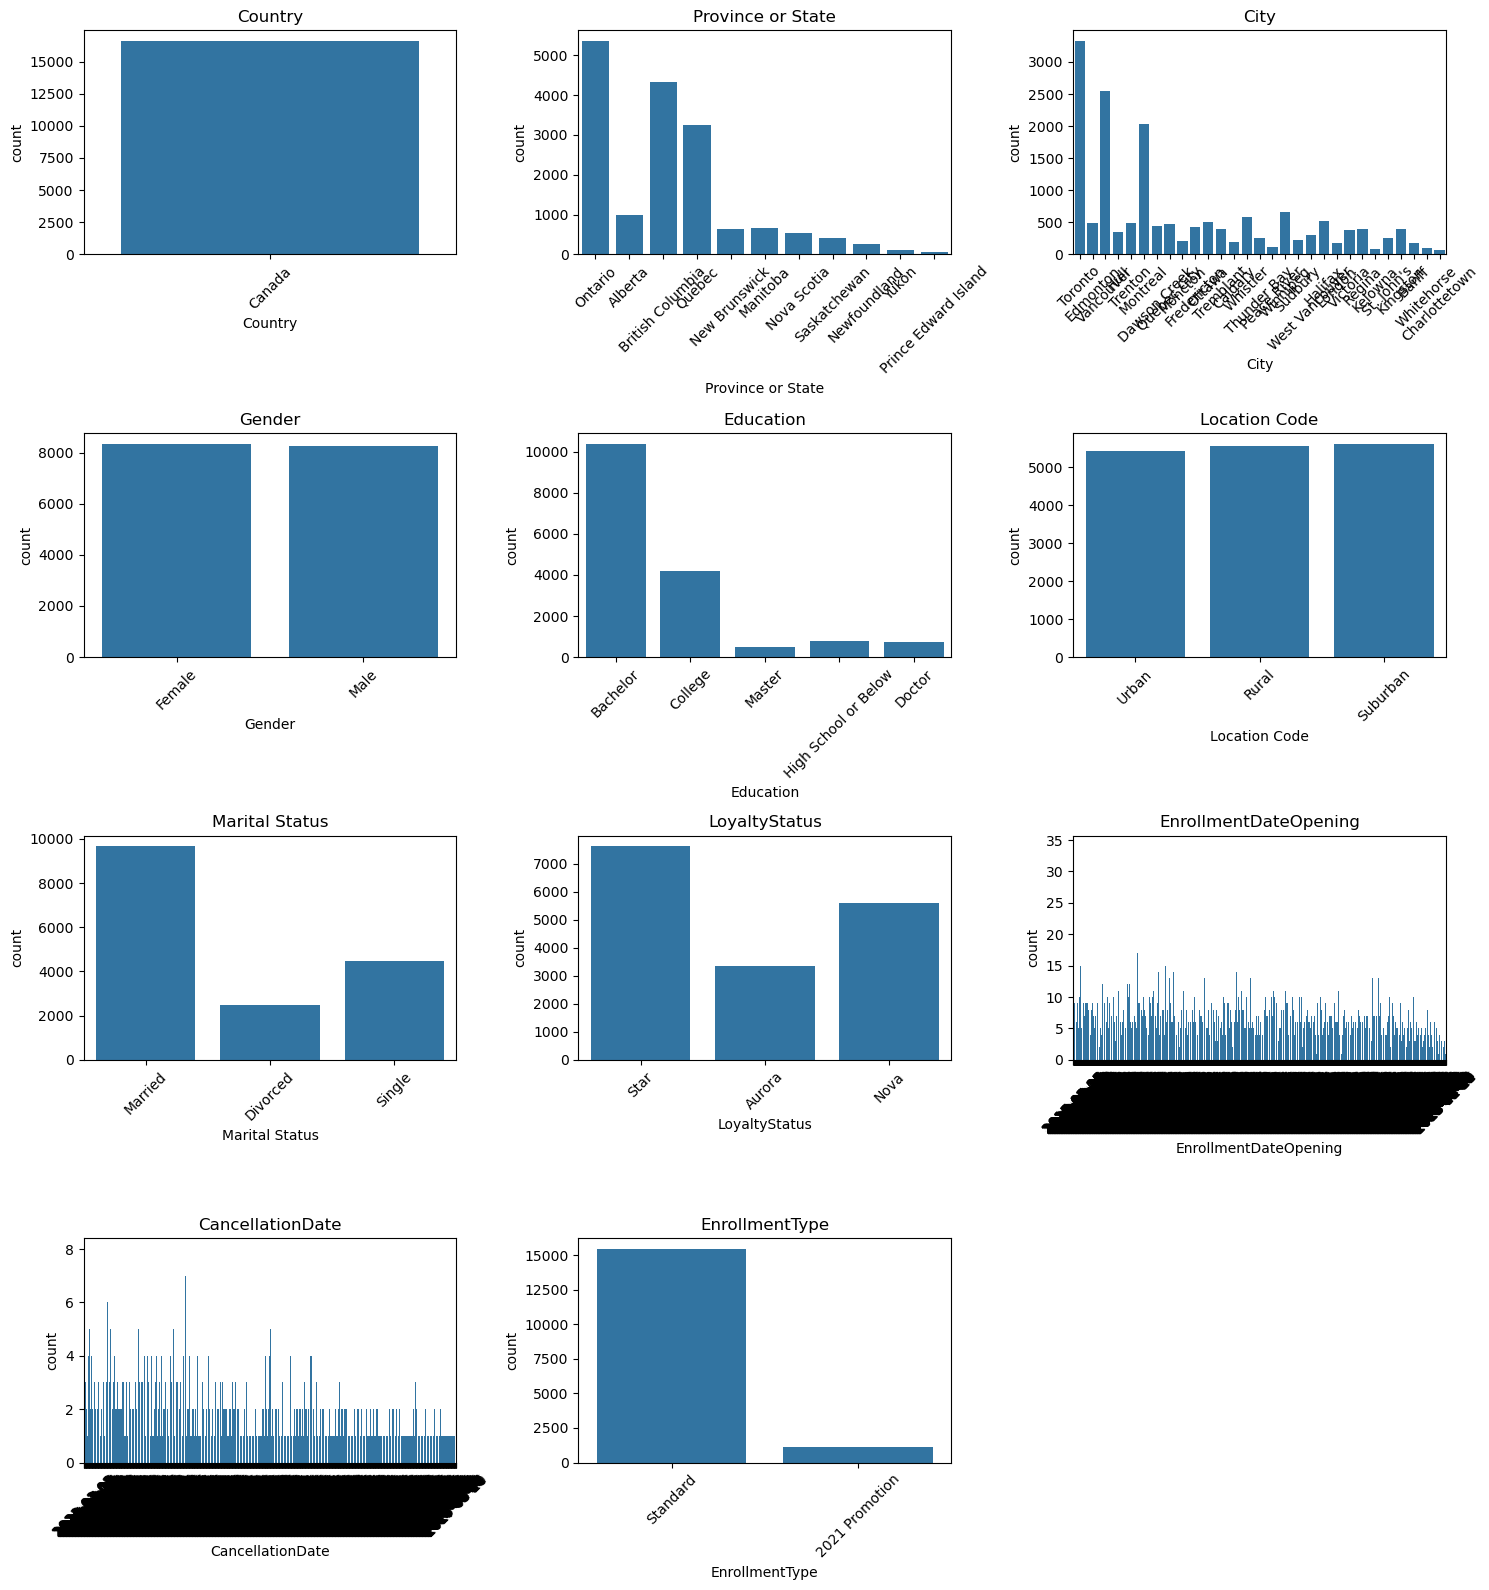

In [74]:
exclude_cols = ['First Name', 'Customer Name', 'Postal code', 'Last Name', 'Loyalty#']
categorical_cols_filtered = [col for col in categorical_columns_customer if col not in exclude_cols]

# Number of columns per row
cols_per_row = 3

# Calculate number of rows needed
num_rows = math.ceil(len(categorical_cols_filtered) / cols_per_row)

# Set up the figure
fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(5*cols_per_row, 4*num_rows))
axes = axes.flatten()  # flatten in case we have less plots than grid

for i, col in enumerate(categorical_cols_filtered):
    sns.countplot(data=CustomerDB, x=col, ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

# Turn off any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

- **Gender**: similar proportion for both men and women, indicating that it holds significance for cluster analysis
- **Location Code**: also demonstrastes a good distribution, making it useful for clustering.
- **EnrollmentType**, **Education** and **Marital Status** exhibit substantial proportional differences, which suggests they may not serve as strong indicators for defininf clusters

##### Pie Chart

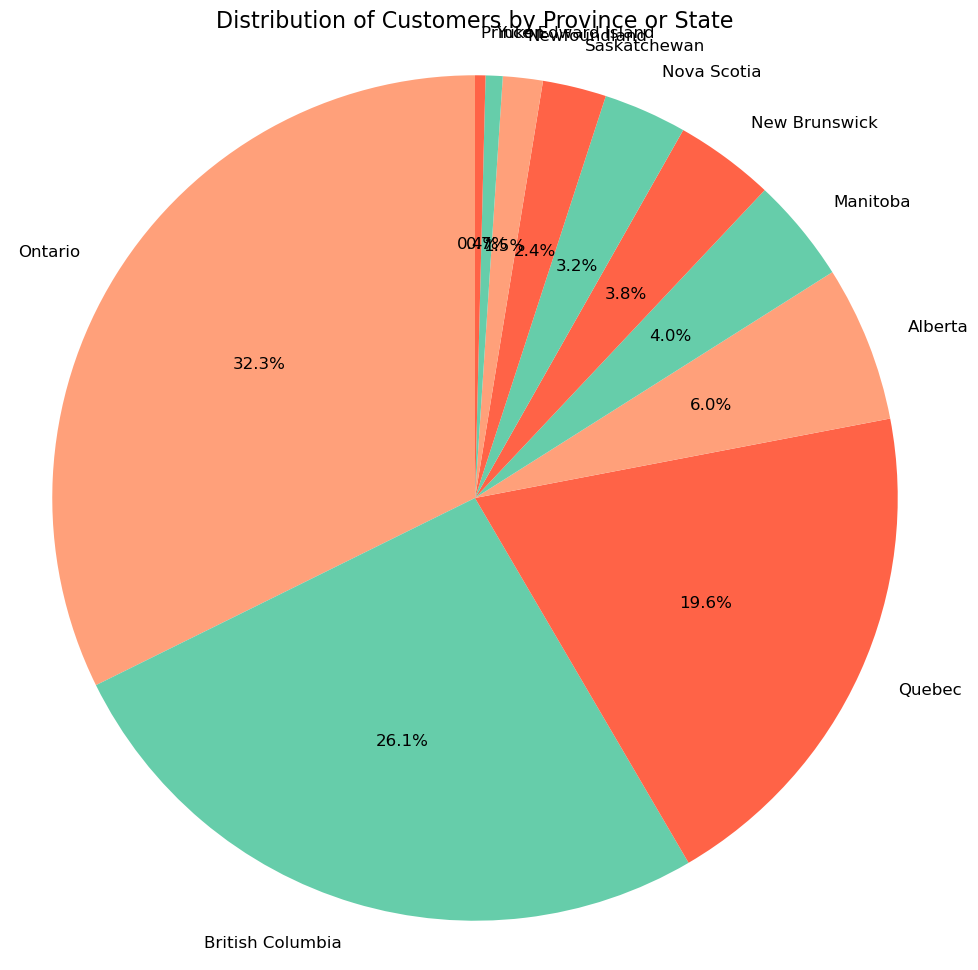

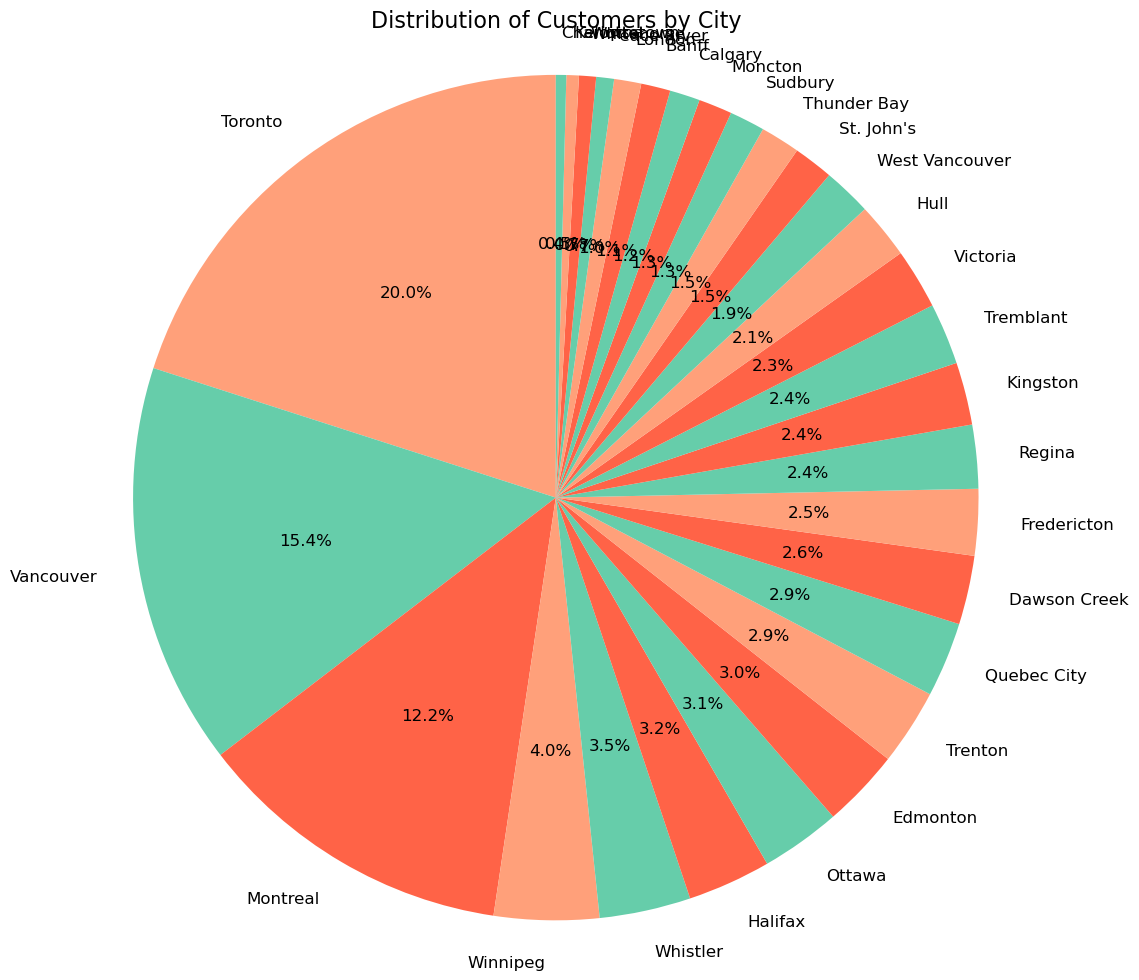

In [75]:
columns_to_plot = ['Province or State', 'City']

colors = ['lightsalmon', 'mediumaquamarine', 'tomato','lightsalmon', 
          'mediumaquamarine','tomato', 'mediumaquamarine', 'tomato']

for col in columns_to_plot:
    counts = CustomerDB[col].value_counts()
    
    plt.figure(figsize=(12, 12))
    plt.pie(
        counts, 
        labels=counts.index, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=colors[:len(counts)],  # Use only as many colors as needed
        textprops={'fontsize': 12}
    )
    plt.title(f'Distribution of Customers by {col}', fontsize=16)
    plt.axis('equal')
    plt.show()
    

#### Geospatial Data

In [76]:
import folium

# initialize the map and store it in a m object
m = folium.Map(location = [56.130, -106.35],
               zoom_start = 4)

# show the map
m.save('my_map.html')


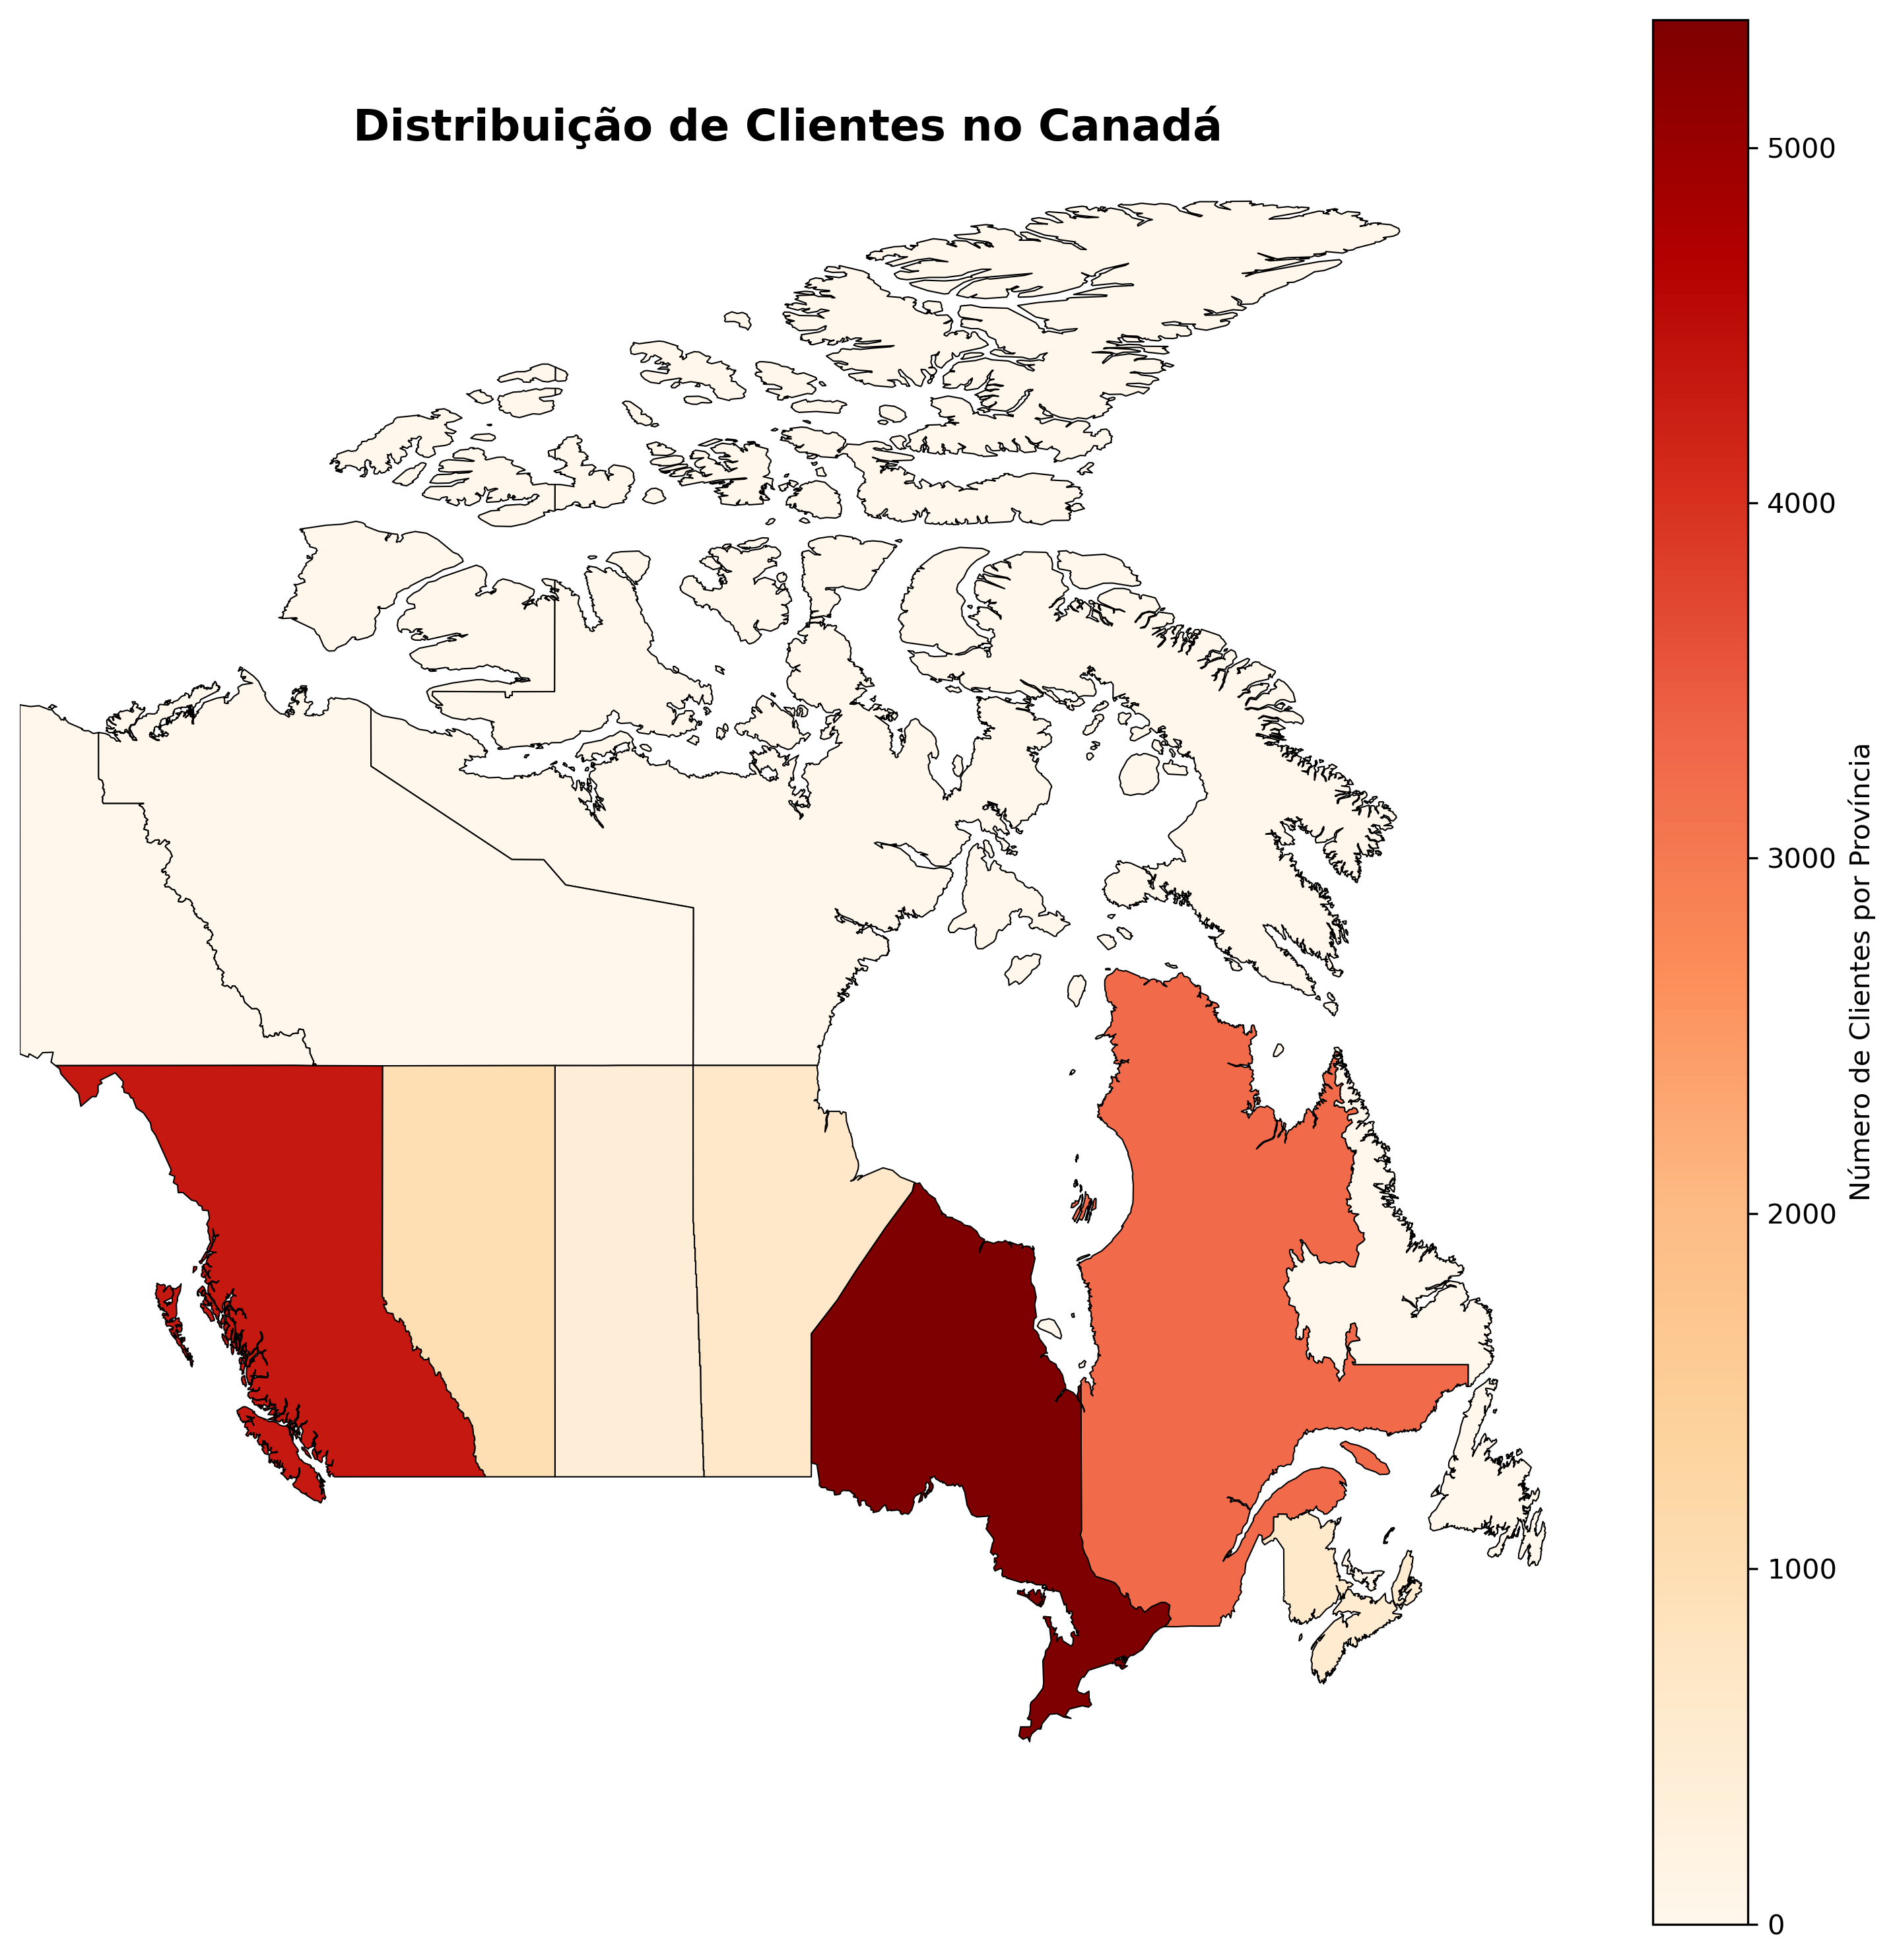

In [77]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

# ------------------------------------------
# 1️⃣ Agrupar os dados do CustomerDB por província
# ------------------------------------------
# Exemplo: contar quantos clientes por província
clientes_por_provincia = (
    CustomerDB.groupby("Province or State")
    .size()
    .reset_index(name="TotalClientes")
)

# ------------------------------------------
# 2️⃣ Carregar o mapa das províncias do Canadá
# ------------------------------------------
provinces = gpd.read_file(
    "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/canada.geojson"
)

# Visualiza as colunas disponíveis (para saber o nome da coluna de província)
# print(provinces.columns)
# print(provinces.head())

# O GeoJSON usa a coluna "name" para o nome da província

# ------------------------------------------
# 3️⃣ Unir o shapefile com os dados
# ------------------------------------------
provinces = provinces.merge(
    clientes_por_provincia,
    how="left",
    left_on="name",
    right_on="Province or State"
)

# Substituir valores NaN (províncias sem clientes) por 0
provinces["TotalClientes"] = provinces["TotalClientes"].fillna(0)

# ------------------------------------------
# 4️⃣ Criar o mapa
# ------------------------------------------
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

# Criar o choropleth
provinces.plot(
    ax=ax,
    column="TotalClientes",
    cmap="OrRd",          # esquema de cores (amarelo → vermelho)
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    legend_kwds={
        "label": "Número de Clientes por Província",
        "orientation": "vertical"
    }
)

ax.set_xlim(-141, -52)
ax.set_ylim(41, 84)
ax.set_axis_off()
ax.set_title("Distribuição de Clientes no Canadá", fontsize=16, fontweight="bold", pad=10)

plt.tight_layout()
plt.show()




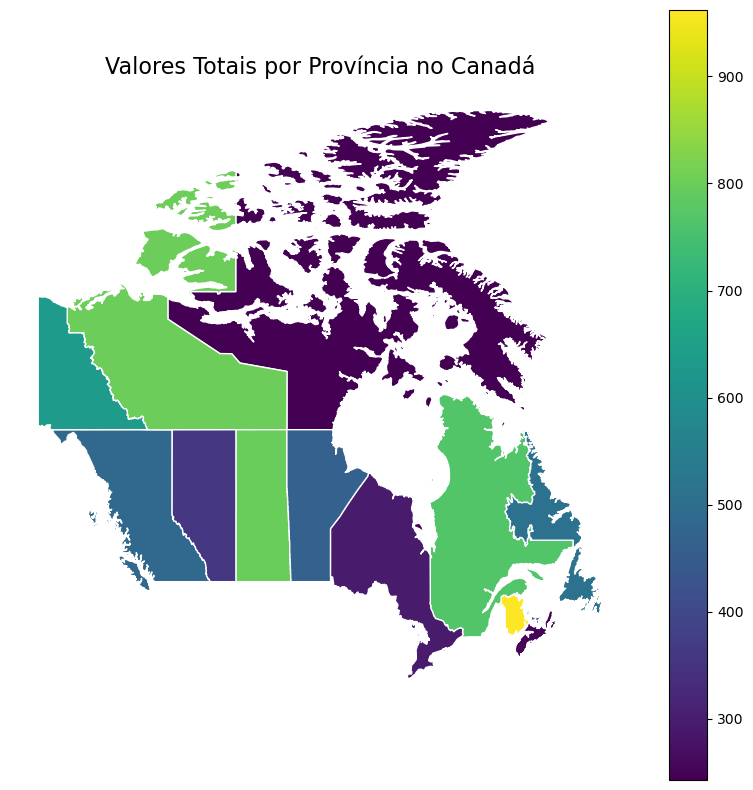

In [78]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# 1. Carregar um mapa com as formas das províncias do Canadá
url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/canada.geojson"
canada = gpd.read_file(url)
# 2. Filtrar apenas o Canadá
# 2. Adicionar os seus dados
# Para este exemplo, vamos criar uma coluna "Total" com dados aleatórios.
# No seu caso, você carregaria os seus dados e os juntaria ao GeoDataFrame 'canada'.
canada['Total'] = np.random.randint(100, 1000, size=len(canada))

# 3. Desenhar o mapa
fig, ax = plt.subplots(figsize=(10, 10))

canada.plot(
    ax=ax,
    column='Total',      # Coluna usada para definir as cores
    cmap='viridis',      # Esquema de cores (outros: 'plasma', 'inferno', 'YlOrBr')
    edgecolor='white',   # Cor das fronteiras entre províncias
    legend=True          # Mostra a barra de legenda de cores
)

# 4. Limpar o visual do mapa
ax.set_axis_off()
ax.set_title("Valores Totais por Província no Canadá", fontsize=16)

plt.show()

In [79]:
import pandas as pd
import geopandas as gpd


# Crie um GeoDataFrame a partir da latitude e longitude
# EPSG:4326 é o sistema de coordenadas padrão para lat/lon
gdf_clientes = gpd.GeoDataFrame(
    CustomerDB,
    geometry=gpd.points_from_xy(CustomerDB['Longitude'], CustomerDB['Latitude']),
    crs="EPSG:4326"
)

print("GeoDataFrame criado com sucesso!")
print(gdf_clientes.head())

GeoDataFrame criado com sucesso!
  Loyalty# First Name    Last Name        Customer Name Country  \
0   480934    Cecilia  Householder  Cecilia Householder  Canada   
1   549612      Dayle        Menez          Dayle Menez  Canada   
2   429460     Necole       Hannon        Necole Hannon  Canada   
3   608370      Queen        Hagee          Queen Hagee  Canada   
4   530508     Claire      Latting       Claire Latting  Canada   

  Province or State       City   Latitude   Longitude Postal code  ...  \
0           Ontario    Toronto  43.653225  -79.383186     M2Z 4K1  ...   
1           Alberta   Edmonton  53.544388 -113.490930     T3G 6Y6  ...   
2  British Columbia  Vancouver  49.282730 -123.120740     V6E 3D9  ...   
3           Ontario    Toronto  43.653225  -79.383186     P1W 1K4  ...   
4            Quebec       Hull  45.428730  -75.713364     J8Y 3Z5  ...   

  EnrollmentDateOpening CancellationDate Customer Lifetime Value  \
0            2019-02-15              NaT           

In [80]:
import folium
from folium.plugins import HeatMap

# 1. Criar um mapa base centrado no Canadá
# Coordenadas aproximadas do centro do Canadá e nível de zoom inicial
mapa_canada = folium.Map(location=[56.1304, -106.3468], zoom_start=4)

# 2. Preparar os dados para o heatmap
# O plugin HeatMap precisa de uma lista de [latitude, longitude]
dados_heatmap = gdf_clientes[['Latitude', 'Longitude']].values.tolist()

# 3. Adicionar a camada de heatmap ao mapa
HeatMap(dados_heatmap, radius=15).add_to(mapa_canada)

# 4. Guardar o mapa num ficheiro HTML
mapa_canada.save('mapa_calor_clientes.html')

print("Mapa de calor 'mapa_calor_clientes.html' criado com sucesso! Abra este ficheiro no seu navegador.")

Mapa de calor 'mapa_calor_clientes.html' criado com sucesso! Abra este ficheiro no seu navegador.


In [81]:
import folium
from folium.plugins import MarkerCluster

# 1. Criar um mapa base centrado no Canadá
mapa_canada_cluster = folium.Map(location=[56.1304, -106.3468], zoom_start=4)

# 2. Criar um objeto de cluster
marker_cluster = MarkerCluster().add_to(mapa_canada_cluster)

# 3. Adicionar cada cliente ao objeto de cluster
for idx, row in gdf_clientes.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['City'] # Opcional: mostrar a cidade ao clicar
    ).add_to(marker_cluster)

# 4. Guardar o mapa num ficheiro HTML
mapa_canada_cluster.save('mapa_clusters_clientes.html')

print("Mapa de clusters 'mapa_clusters_clientes.html' criado com sucesso! Abra este ficheiro no seu navegador.")

Mapa de clusters 'mapa_clusters_clientes.html' criado com sucesso! Abra este ficheiro no seu navegador.


##### Enrollment Type

In [82]:
enrollment_prop = CustomerDB['EnrollmentType'].value_counts(normalize=True).round(4) * 100

print(enrollment_prop.reset_index().rename(columns={'index': 'EnrollmentType', 'EnrollmentType': 'Percentage (%)'}))

   Percentage (%)  proportion
0        Standard       93.14
1  2021 Promotion        6.86


This imbalance on **EnrollmentType** can reduce the variable’s effectiveness in distinguishing clusters because most data points have the same value. We will drop this feature since does not give us relevant information.

### Numerical Features

#### HIstograms

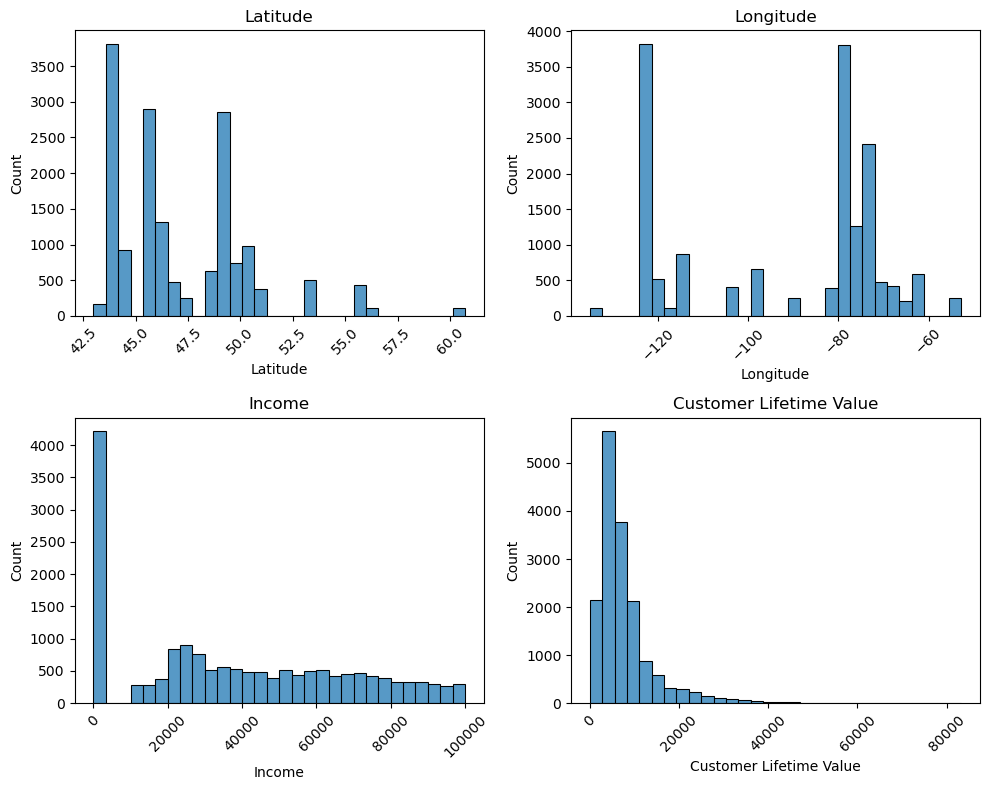

In [83]:
exclude_numeric_cols = ['Loyalty#', 'distance_to_ref_km']

numeric_cols_filtered = [col for col in numerical_columns_customer if col not in exclude_numeric_cols]

cols_per_row = 2

num_rows = math.ceil(len(numeric_cols_filtered) / cols_per_row)

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(5*cols_per_row, 4*num_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols_filtered):
    sns.histplot(CustomerDB[col], kde=False, ax=axes[i], bins=30)
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


- **Latitude**: Distribution is multi-modal, with several peaks. Most customers are concentrated between 42.50 degrees and a small number of customers exist at extreme latitudes, which could be outliers.
- **Income**: Highly skewed to the left (most values near 0). Many customers have very low income, with a long tail extendind up to 100.000.
- **CLV**: Roght-skewed as well, with most of customers have low CLV. A long tail indicates a few high-value customers.

#### Boxplots

##### Outliers

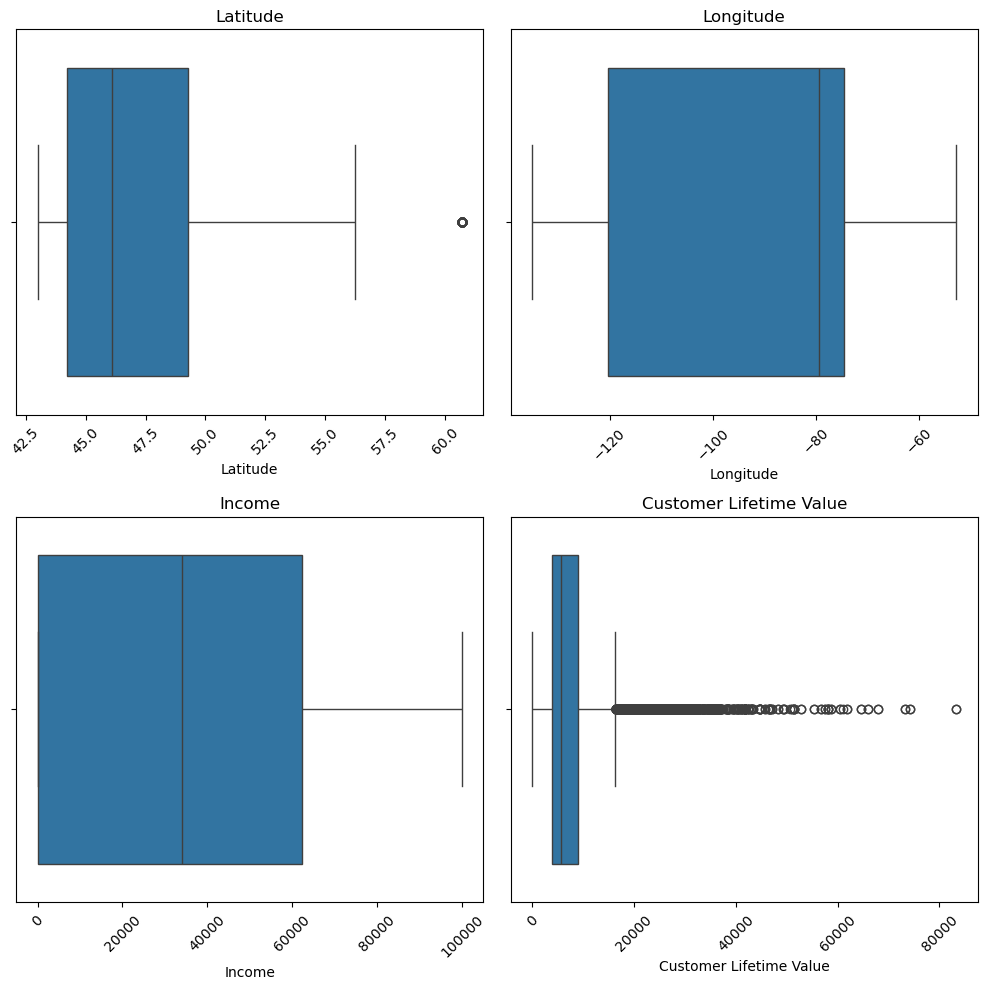

In [84]:
cols_per_row = 2

num_rows = math.ceil(len(numeric_cols_filtered) / cols_per_row)

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(5*cols_per_row, 5*num_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols_filtered):
    sns.boxplot(data=CustomerDB, x=col, ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


**Latitude** – There is a single noticeable outlier at around 60°, which might represent a customer located much farther north than most (possibly from Alaska or Northern Canada if this is U.S.-based data).

**Longitude** – No major outliers are visible; values are mostly within a normal U.S. range (around -130° to -60°).

**Income** – The distribution looks relatively symmetric, and there are no strong outliers. Most incomes fall below 100,000.

**Customer Lifetime Value (CLV)** – This variable has a significant number of outliers on the higher end. Many points are scattered far beyond the upper whisker, indicating customers with exceptionally high lifetime values compared to the rest.
These may represent high-value or loyal customers, or possibly data entry errors (e.g., misplaced decimal points).

##### Latitude

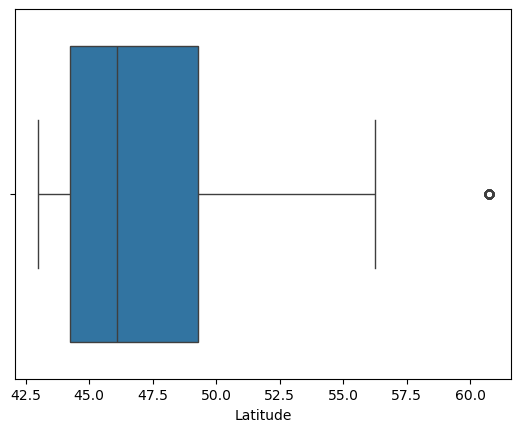

In [85]:
sns.boxplot(x=CustomerDB['Latitude'])
plt.show()

In [86]:
Q1 = CustomerDB['Latitude'].quantile(0.25)
Q3 = CustomerDB['Latitude'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers_latitude = CustomerDB[(CustomerDB['Latitude'] < lower_bound) | (CustomerDB['Latitude'] > upper_bound)]

print("Outlier boundaries:")
print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")

print("\nOutlier rows:")
print(outliers_latitude[['Latitude']])

count = outliers_latitude.shape[0]
print(f"\nTotal number of outliers in Latitude: {count}")


Outlier boundaries:
Lower bound: 36.65383250000001
Upper bound: 56.8600685

Outlier rows:
        Latitude
394    60.721188
397    60.721188
499    60.721188
648    60.721188
809    60.721188
...          ...
16021  60.721188
16029  60.721188
16161  60.721188
16215  60.721188
16507  60.721188

[108 rows x 1 columns]

Total number of outliers in Latitude: 108


In [87]:
outliers_latitude.head(10).sort_values(by='Loyalty#')

Loyalty# First Name Last Name      Customer Name Country  \
648    121935      Lesia   Droesch      Lesia Droesch  Canada   
394    211043       Ngoc  Naughton      Ngoc Naughton  Canada   
499    304944    Seymour   Sheerin    Seymour Sheerin  Canada   
1754   356618        Jae  Broccoli       Jae Broccoli  Canada   
809    399575        Amy  Bradigan       Amy Bradigan  Canada   
944    508115     Agatha    Gilden      Agatha Gilden  Canada   
397    517758     Golden      Maag        Golden Maag  Canada   
935    526064   Meredith  Adriance  Meredith Adriance  Canada   
1247   621750     Norris     Louro       Norris Louro  Canada   
1776   792332  Kimberely     Dejes    Kimberely Dejes  Canada   

     Province or State        City   Latitude  Longitude Postal code  ...  \
648              Yukon  Whitehorse  60.721188 -135.05684     Y2K 6R0  ...   
394              Yukon  Whitehorse  60.721188 -135.05684     Y2K 6R0  ...   
499              Yukon  Whitehorse  60.721188 -135.05684     Y2K 6R0  ...   
1754             Yukon  Whitehorse  60.721188 -135.05684     Y2K 6R0  ...   
809              Yukon  Whitehorse  60.721188 -135.05684     Y2K 6R0  ...   
944              Yukon  Whitehorse  60.721188 -135.05684     Y2K 6R0  ...   
397              Yukon  Whitehorse  60.721188 -135.05684     Y2K 6R0  ...   
935              Yukon  Whitehorse  60.721188 -135.05684     Y2K 6R0  ...   
1247             Yukon  Whitehorse  60.721188 -135.05684     Y2K 6R0  ...   
1776             Yukon  Whitehorse  60.721188 -135.05684     Y2K 6R0  ...   

     LoyaltyStatus EnrollmentDateOpening CancellationDate  \
648           Star            2018-10-19              NaT   
394           Star            2015-07-09              NaT   
499           Star            2017-01-04              NaT   
1754        Aurora            2017-03-08              NaT   
809         Aurora            2019-03-23              NaT   
944         Aurora            2020-03-04              NaT   
397           Star            2015-12-07              NaT   
935         Aurora            2021-05-22              NaT   
1247        Aurora            2017-07-31              NaT   
1776        Aurora            2015-06-26              NaT   

      Customer Lifetime Value  EnrollmentType ValidPostalCode  \
648                   4878.83  2021 Promotion            True   
394                   4566.12        Standard            True   
499                   4703.72        Standard            True   
1754                  6612.62        Standard            True   
809                   5033.39        Standard            True   
944                   5181.62        Standard            True   
397                   4570.67        Standard            True   
935                   5174.08        Standard            True   
1247                  5515.25        Standard            True   
1776                  6687.59        Standard            True   

               FullName distance_to_ref_km  coordinates_match TierRank  
648       Lesia Droesch           0.112158               True        3  
394       Ngoc Naughton           0.112158               True        3  
499     Seymour Sheerin           0.112158               True        3  
1754       Jae Broccoli           0.112158               True        1  
809        Amy Bradigan           0.112158               True        1  
944       Agatha Gilden           0.112158               True        1  
397         Golden Maag           0.112158               True        3  
935   Meredith Adriance           0.112158               True        1  
1247       Norris Louro           0.112158               True        1  
1776    Kimberely Dejes           0.112158               True        1  

[10 rows x 25 columns]

The latitude outliers identified in the dataset correspond to customers located in Whitehorse, Yukon (Latitude ≈ 60.72°). While they appear as statistical outliers due to their northern position relative to most customers, they are valid and meaningful records that reflect real business presence in northern regions.

Therefore, we have decided to retain these entries in the dataset. 

##### Customer Lifetime Value

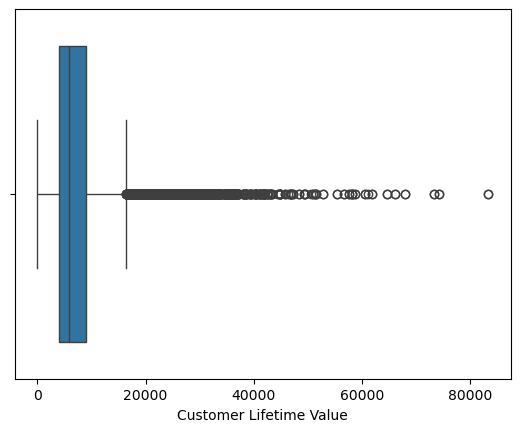

In [88]:
sns.boxplot(x=CustomerDB['Customer Lifetime Value'])
plt.show()

In [89]:
Q1 = CustomerDB['Customer Lifetime Value'].quantile(0.25)
Q3 = CustomerDB['Customer Lifetime Value'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers_CLV = CustomerDB[(CustomerDB['Customer Lifetime Value'] < lower_bound) | (CustomerDB['Customer Lifetime Value'] > upper_bound)].sort_values(by='Customer Lifetime Value', ascending=False)

print("Outlier boundaries:")
print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")

print("\nOutlier rows:")
print(outliers_CLV[['Customer Lifetime Value']])

count = outliers_CLV.shape[0]
print(f"\nTotal number of outliers in CLV: {count}")


Outlier boundaries:
Lower bound: -3493.655000000002
Upper bound: 16395.585000000003

Outlier rows:
       Customer Lifetime Value
16900                 83325.38
16899                 83325.38
16898                 74228.52
9884                  74228.52
4161                  73225.96
...                        ...
9392                  16464.37
9391                  16460.08
16373                 16414.04
9390                  16407.66
3685                  16407.66

[1463 rows x 1 columns]

Total number of outliers in CLV: 1463


In [90]:
outliers_CLV.head(10)

Loyalty# First Name  Last Name    Customer Name Country  \
16900   652627     Ariane     Peyton    Ariane Peyton  Canada   
16899   615459     Dannie     Paplow    Dannie Paplow  Canada   
16898   776187     Janina       Lumb      Janina Lumb  Canada   
9884    844145    Tabitha    Simonds  Tabitha Simonds  Canada   
4161    592003     Cletus      Chafe     Cletus Chafe  Canada   
4162    767366      Alana  Sullinger  Alana Sullinger  Canada   
16897   680886      Jamee       Ahlm       Jamee Ahlm  Canada   
4160    838263    Delaine     Sitaca   Delaine Sitaca  Canada   
9883    495253      Petra       Rieu       Petra Rieu  Canada   
4159    179870       Inge      Brunn       Inge Brunn  Canada   

      Province or State         City   Latitude   Longitude Postal code  ...  \
16900          Manitoba     Winnipeg  49.895138  -97.138374     R2C 0M5  ...   
16899            Quebec     Montreal  45.501690  -73.567253     H2Y 4R4  ...   
16898  British Columbia    Vancouver  49.282730 -123.120740     V5R 1W3  ...   
9884            Ontario      Toronto  43.653225  -79.383186     P1J 8T7  ...   
4161      New Brunswick  Fredericton  45.963589  -66.643112     E3B 2H2  ...   
4162             Quebec     Montreal  45.501690  -73.567253     H4G 3T4  ...   
16897      Saskatchewan       Regina  50.445210 -104.618900     S1J 3C5  ...   
4160        Nova Scotia      Halifax  44.648766  -63.575237     B3J 9S2  ...   
9883   British Columbia     Whistler  50.116322 -122.957360     V6T 1Y8  ...   
4159             Quebec     Montreal  45.501690  -73.567253     H2Y 2W2  ...   

      LoyaltyStatus EnrollmentDateOpening CancellationDate  \
16900          Star            2018-12-03       2019-08-03   
16899          Star            2021-04-22       2021-12-22   
16898          Star            2017-03-24              NaT   
9884           Nova            2018-09-09       2019-04-07   
4161         Aurora            2021-03-11              NaT   
4162         Aurora            2020-03-21       2020-11-21   
16897          Star            2017-09-06              NaT   
4160         Aurora            2015-07-25              NaT   
9883           Nova            2018-04-08              NaT   
4159         Aurora            2020-07-02              NaT   

       Customer Lifetime Value  EnrollmentType ValidPostalCode  \
16900                 83325.38        Standard            True   
16899                 83325.38  2021 Promotion            True   
16898                 74228.52        Standard            True   
9884                  74228.52        Standard            True   
4161                  73225.96  2021 Promotion            True   
4162                  73225.96        Standard            True   
16897                 67907.27        Standard            True   
4160                  67907.27        Standard            True   
9883                  66025.75        Standard            True   
4159                  66025.75        Standard            True   

              FullName distance_to_ref_km  coordinates_match TierRank  
16900    Ariane Peyton           0.044744               True        3  
16899    Dannie Paplow           0.259117               True        3  
16898      Janina Lumb           2.479848               True        3  
9884   Tabitha Simonds           0.066656               True        2  
4161      Cletus Chafe           1.963049               True        1  
4162   Alana Sullinger           0.259117               True        1  
16897       Jamee Ahlm           0.374499               True        3  
4160    Delaine Sitaca           0.847533               True        1  
9883        Petra Rieu           0.238446               True        2  
4159        Inge Brunn           0.259117               True        1  

[10 rows x 25 columns]

We will take a more deep look beyond of this outliers, since by this heading we cannot yet conclude anything.

For this problem we can do one of three things:
- log transformation
- standard scaling
- min max scaling

## Bivariate and Multivariate Analysis

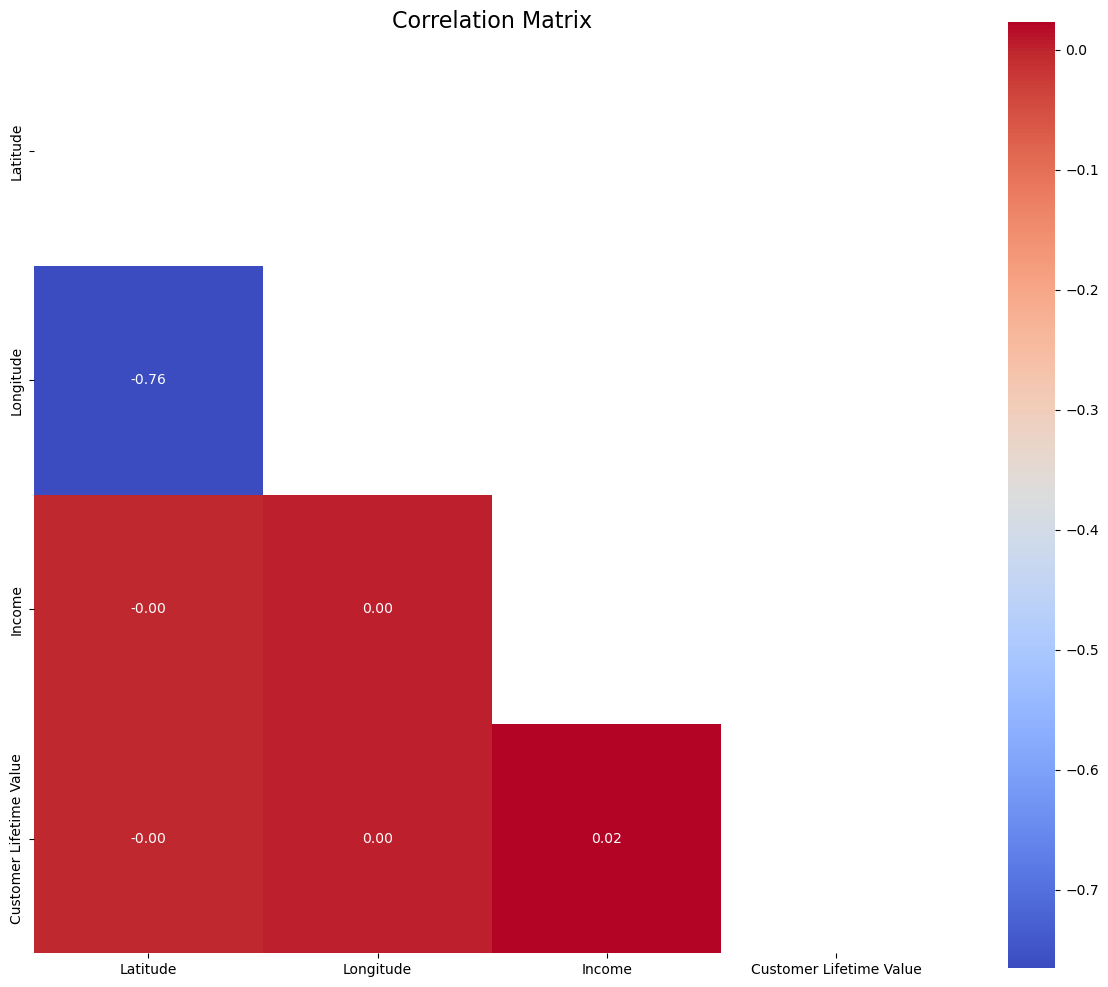

In [91]:
corr_matrix = CustomerDB[numeric_cols_filtered].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  

plt.figure(figsize=(12, 10))

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)

plt.title("Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()


In [92]:
corr_matrix.head()

Latitude  Longitude    Income  \
Latitude                 1.000000  -0.764939 -0.002197   
Longitude               -0.764939   1.000000  0.001680   
Income                  -0.002197   0.001680  1.000000   
Customer Lifetime Value -0.001906   0.004193  0.023130   

                         Customer Lifetime Value  
Latitude                               -0.001906  
Longitude                               0.004193  
Income                                  0.023130  
Customer Lifetime Value                 1.000000

Strong negative correlation between Latitude and Longitude → as Latitude increases, Longitude tends to decrease (or vice versa)

Makes sense geographically if customers are concentrated in a specific region.

No significant linear relationship between location and income or CLV.

Suggests other factors (like number of flights, engagement, loyalty) likely drive CLV more.

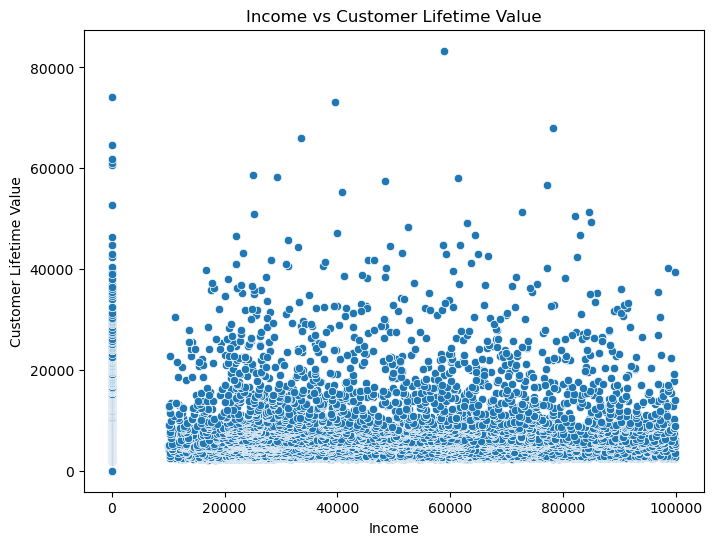

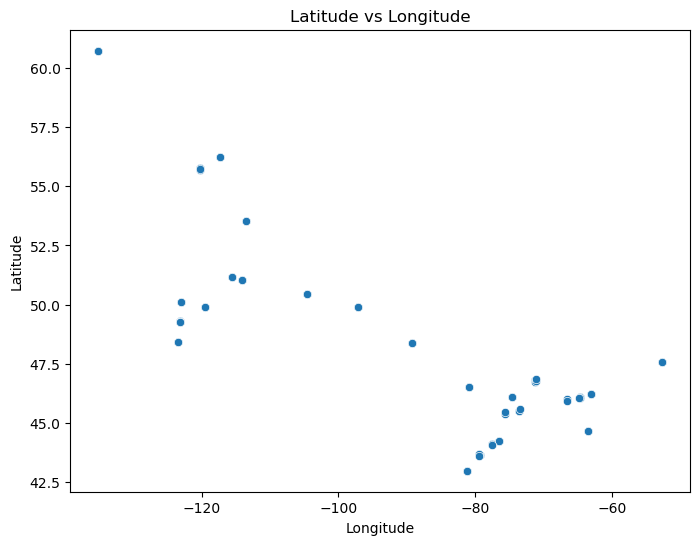

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(data=CustomerDB, x='Income', y='Customer Lifetime Value')
plt.title('Income vs Customer Lifetime Value')
plt.xlabel('Income')
plt.ylabel('Customer Lifetime Value')
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(data=CustomerDB, x='Longitude', y='Latitude')
plt.title('Latitude vs Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


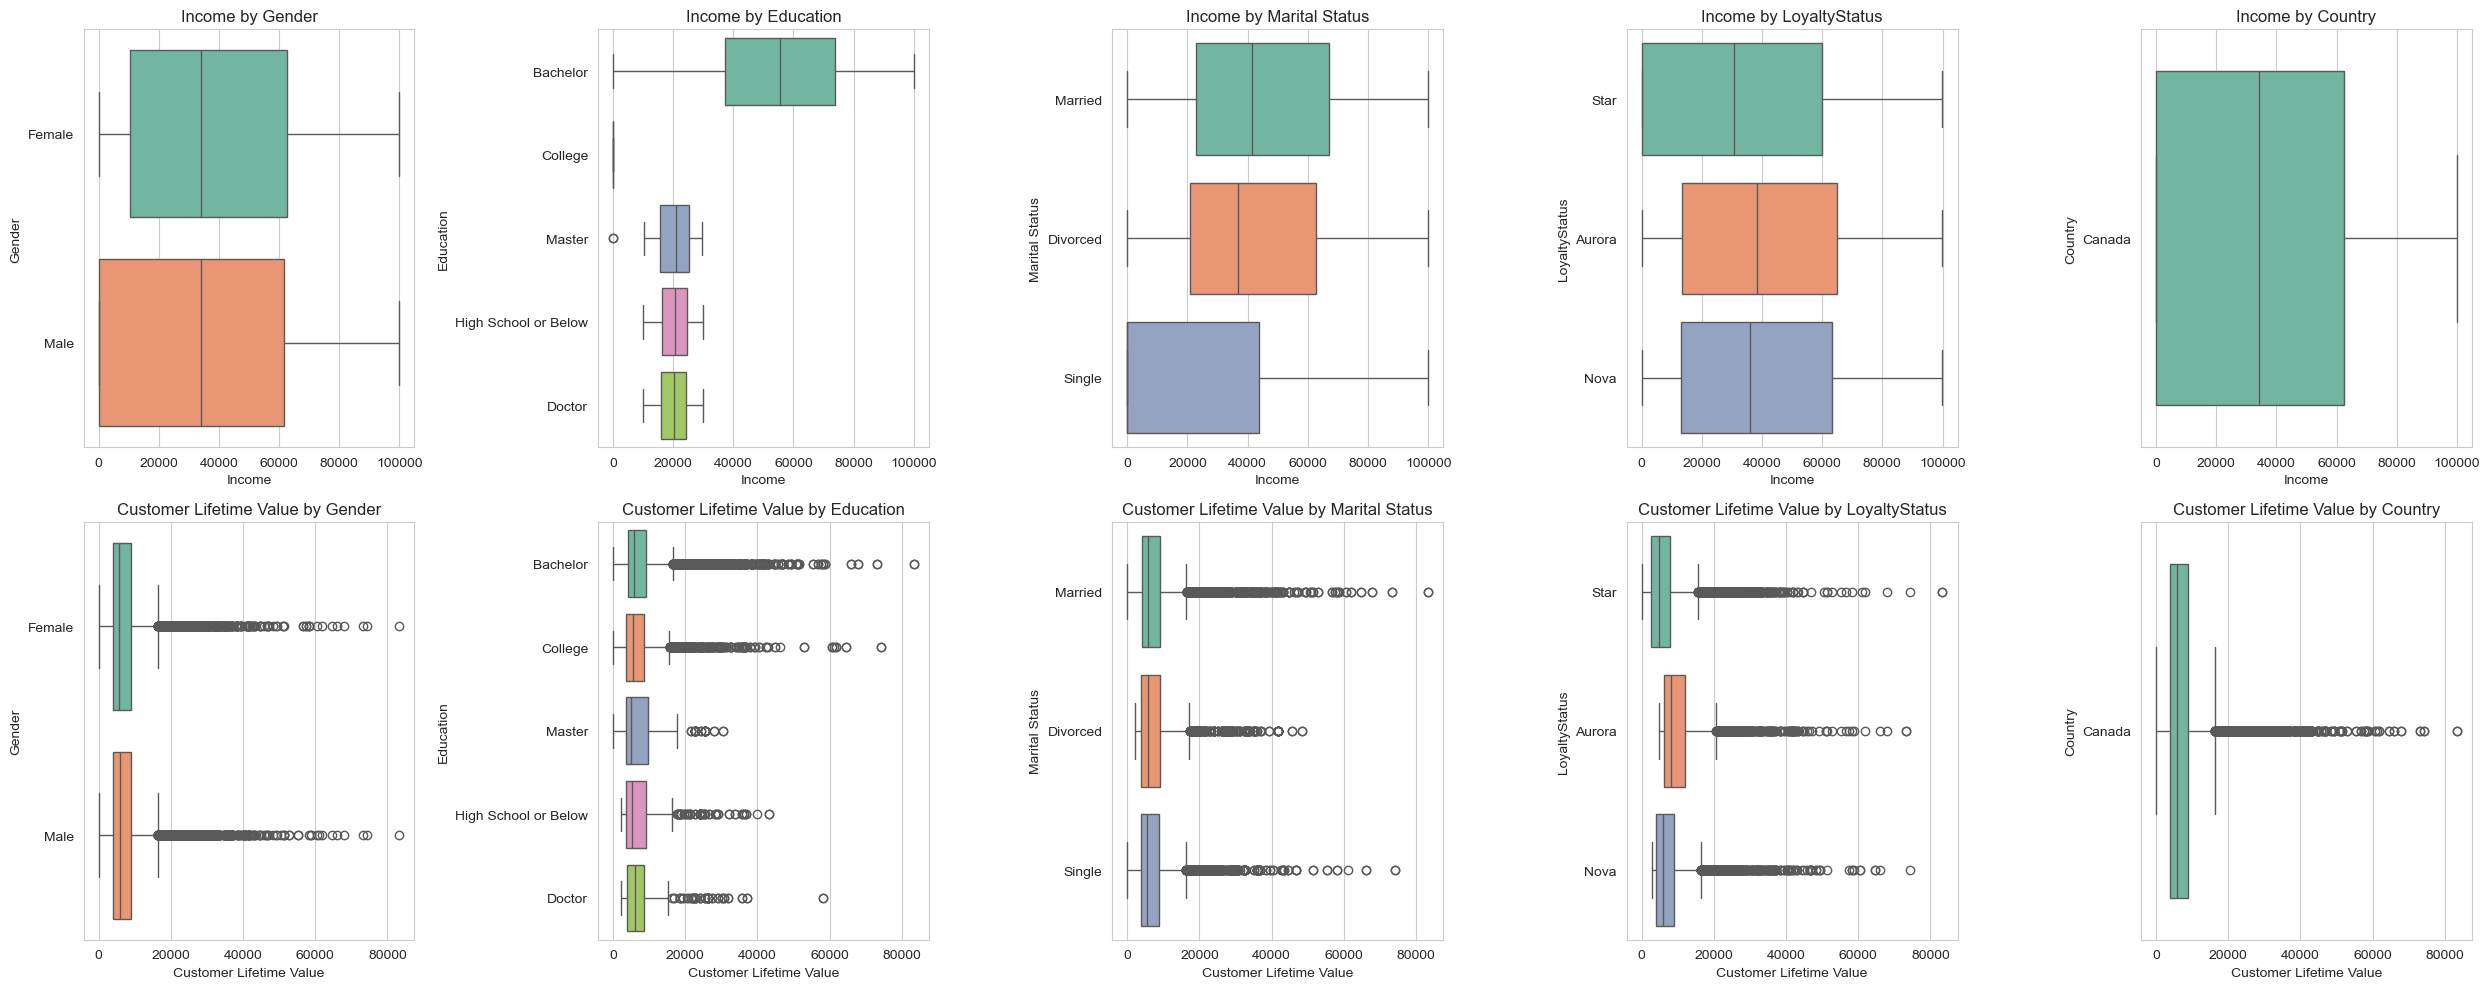

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

num_cols = ['Income', 'Customer Lifetime Value']
cat_cols = ['Gender', 'Education', 'Marital Status', 'LoyaltyStatus', 'Country']

# Determine grid size
n_rows = len(num_cols)
n_cols = len(cat_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))

for i, num in enumerate(num_cols):
    for j, cat in enumerate(cat_cols):
        ax = axes[i, j]
        sns.boxplot(
            x=num, 
            y=cat, 
            hue=cat,          # avoids palette warning
            data=CustomerDB, 
            ax=ax, 
            palette='Set2',
            orient='h',
            dodge=False
        )
        ax.set_title(f'{num} by {cat}')
        # safely remove legend if it exists
        if ax.get_legend() is not None:
            ax.get_legend().remove()
        ax.tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

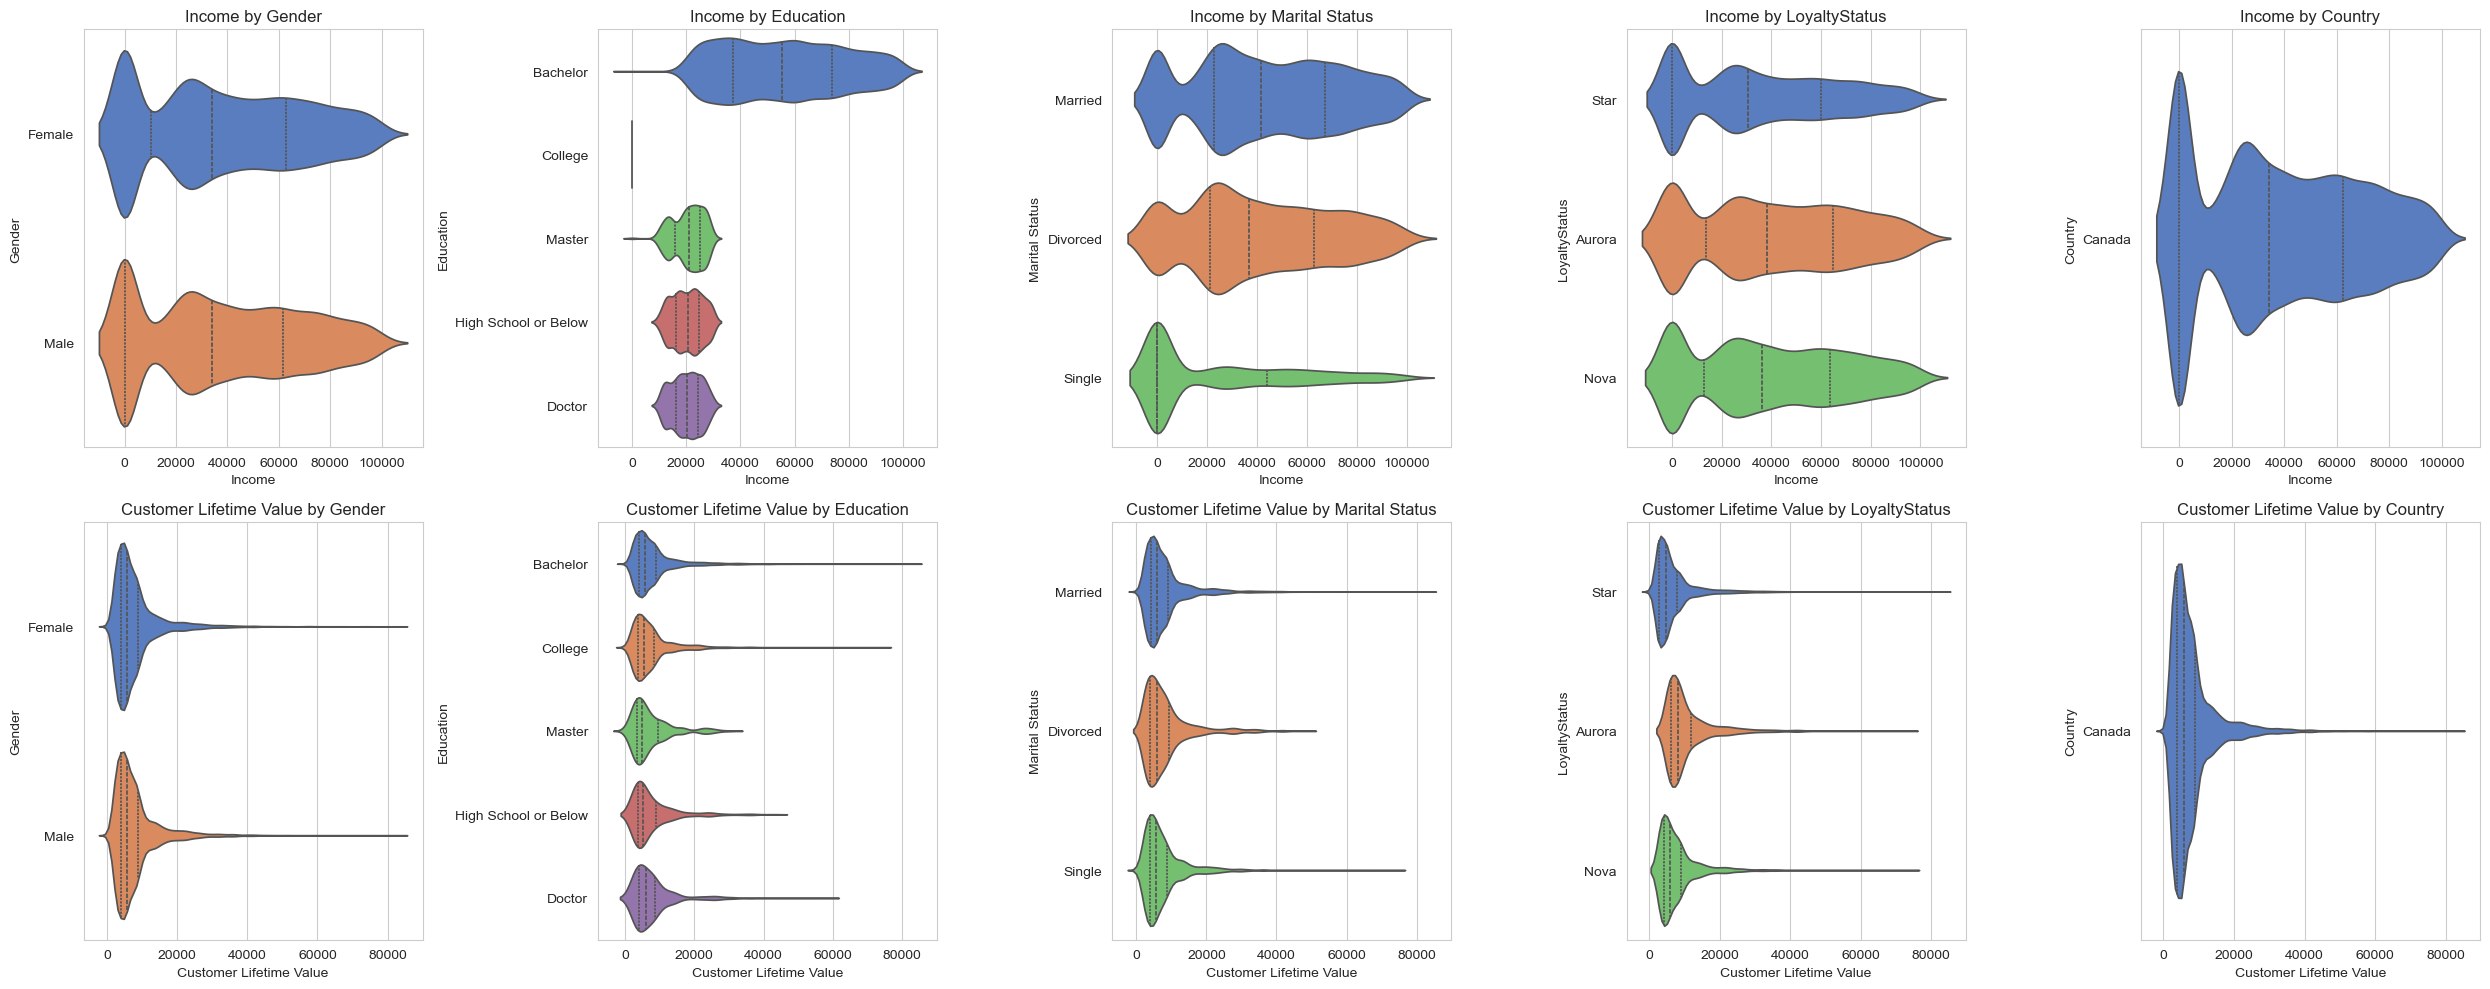

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

num_cols = ['Income', 'Customer Lifetime Value']
cat_cols = ['Gender', 'Education', 'Marital Status', 'LoyaltyStatus', 'Country']

# Determine grid size
n_rows = len(num_cols)
n_cols = len(cat_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))

for i, num in enumerate(num_cols):
    for j, cat in enumerate(cat_cols):
        ax = axes[i, j]
        sns.violinplot(
            x=num, 
            y=cat, 
            hue=cat,          # avoids palette warning
            data=CustomerDB, 
            ax=ax, 
            palette='muted', 
            orient='h',       # horizontal orientation
            dodge=False,      # avoid splitting by hue
            inner='quartile'  # show median & quartiles
        )
        ax.set_title(f'{num} by {cat}', fontsize=12)
        if ax.get_legend() is not None:
            ax.get_legend().remove()
        ax.tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

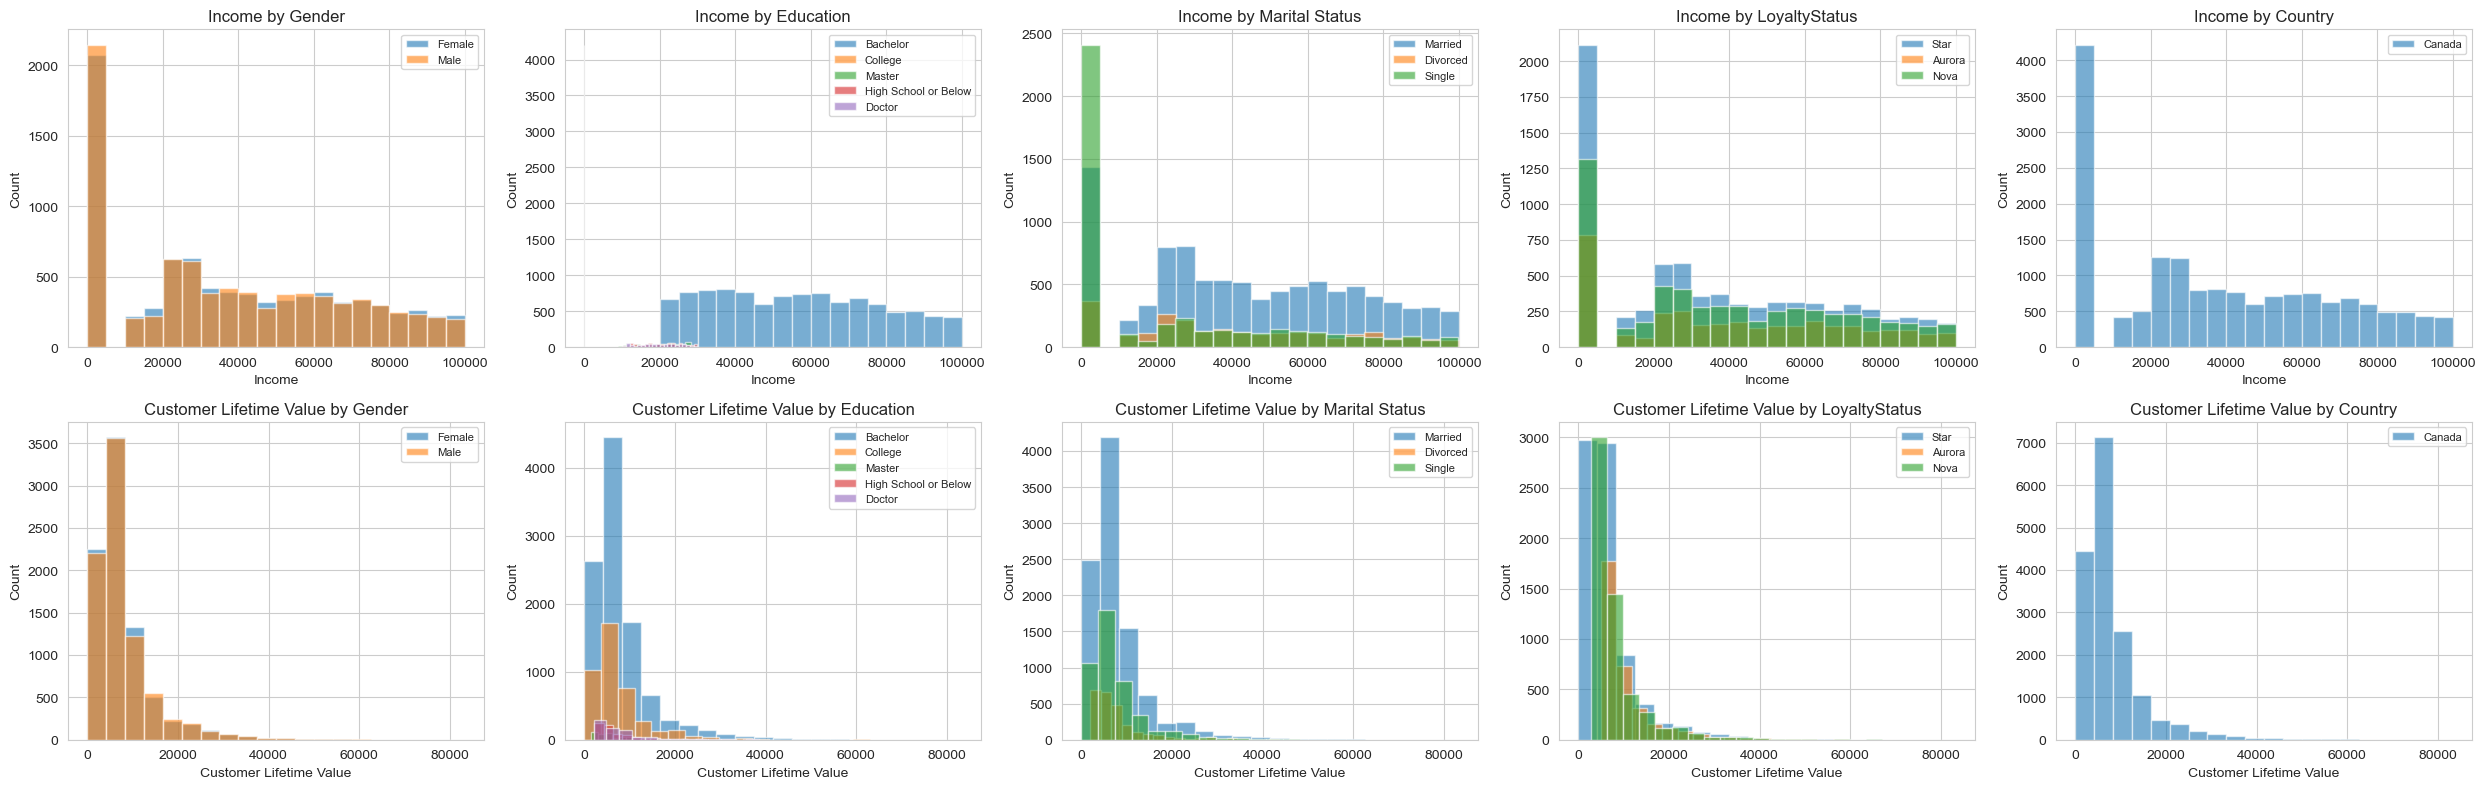

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

num_cols = ['Income', 'Customer Lifetime Value']
cat_cols = ['Gender', 'Education', 'Marital Status', 'LoyaltyStatus', 'Country']

# Grid layout
n_rows = len(num_cols)
n_cols = len(cat_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

for i, num in enumerate(num_cols):
    for j, cat in enumerate(cat_cols):
        ax = axes[i, j]
        categories = CustomerDB[cat].dropna().unique()
        for c in categories:
            subset = CustomerDB[CustomerDB[cat] == c]
            ax.hist(subset[num], bins=20, alpha=0.6, label=str(c))
        ax.set_title(f'{num} by {cat}', fontsize=12)
        ax.set_xlabel(num)
        ax.set_ylabel('Count')
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

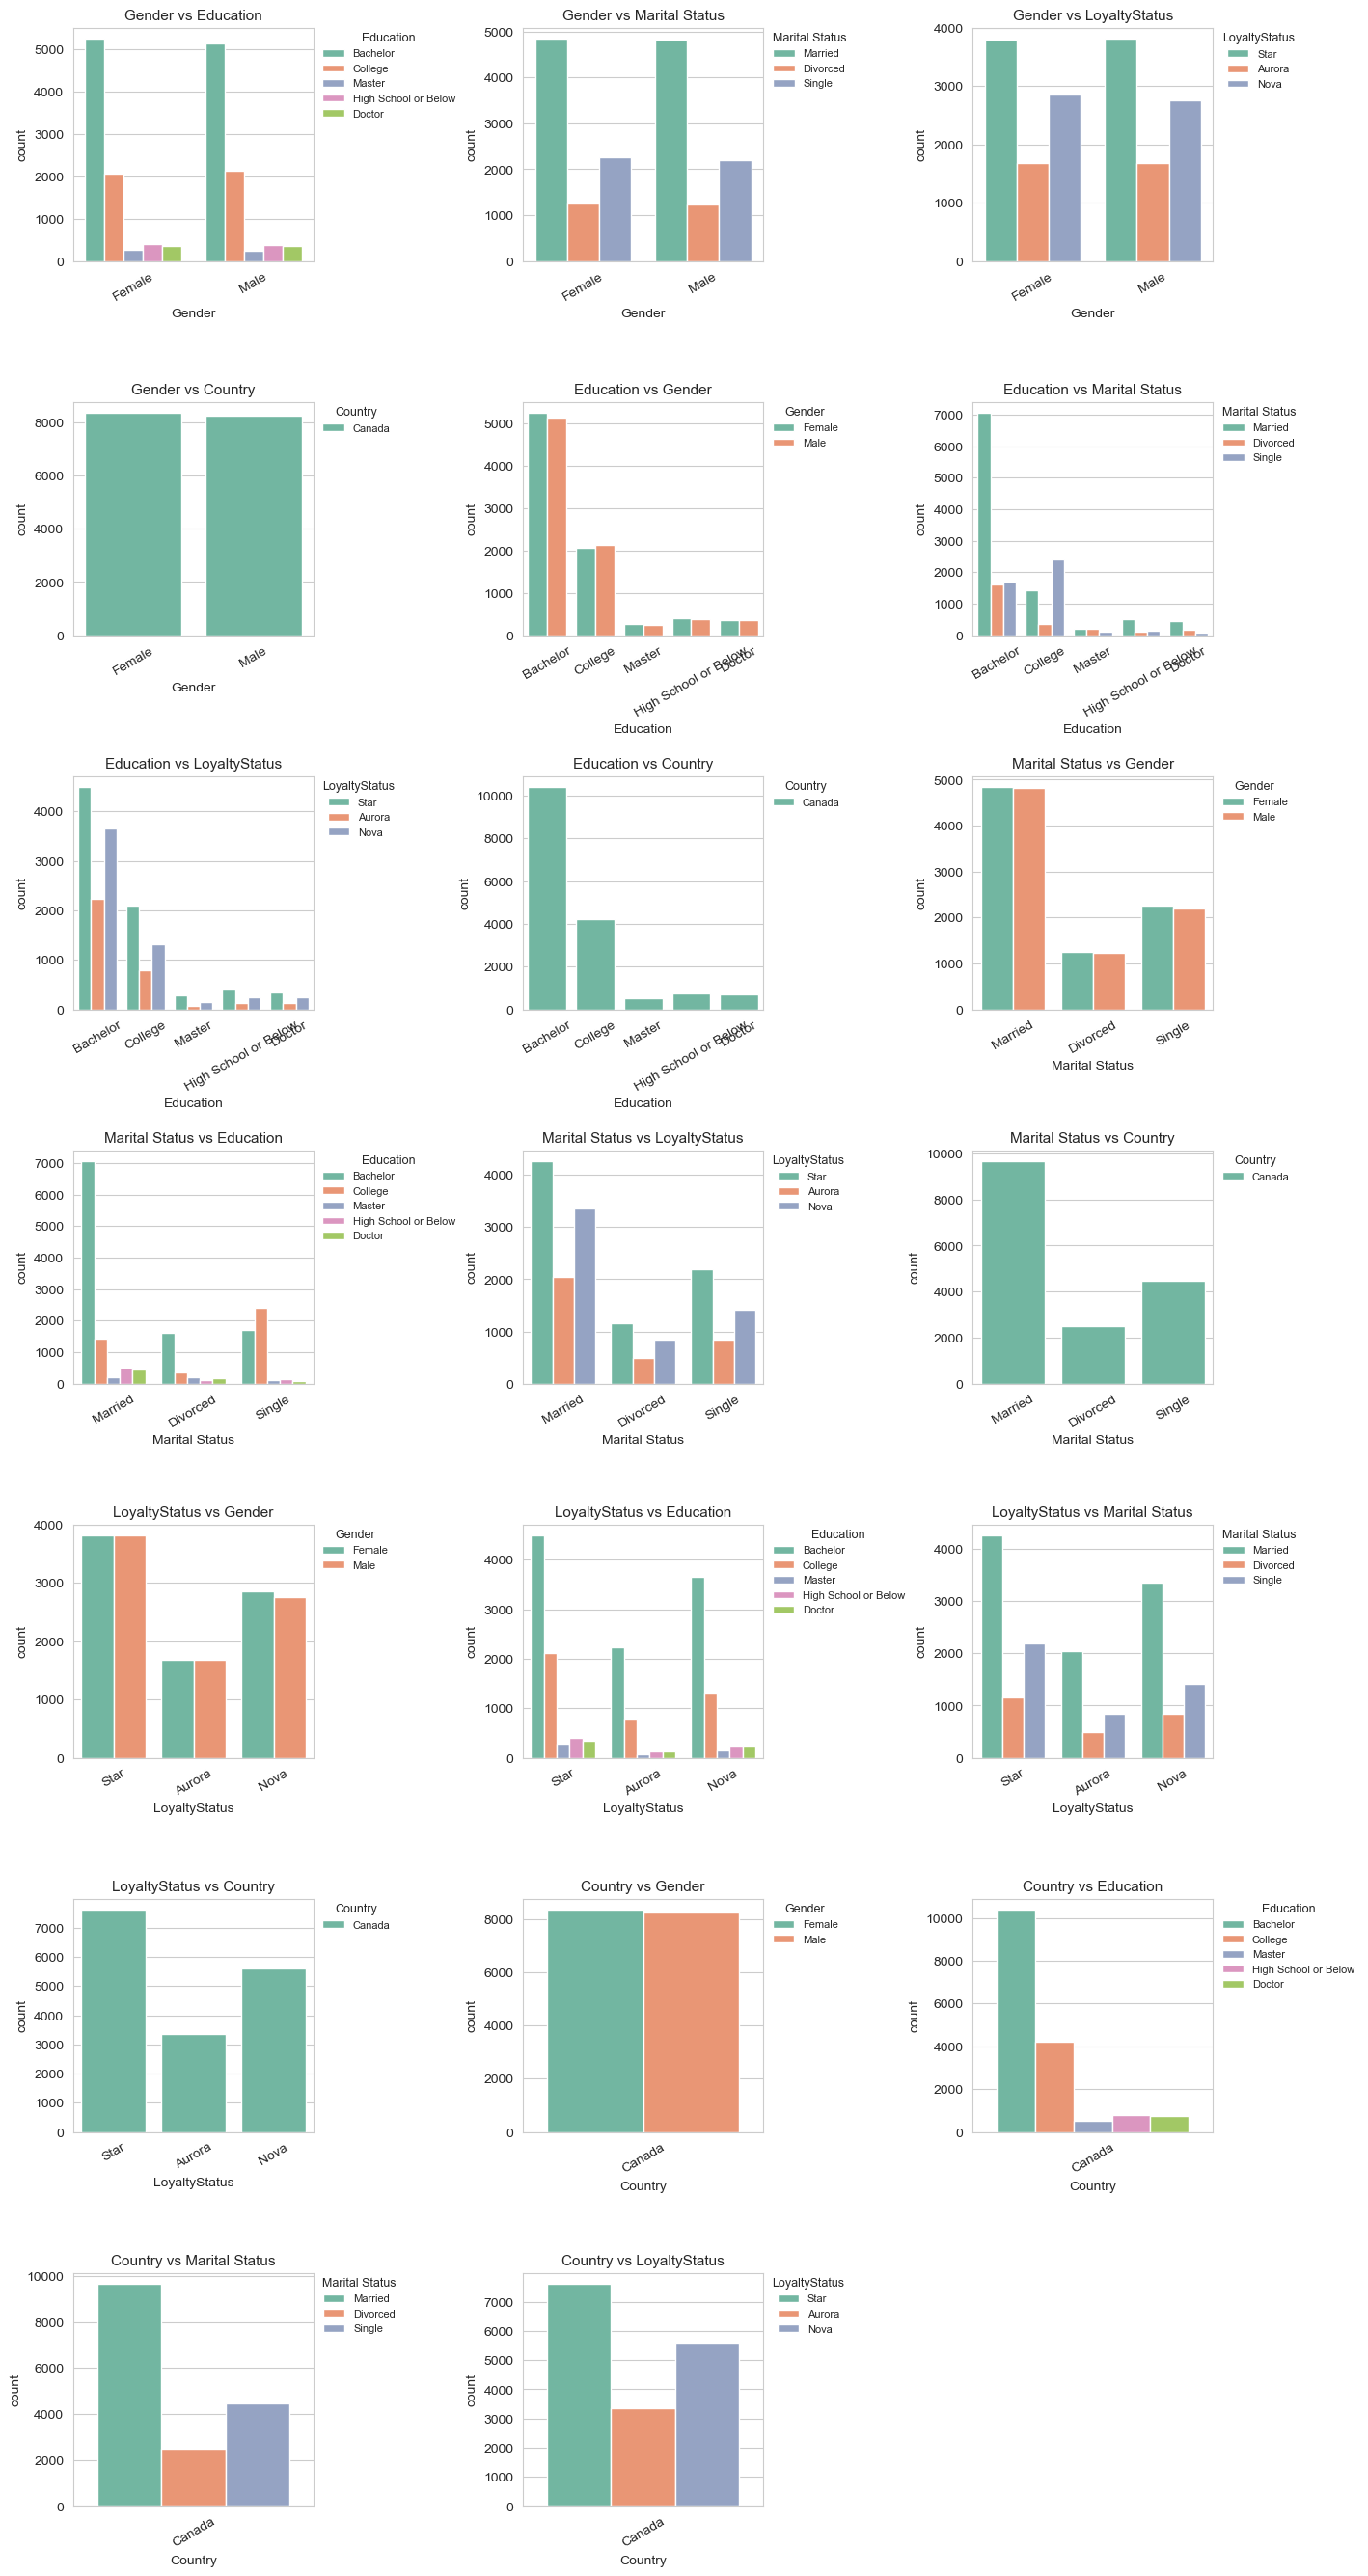

In [97]:
sns.set_style('whitegrid')

cat_cols = ['Gender', 'Education', 'Marital Status', 'LoyaltyStatus', 'Country']

# Calculate total number of plots (excluding same-variable pairs)
total_plots = len(cat_cols) * (len(cat_cols) - 1)

# Define grid size
n_cols = 3  # fewer columns makes plots more readable
n_rows = math.ceil(total_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

plot_idx = 0
for i, cat1 in enumerate(cat_cols):
    for j, cat2 in enumerate(cat_cols):
        if cat1 == cat2:
            continue
        ax = axes[plot_idx]
        sns.countplot(
            data=CustomerDB,
            x=cat1,
            hue=cat2,
            palette='Set2',
            ax=ax
        )
        ax.set_title(f'{cat1} vs {cat2}', fontsize=11)
        ax.tick_params(axis='x', rotation=30)

        # Move legend outside but below the title
        ax.legend(
            title=cat2,
            bbox_to_anchor=(1.02, 1),
            loc='upper left',
            borderaxespad=0,
            frameon=False,
            fontsize=8,
            title_fontsize=9
        )

        plot_idx += 1

# Remove unused subplots
for k in range(plot_idx, len(axes)):
    fig.delaxes(axes[k])

# Adjust spacing and layout automatically
plt.tight_layout(pad=2.0, w_pad=1.0, h_pad=2.0)
plt.subplots_adjust(top=0.95, right=0.85)  # leave space for legends
plt.show()


Relationships:

Gender is not a determining factor.

There are no major demographic differences among the loyalty status groups.

Customers with higher loyalty levels generally have higher education.

The married group is more represented in the higher loyalty categories.



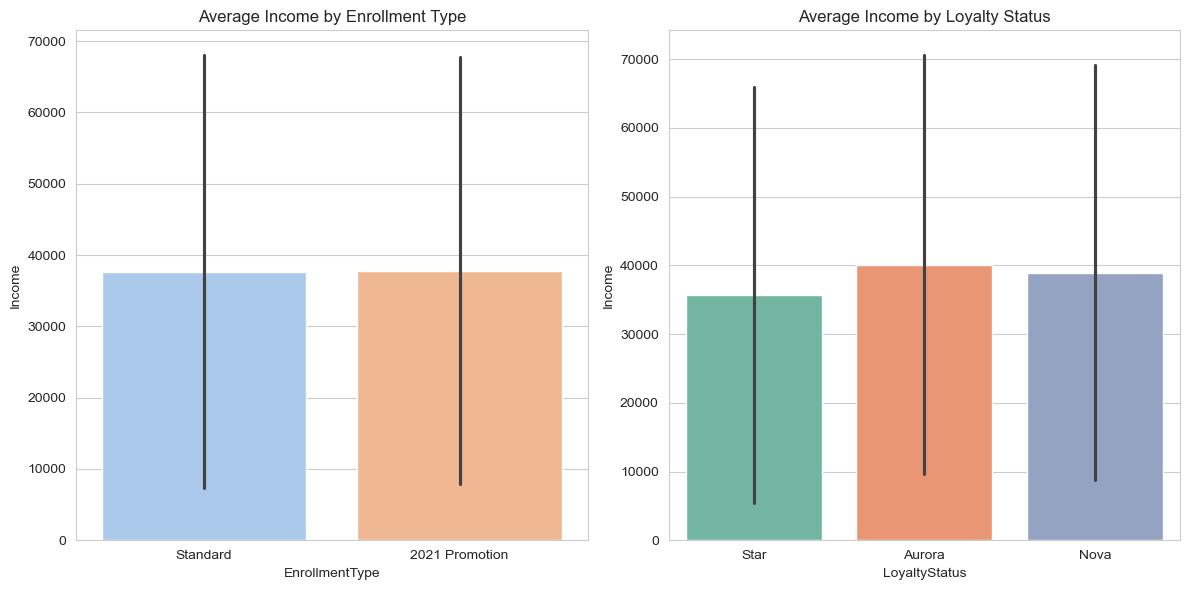

In [98]:
plt.figure(figsize=(12,6))

# EnrollmentType vs Income
plt.subplot(1, 2, 1)
sns.barplot(
    data=CustomerDB,
    x='EnrollmentType',
    y='Income',
    palette='pastel',
    ci='sd'
)
plt.title('Average Income by Enrollment Type')

# LoyaltyStatus vs Income
plt.subplot(1, 2, 2)
sns.barplot(
    data=CustomerDB,
    x='LoyaltyStatus',
    y='Income',
    palette='Set2',
    ci='sd'
)
plt.title('Average Income by Loyalty Status')

plt.tight_layout()
plt.show()


The average Income for both standard and 2021 promotion is almost identical

The error bars are quite long - indicates high variability 

Enrollment Type does not significantly influence income

For Loyalty Status, the error bars overlap substantially, meaning the differences are not statistically significant. There's no strong correlation between loyalty status and income, though Aurora and Nova members have a slightly higher average.

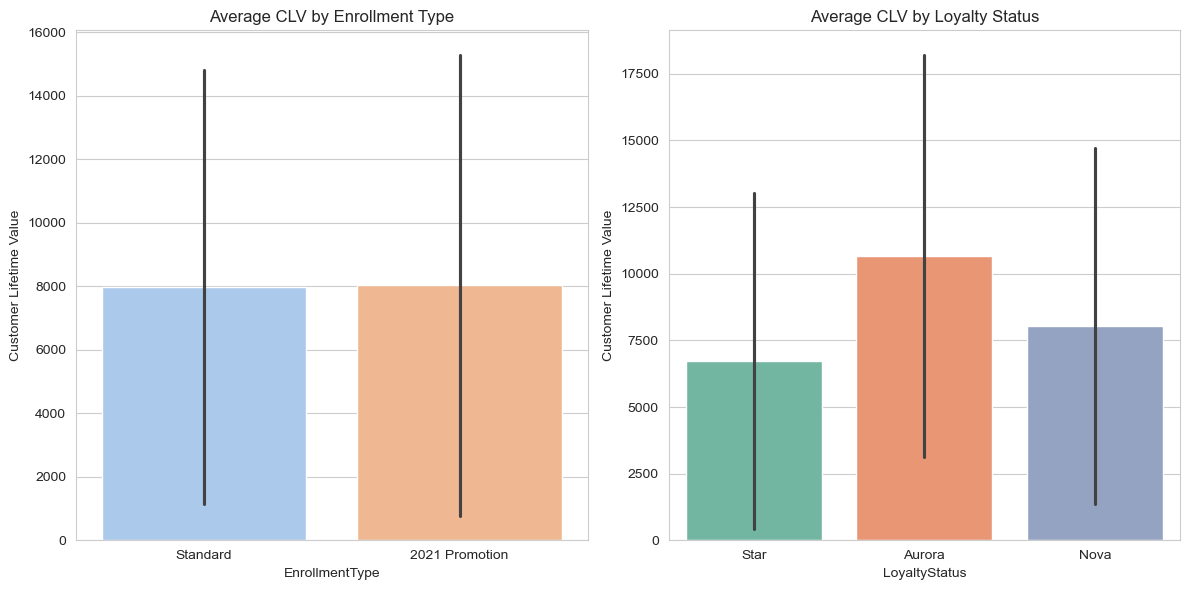

In [99]:
plt.figure(figsize=(12,6))

# EnrollmentType vs CLV
plt.subplot(1, 2, 1)
sns.barplot(
    data=CustomerDB,
    x='EnrollmentType',
    y='Customer Lifetime Value',
    palette='pastel',
    ci='sd'
)
plt.title('Average CLV by Enrollment Type')

# LoyaltyStatus vs CLV
plt.subplot(1, 2, 2)
sns.barplot(
    data=CustomerDB,
    x='LoyaltyStatus',
    y='Customer Lifetime Value',
    palette='Set2',
    ci='sd'
)
plt.title('Average CLV by Loyalty Status')

plt.tight_layout()
plt.show()


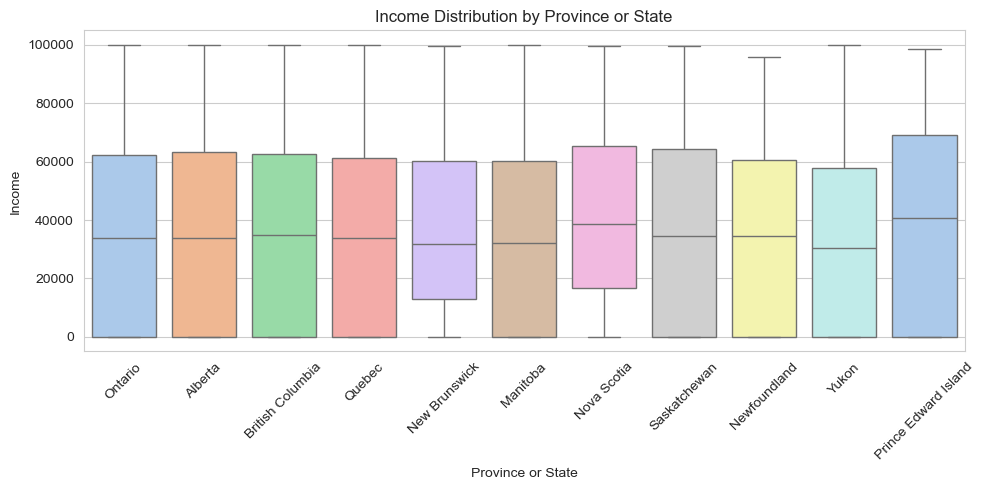

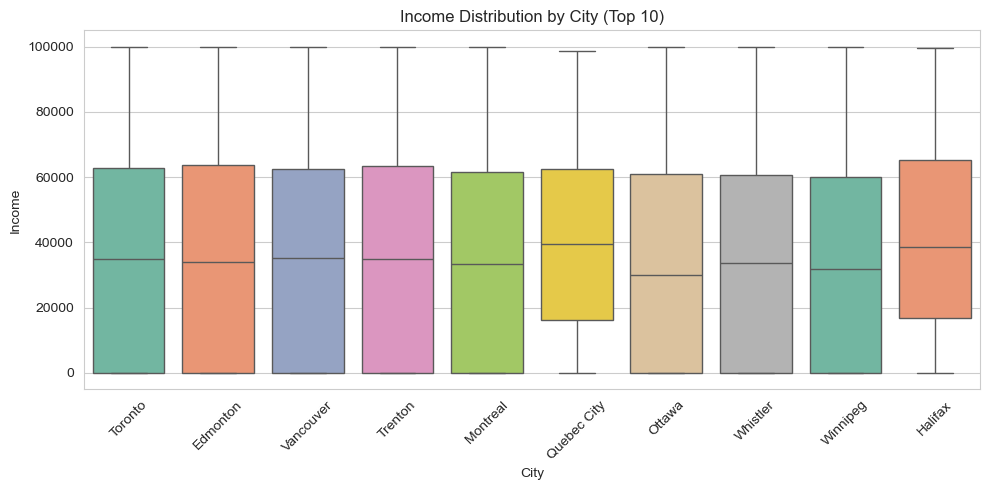

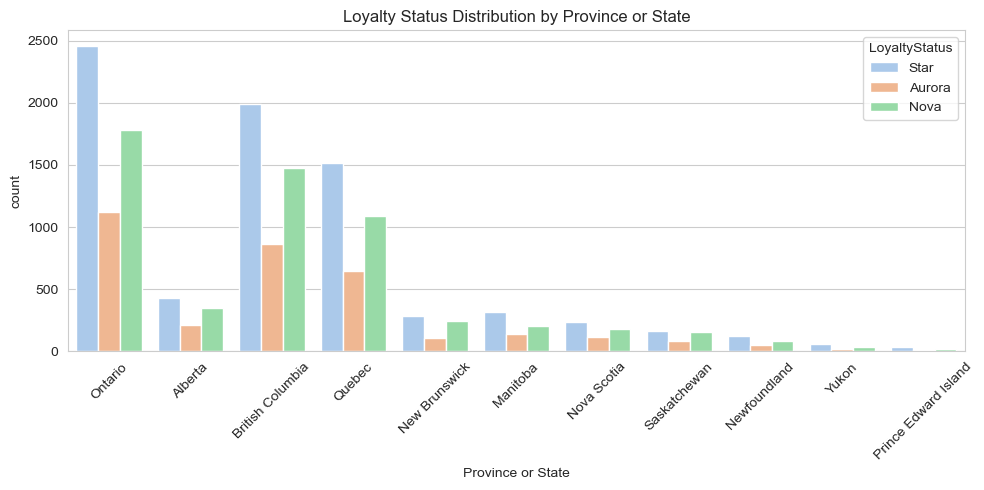

In [100]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

# Seleciona as 10 cidades com mais clientes
top_cities = (
    CustomerDB['City']
    .value_counts()
    .nlargest(10)
    .index
)

# Filtra apenas essas cidades
df_top = CustomerDB[CustomerDB['City'].isin(top_cities)]

# ===========================
# 1️⃣ Income por Province
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=CustomerDB,
    x='Province or State',
    y='Income',
    palette='pastel'
)
plt.title('Income Distribution by Province or State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ===========================
# 2️⃣ Income por City (Top 10)
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_top,
    x='City',
    y='Income',
    palette='Set2'
)
plt.title('Income Distribution by City (Top 10)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ===========================
# 3️⃣ LoyaltyStatus por Province
plt.figure(figsize=(10, 5))
sns.countplot(
    data=CustomerDB,
    x='Province or State',
    hue='LoyaltyStatus',
    palette='pastel'
)
plt.title('Loyalty Status Distribution by Province or State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The proportion of each status is equal, independently of the city, which means that does not influence anything.

## FlightsDB

### Univariate Analysis

#### Numerical Features

In [101]:
# Remove 'Loyalty#' from the list if it exists
numerical_columns_flights = [col for col in numerical_columns_flights if col != 'Loyalty#']

# Print unique values for each numeric column
for col in numerical_columns_flights:
    print(f'{col}: {FlightsDB[col].unique()}')


Year: [2021 2020 2019]
Month: [12  6  5  4  3  2  1 11 10  9  8  7]
NumFlights: [ 2  0 10 16  9 12 17  6 11  7  3 13 14  8  5  4  1 15 18 20 19 21]
NumFlightsWithCompanions: [ 2  0  3  4  7  9  5  6  1  8 10 11]
DistanceKM: [ 9384.      0.  14745.  ... 11732.4 31998.6 26789.4]
PointsAccumulated: [ 938    0 1474 ... 4107   23   21]
PointsRedeemed: [   0 3213 4638 ... 5691 4598 5527]
DollarCostPointsRedeemed: [ 0.  32.  46.  40.  51.  62.  48.  50.  59.  43.  37.  41.  53.  56.
 31.  30.  63.  33.  44.  58.  60.  57.  36.  29.  42.  54.  45.  35.
 67.  39.  65.  34.  61.  66.  38.  47.  55.  68.  69.  64.  52.  49.
 71.  72.  27.  28.  70.  25.  26.  24.  23.  21.  22.  74.  73.  32.4
 36.9 27.9 21.6 26.1 31.5 33.3 22.5 40.5 28.8 37.8 24.3 20.7 29.7 30.6
 35.1 25.2 23.4 34.2 41.4 39.6 19.8 38.7 18.9 51.3 42.3 52.2 50.4 45.9
 47.7 48.6 43.2 46.8 44.1 49.5 53.1 57.6 60.3 62.1 54.9 58.5 55.8 56.7
 63.9 61.2 64.8 59.4 65.7 66.6]


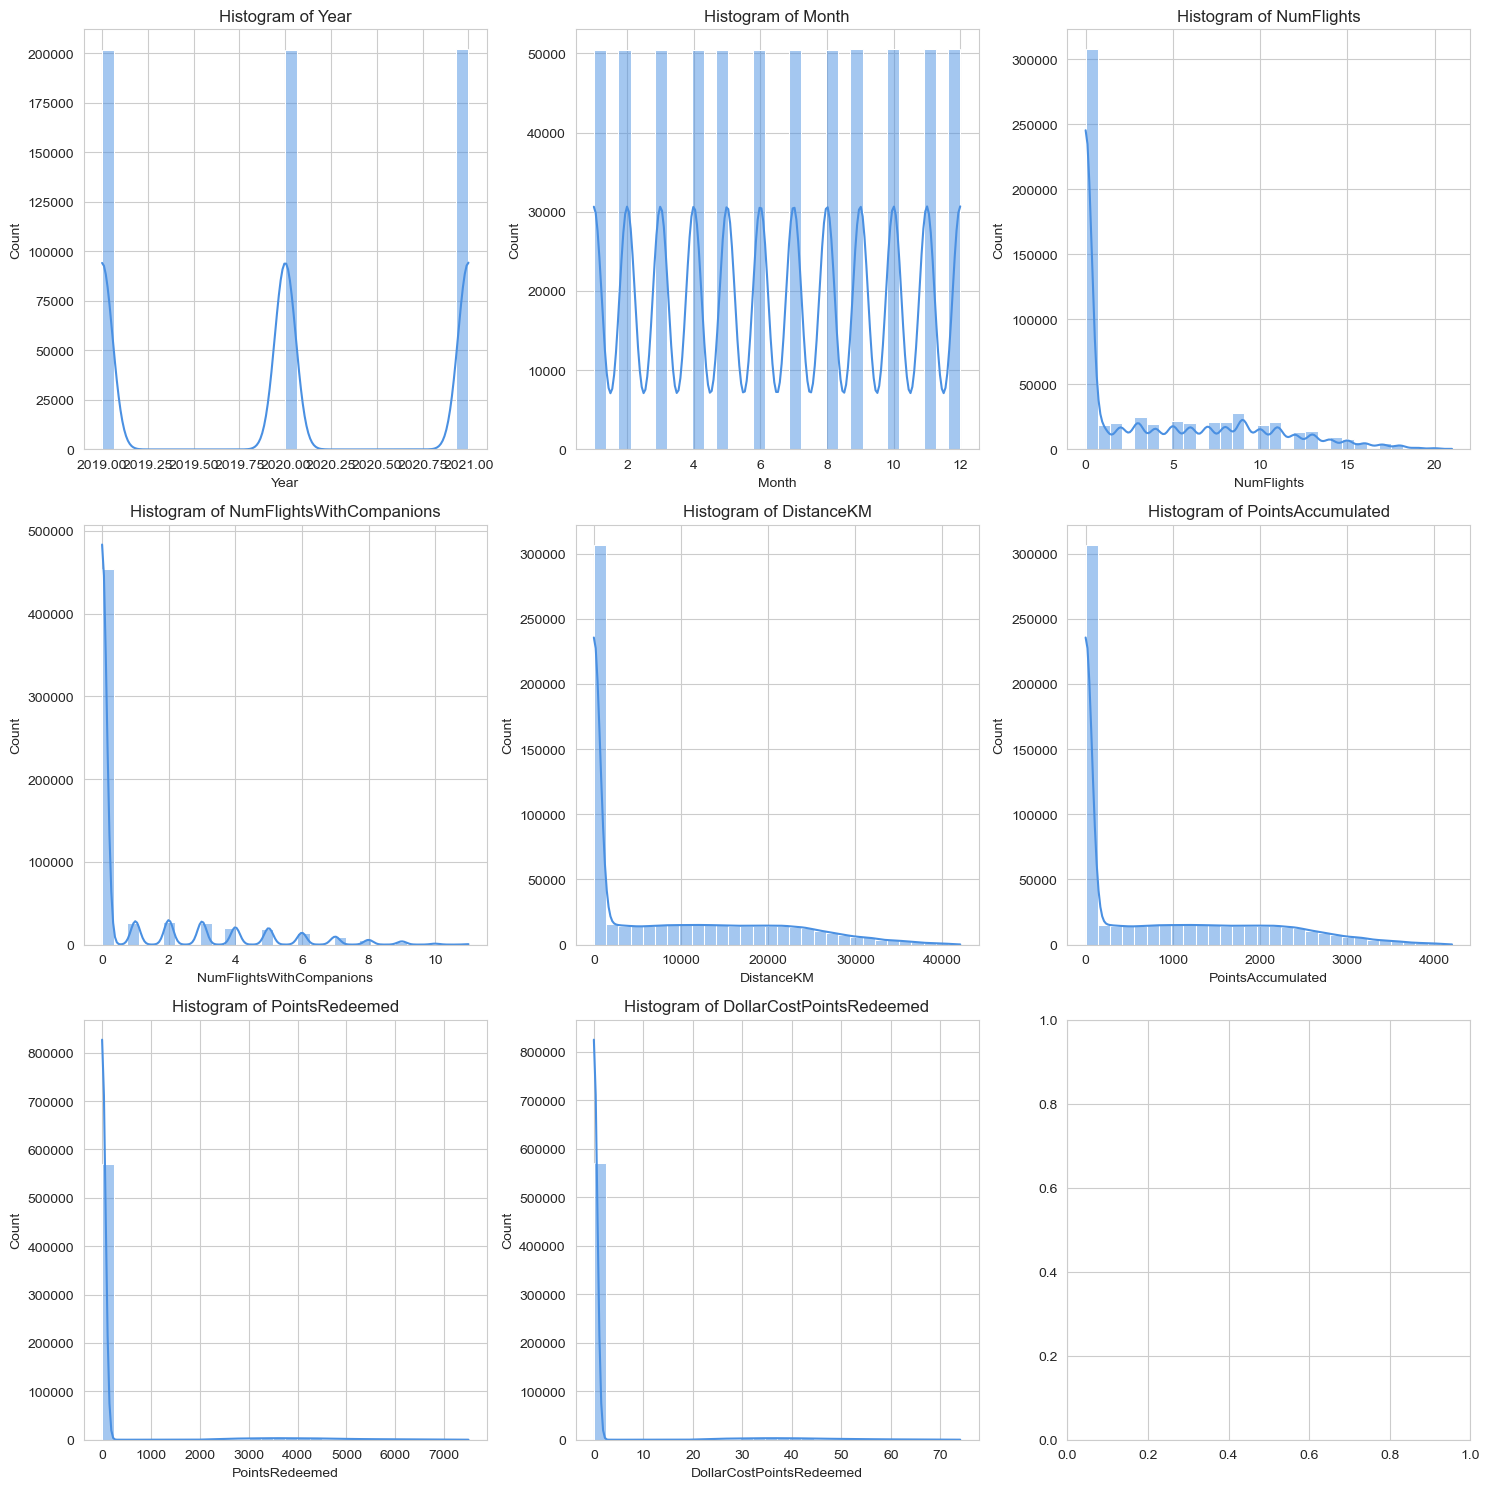

In [102]:
num_cols = len(numerical_columns_flights)
num_rows= (num_cols + 2)//3
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_columns_flights):
    sns.histplot(FlightsDB[col], bins=30, kde=True, color='#4A90E2', ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

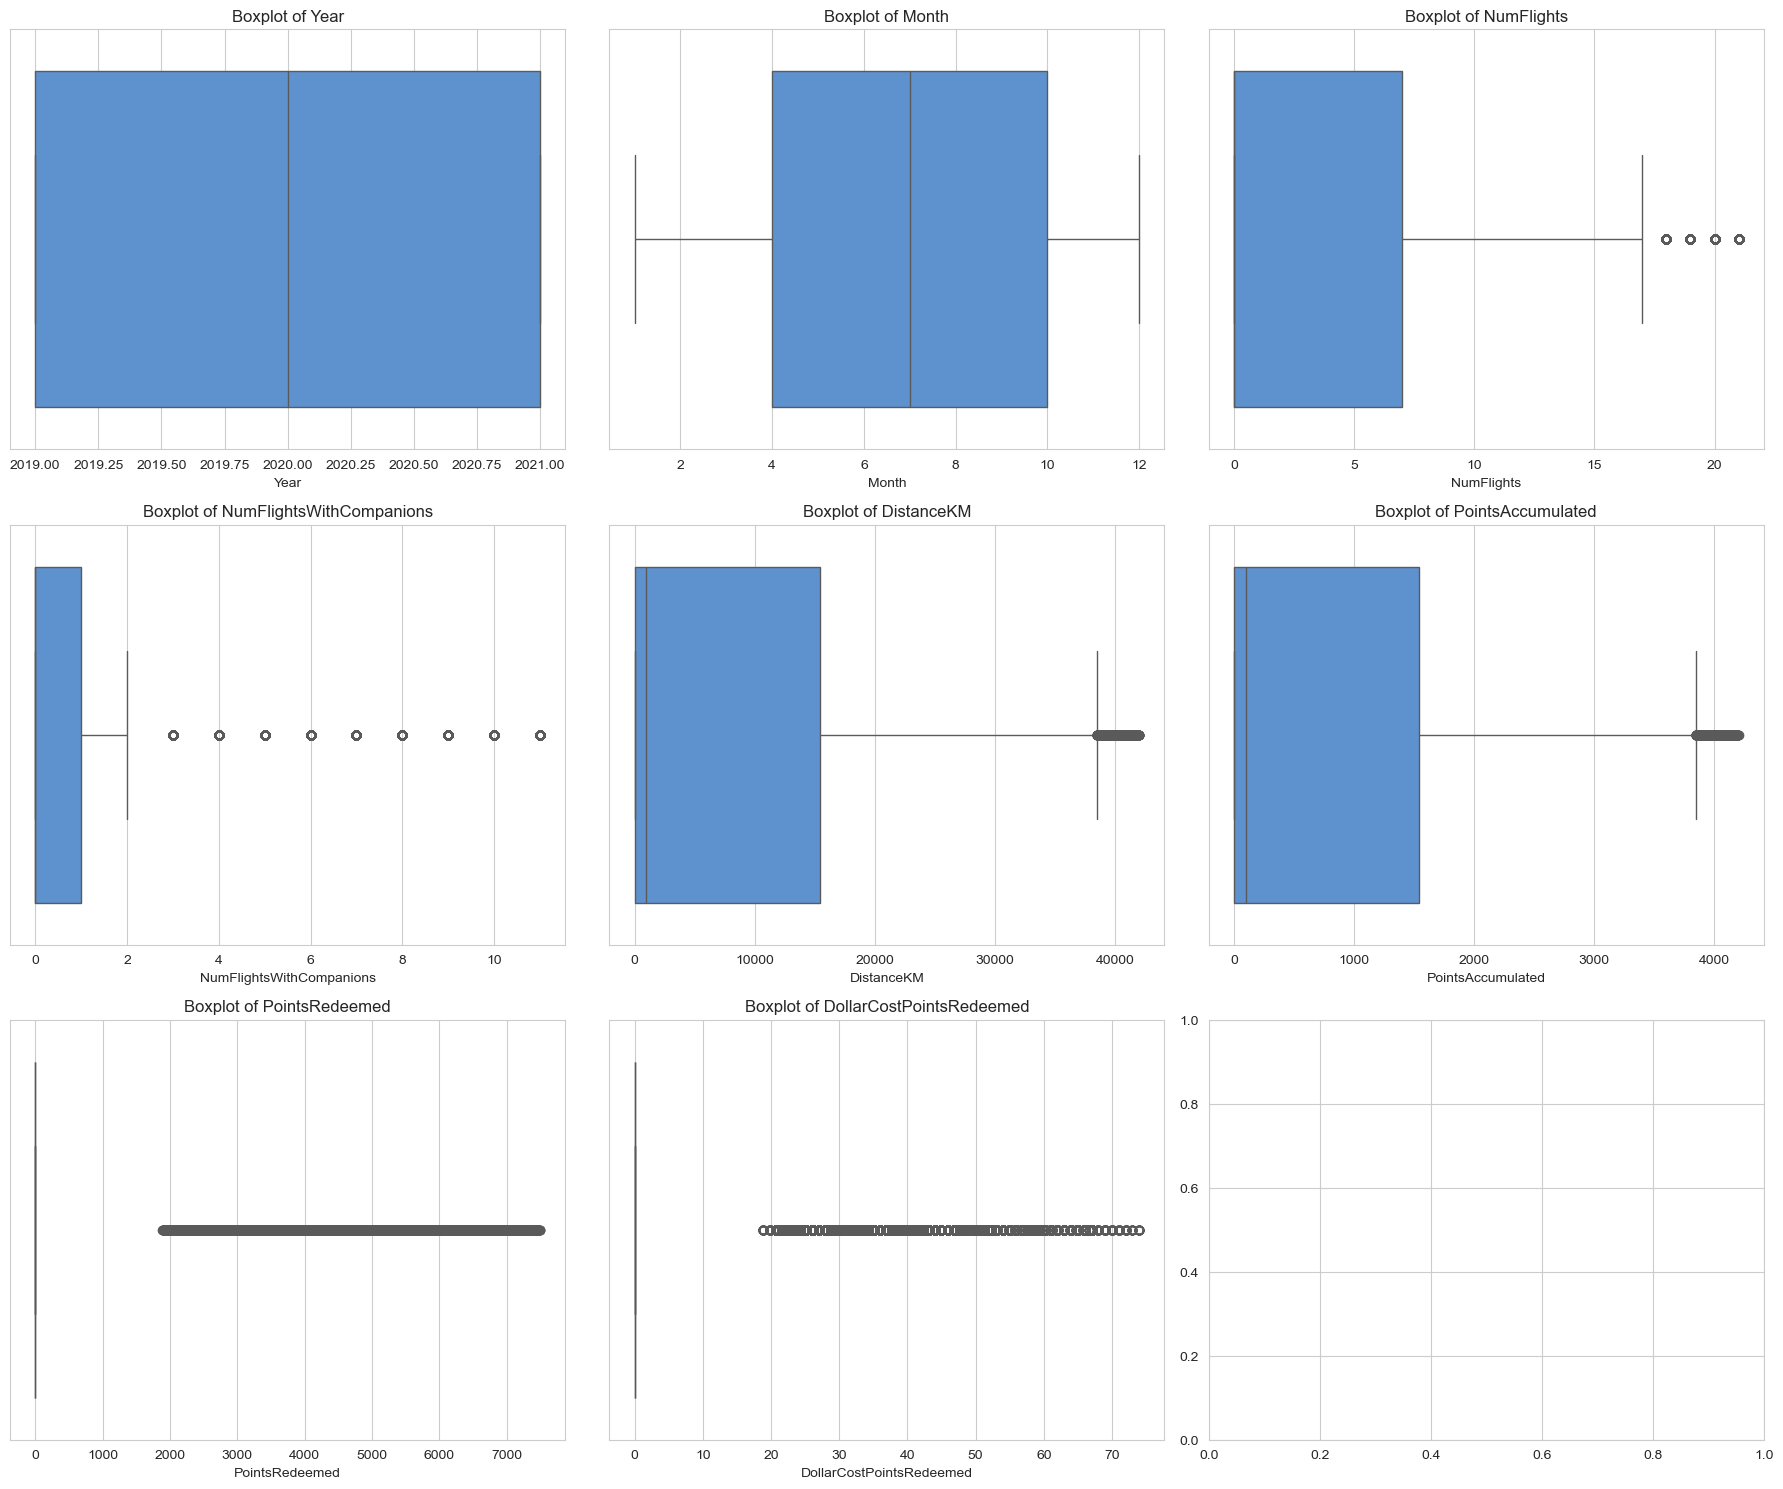

In [103]:
num_vars = 8
num_cols = 3
num_rows = (num_vars + num_cols - 1) // num_cols  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 5*num_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_columns_flights):
    sns.boxplot(x=FlightsDB[col], color='#4A90E2', ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

##### Outliers

In [104]:
outliers = ['NumFlights', 'NumFlightsWithCompanions', 'DistanceKM']

outlier_bounds = {}
outliers_data = {}

for col in outliers:
    Q1 = FlightsDB[col].quantile(0.25)
    Q3 = FlightsDB[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_bounds[col] = (lower_bound, upper_bound)
    
    # Get outliers for this column
    outliers_data[col] = FlightsDB[(FlightsDB[col] < lower_bound) | (FlightsDB[col] > upper_bound)].sort_values(by=col, ascending=False)

# Print results
for col in outliers:
    lb, ub = outlier_bounds[col]
    print(f"{col} - Lower bound: {lb}, Upper bound: {ub}")
    print(f"Number of outliers in {col}: {len(outliers_data[col])}\n")


NumFlights - Lower bound: -10.5, Upper bound: 17.5
Number of outliers in NumFlights: 6919

NumFlightsWithCompanions - Lower bound: -1.5, Upper bound: 2.5
Number of outliers in NumFlightsWithCompanions: 97348

DistanceKM - Lower bound: -23113.35, Upper bound: 38522.25
Number of outliers in DistanceKM: 1830



In [105]:
for col, df_outliers in outliers_data.items():
    print(f"Outliers for column: {col}")
    
    #See the first and last 2 rows for each outlier column
    values = pd.concat([df_outliers[col].head(2), df_outliers[col].tail(2)])
    
    print(values)
    print("\n" + "-"*50 + "\n")


Outliers for column: NumFlights
227374    21
380969    21
522517    18
522607    18
Name: NumFlights, dtype: int64

--------------------------------------------------

Outliers for column: NumFlightsWithCompanions
383022    11
199782    11
608367     3
403310     3
Name: NumFlightsWithCompanions, dtype: int64

--------------------------------------------------

Outliers for column: DistanceKM
390460    42040.0
227550    42013.0
118773    38527.0
211459    38526.0
Name: DistanceKM, dtype: float64

--------------------------------------------------



In [106]:
outliers = ['PointsAccumulated', 'PointsRedeemed', 'DollarCostPointsRedeemed']

outlier_bounds = {}
outliers_data = {}

for col in outliers:
    Q1 = FlightsDB[col].quantile(0.25)
    Q3 = FlightsDB[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_bounds[col] = (lower_bound, upper_bound)
    
    # Get outliers for this column
    outliers_data[col] = FlightsDB[(FlightsDB[col] < lower_bound) | (FlightsDB[col] > upper_bound)].sort_values(by=col, ascending=False)

# Print results
for col in outliers:
    lb, ub = outlier_bounds[col]
    print(f"{col} - Lower bound: {lb}, Upper bound: {ub}")
    print(f"Number of outliers in {col}: {len(outliers_data[col])}\n")


PointsAccumulated - Lower bound: -2310.0, Upper bound: 3850.0
Number of outliers in PointsAccumulated: 1842

PointsRedeemed - Lower bound: 0.0, Upper bound: 0.0
Number of outliers in PointsRedeemed: 35393

DollarCostPointsRedeemed - Lower bound: 0.0, Upper bound: 0.0
Number of outliers in DollarCostPointsRedeemed: 35393



In [107]:
for col, df_outliers in outliers_data.items():
    print(f"Outliers for column: {col}")
    
    #See the first and last 2 rows for each outlier column
    values = pd.concat([df_outliers[col].head(2), df_outliers[col].tail(2)])
    
    print(values)
    print("\n" + "-"*50 + "\n")


Outliers for column: PointsAccumulated
390460    4204
227550    4201
233268    3851
1166      3851
Name: PointsAccumulated, dtype: int64

--------------------------------------------------

Outliers for column: PointsRedeemed
213042    7496
371432    7496
431868    1894
422605    1890
Name: PointsRedeemed, dtype: int64

--------------------------------------------------

Outliers for column: DollarCostPointsRedeemed
369122    74.0
369358    74.0
425032    18.9
438781    18.9
Name: DollarCostPointsRedeemed, dtype: float64

--------------------------------------------------



### Analysing Customers Behaviour and Sazonality in FlightsDB

#### Agg_Sum

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# Aggregate totals per customer
FlightsDB=FlightsDB.copy()

agg_sum = FlightsDB.groupby('Loyalty#').agg({
    'NumFlights': 'sum',
    'NumFlightsWithCompanions':'sum',
    'PointsAccumulated': 'sum',
    'PointsRedeemed': 'sum',
    'DistanceKM': 'sum',
    'DollarCostPointsRedeemed': 'sum'
}).reset_index()

# Rename columns
agg_sum.rename(columns={
    'NumFlights': 'TotalFlights',
    'NumFlightsWithCompanions':'TotalFlightsWithCompanion',
    'PointsAccumulated': 'TotalPointsAccumulated',
    'PointsRedeemed': 'TotalPointsRedeemed',
    'DistanceKM': 'TotalDistanceKM',
    'DollarCostPointsRedeemed': 'TotalDollarCostPointsRedeemed'
}, inplace=True)


In [109]:
flight_counts = agg_sum['TotalFlights'].value_counts().sort_index()

flight_percentages = (flight_counts / flight_counts.sum()) * 100

freq_table = pd.DataFrame({
    'NumFlights': flight_counts.index,
    'Count': flight_counts.values,
    'Percentage': flight_percentages.values
})

freq_table_sorted = freq_table.sort_values(by='Percentage', ascending=False)

freq_table_sorted.head()

NumFlights  Count  Percentage
0             0   1501    8.968154
187         187    117    0.699050
206         206    116    0.693075
193         193    115    0.687100
181         181    114    0.681126

In [110]:
# Ratio of points redeemed vs points accumulated
agg_sum['PointsRedeemedRatio'] = agg_sum['TotalPointsRedeemed'] / agg_sum['TotalPointsAccumulated']

# Ratio of flights with companions vs total flights
agg_sum['FlightsWithCompanionsRatio'] = agg_sum['TotalFlightsWithCompanion'] / agg_sum['TotalFlights']

# Average distance per flight
agg_sum['AvgDistancePerFlight'] = np.where(
    agg_sum['TotalFlights'] == 0,
    np.nan,
    agg_sum['TotalDistanceKM'] / agg_sum['TotalFlights']
)

# Average points accumulated per flight
agg_sum['AvgPointsPerFlight'] = np.where(
    agg_sum['TotalFlights'] == 0,
    np.nan,
    agg_sum['TotalPointsAccumulated'] / agg_sum['TotalFlights']
)

# Average points redeemed per flight
agg_sum['AvgPointsRedeemedPerFlight'] = np.where(
    agg_sum['TotalFlights'] == 0,
    np.nan,
    agg_sum['TotalPointsRedeemed'] / agg_sum['TotalFlights']
)



#### Agg_mean

In [111]:
import pandas as pd

FlightsDB = FlightsDB.copy()
agg_mean = FlightsDB.groupby('Loyalty#').agg({
    'NumFlights': 'mean',                  
    'NumFlightsWithCompanions': 'mean',    
    'PointsAccumulated': 'mean',            
    'PointsRedeemed': 'mean',               
    'DollarCostPointsRedeemed': 'mean',     
    'DistanceKM': 'mean'                    
}).reset_index()


agg_mean.rename(columns={
    'NumFlights': 'AvgMonthlyFlights',
    'NumFlightsWithCompanions': 'AvgFlightsWithCompanions',
    'PointsAccumulated': 'AvgPointsAccumulated',
    'PointsRedeemed': 'AvgPointsRedeemed',
    'DollarCostPointsRedeemed': 'AvgDollarCostPointsRedeemed',
    'DistanceKM': 'AvgDistanceKM'
}, inplace=True)

max_flights = agg_mean['AvgMonthlyFlights'].max()

bins = [0, 1, 3, 5, 10, max_flights+1]
labels = ['0-1', '1-3', '3-5', '5-10', '10+']

agg_mean['FlightRange'] = pd.cut(
    agg_mean['AvgMonthlyFlights'], 
    bins=bins, 
    labels=labels, 
    right=False
)

flight_range_counts = agg_mean['FlightRange'].value_counts().sort_index()

flight_range_percent = (flight_range_counts / flight_range_counts.sum()) * 100

flight_summary = pd.DataFrame({
    'FlightRange': flight_range_counts.index,
    'NumberOfCustomers': flight_range_counts.values,
    'Percentage': flight_range_percent.values
})

print(flight_summary)



  FlightRange  NumberOfCustomers  Percentage
0         0-1               2827   16.890721
1         1-3               2523   15.074386
2         3-5               5135   30.680528
3        5-10               6252   37.354365
4         10+                  0    0.000000


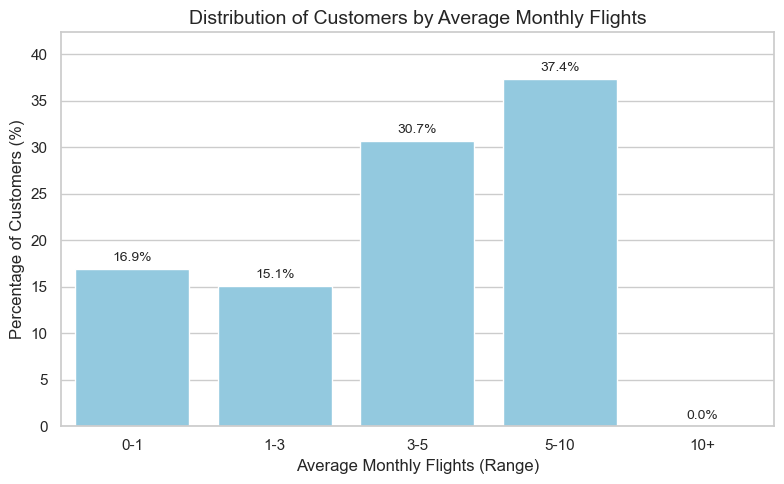

In [112]:
sns.set(style='whitegrid')

plt.figure(figsize=(8,5))

sns.barplot(
    x='FlightRange',
    y='Percentage',
    data=flight_summary,
    color='skyblue' 
)

plt.xlabel('Average Monthly Flights (Range)', fontsize=12)
plt.ylabel('Percentage of Customers (%)', fontsize=12)
plt.title('Distribution of Customers by Average Monthly Flights', fontsize=14)
plt.ylim(0, flight_summary['Percentage'].max() + 5)  

for index, row in flight_summary.iterrows():
    plt.text(index, row['Percentage'] + 0.5, f"{row['Percentage']:.1f}%", 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [113]:
agg_mean['AvgFlightsWithCompanions'] = pd.to_numeric(
    agg_mean['AvgFlightsWithCompanions'], errors='coerce'
).fillna(0)

max_val = agg_mean['AvgFlightsWithCompanions'].max()

bins = [0, 1, 3, 5, 10]
if max_val > 10:
    bins.append(max_val + 1) 
else:
    bins.append(11) 

labels = ['0-1', '1-3', '3-5', '5-10', '10+']

agg_mean['FlightsWithCompanionsRange'] = pd.cut(
    agg_mean['AvgFlightsWithCompanions'],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
)

counts = agg_mean['FlightsWithCompanionsRange'].value_counts().sort_index()

percent = (counts / counts.sum()) * 100

summary = pd.DataFrame({
    'FlightsWithCompanionsRange': counts.index,
    'NumberOfCustomers': counts.values,
    'Percentage': percent.values
})

print(summary)


  FlightsWithCompanionsRange  NumberOfCustomers  Percentage
0                        0-1               8632   51.574356
1                        1-3               8097   48.377845
2                        3-5                  8    0.047798
3                       5-10                  0    0.000000
4                        10+                  0    0.000000


In [114]:
num_customers_with_companions = (agg_mean['AvgFlightsWithCompanions'] > 0).sum()

total_customers = agg_mean.shape[0]

percent_with_companions = (num_customers_with_companions / total_customers) * 100

print(f"{percent_with_companions:.2f}% of customers have taken at least one flight with companions.")


89.11% of customers have taken at least one flight with companions.


#### New FlightsDB

In [115]:
FlightsDB_agg = pd.merge(agg_sum, agg_mean, how='inner', on='Loyalty#')
FlightsDB_agg

Loyalty#  TotalFlights  TotalFlightsWithCompanion  \
0       100018           225                         45   
1       100102           245                         55   
2       100140           211                         51   
3       100214           108                         17   
4       100272           181                         50   
...        ...           ...                        ...   
16732   999902           261                         72   
16733   999911             0                          0   
16734   999940            84                         27   
16735   999982            22                          2   
16736   999986           181                         22   

       TotalPointsAccumulated  TotalPointsRedeemed  TotalDistanceKM  \
0                       53008                20562         530230.0   
1                       33900                18759         339114.6   
2                       43189                 4896         432030.8   
3                       36451                12907         364601.7   
4                       42949                10891         429630.5   
...                       ...                  ...              ...   
16732                   61002                10501         610159.5   
16733                       0                    0              0.0   
16734                   23855                 5620         238578.9   
16735                    5264                    0          52654.0   
16736                   34502                18049         345117.6   

       TotalDollarCostPointsRedeemed  PointsRedeemedRatio  \
0                              201.9             0.387904   
1                              186.2             0.553363   
2                               48.0             0.113362   
3                              127.3             0.354092   
4                              107.0             0.253580   
...                              ...                  ...   
16732                          103.1             0.172142   
16733                            0.0                  NaN   
16734                           56.0             0.235590   
16735                            0.0             0.000000   
16736                          177.8             0.523129   

       FlightsWithCompanionsRatio  AvgDistancePerFlight  AvgPointsPerFlight  \
0                        0.200000           2356.577778          235.591111   
1                        0.224490           1384.141224          138.367347   
2                        0.241706           2047.539336          204.687204   
3                        0.157407           3375.941667          337.509259   
4                        0.276243           2373.649171          237.287293   
...                           ...                   ...                 ...   
16732                    0.275862           2337.775862          233.724138   
16733                         NaN                   NaN                 NaN   
16734                    0.321429           2840.225000          283.988095   
16735                    0.090909           2393.363636          239.272727   
16736                    0.121547           1906.727072          190.618785   

       AvgPointsRedeemedPerFlight  AvgMonthlyFlights  \
0                       91.386667           6.250000   
1                       76.567347           6.805556   
2                       23.203791           5.861111   
3                      119.509259           3.000000   
4                       60.171271           5.027778   
...                           ...                ...   
16732                   40.233716           7.250000   
16733                         NaN           0.000000   
16734                   66.904762           2.333333   
16735                    0.000000           0.611111   
16736                   99.718232           5.027778   

       AvgFlightsWithCompanions  AvgPointsAccumulated  AvgPointsRedeemed  \
0            

In [116]:
FlightsDB_agg.columns

Index(['Loyalty#', 'TotalFlights', 'TotalFlightsWithCompanion',
       'TotalPointsAccumulated', 'TotalPointsRedeemed', 'TotalDistanceKM',
       'TotalDollarCostPointsRedeemed', 'PointsRedeemedRatio',
       'FlightsWithCompanionsRatio', 'AvgDistancePerFlight',
       'AvgPointsPerFlight', 'AvgPointsRedeemedPerFlight', 'AvgMonthlyFlights',
       'AvgFlightsWithCompanions', 'AvgPointsAccumulated', 'AvgPointsRedeemed',
       'AvgDollarCostPointsRedeemed', 'AvgDistanceKM', 'FlightRange',
       'FlightsWithCompanionsRange'],
      dtype='object')

In [117]:
FlightsDB_agg.describe().round(2).T

count       mean        std    min  \
TotalFlights                   16737.0     139.13      80.36   0.00   
TotalFlightsWithCompanion      16737.0      33.89      22.65   0.00   
TotalPointsAccumulated         16737.0   28853.10   16687.04   0.00   
TotalPointsRedeemed            16737.0    8551.75    8751.40   0.00   
TotalDistanceKM                16737.0  288616.90  166916.27   0.00   
TotalDollarCostPointsRedeemed  16737.0      84.51      86.55   0.00   
PointsRedeemedRatio            15240.0       0.32       0.50   0.00   
FlightsWithCompanionsRatio     15236.0       0.25       0.12   0.00   
AvgDistancePerFlight           15236.0    2194.85    1236.87  26.68   
AvgPointsPerFlight             15236.0     219.42     123.66   2.62   
AvgPointsRedeemedPerFlight     15236.0      65.56     119.13   0.00   
AvgMonthlyFlights              16737.0       3.84       2.19   0.00   
AvgFlightsWithCompanions       16737.0       0.94       0.62   0.00   
AvgPointsAccumulated           16737.0     796.23     454.34   0.00   
AvgPointsRedeemed              16737.0     236.09     241.10   0.00   
AvgDollarCostPointsRedeemed    16737.0       2.33       2.38   0.00   
AvgDistanceKM                  16737.0    7964.70    4544.69   0.00   

                                     25%        50%        75%         max  
TotalFlights                       70.00     159.00     199.00      529.00  
TotalFlightsWithCompanion          15.00      35.00      50.00      140.00  
TotalPointsAccumulated          14405.00   33149.00   41390.00   105942.00  
TotalPointsRedeemed                 0.00    6519.00   13607.00    57524.00  
TotalDistanceKM                144081.00  331589.40  413994.20  1059681.00  
TotalDollarCostPointsRedeemed       0.00      64.60     134.70      572.00  
PointsRedeemedRatio                 0.07       0.25       0.44       33.27  
FlightsWithCompanionsRatio          0.18       0.24       0.31        1.00  
AvgDistancePerFlight             1761.81    2072.39    2427.52    43857.70  
AvgPointsPerFlight                176.12     207.18     242.69     4385.00  
AvgPointsRedeemedPerFlight         13.94      51.61      92.42     7018.00  
AvgMonthlyFlights                   1.94       4.42       5.53        9.53  
AvgFlightsWithCompanions            0.42       0.97       1.39        3.31  
AvgPointsAccumulated              399.53     920.06    1147.17     1979.42  
AvgPointsRedeemed                   0.00     180.22     375.89     1597.89  
AvgDollarCostPointsRedeemed         0.00       1.78       3.71       15.89  
AvgDistanceKM                    3996.19    9203.04   11474.55    19798.04

High-activity customers: Some customers fly and accumulate points far above the average → potential “super users.”

Companion flights: About 25% of flights involve companions, but variation exists.

Point redemption: Most points are accumulated, only a fraction is redeemed (≈32%).

Unequal distribution: Outliers strongly influence averages → boxplots or violin plots are recommended.

Segmentation potential: Customers can be grouped by flight frequency, points accumulated/redeemed, or distance traveled.

In [118]:
FlightsDB_agg['UnredeemedPoints'] = (
    FlightsDB_agg['TotalPointsAccumulated'] - FlightsDB_agg['TotalPointsRedeemed']
).clip(lower=0)

FlightsDB_agg['KMPerRedeemedPoint'] = (
    FlightsDB_agg['TotalDistanceKM'] / FlightsDB_agg['TotalPointsRedeemed']
).replace([float('inf'), -float('inf')], 0).fillna(0)

FlightsDB_agg['LoyaltyIndex'] = (
    FlightsDB_agg['AvgMonthlyFlights'] * 0.4 +
    FlightsDB_agg['AvgDistancePerFlight'] * 0.3 +
    FlightsDB_agg['PointsRedeemedRatio']*0.3
)

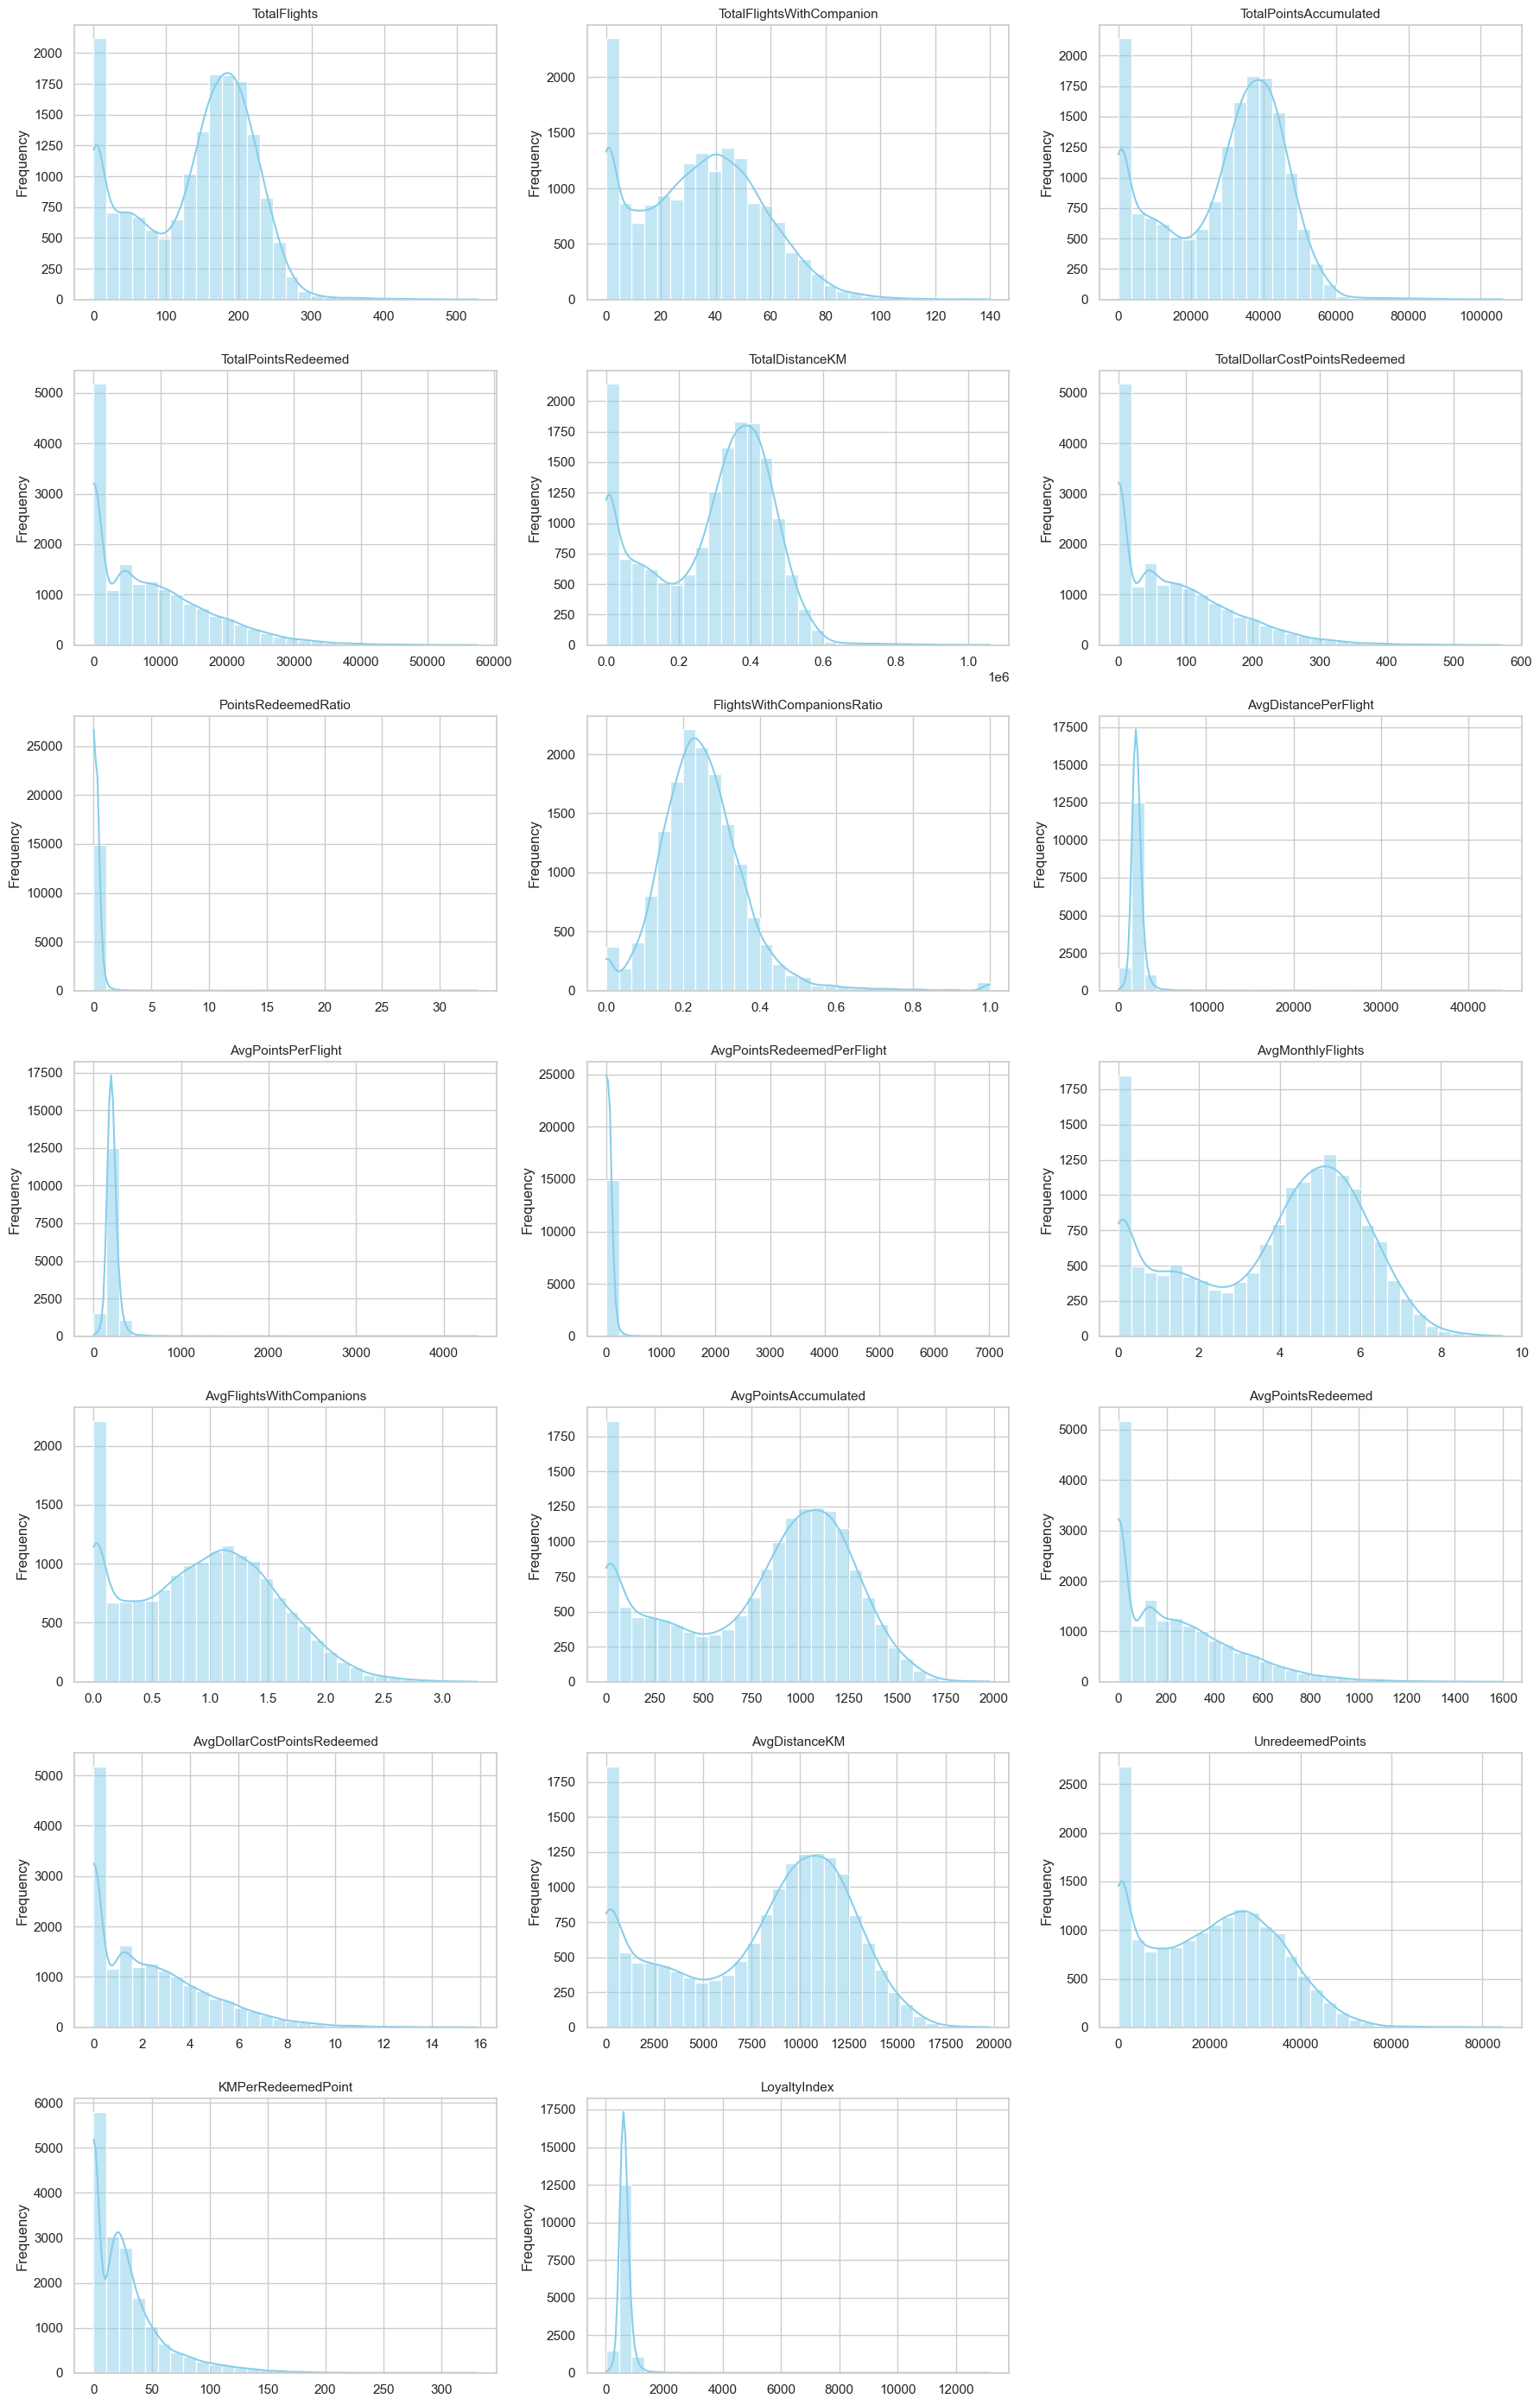

In [119]:

# Select only numeric columns
numerical_cols = FlightsDB_agg.select_dtypes(include='number').columns

# Calculate grid layout dynamically
n_metrics = len(numerical_cols)
n_cols = 3  # you can adjust this
n_rows = math.ceil(n_metrics / n_cols)

plt.figure(figsize=(18, n_rows * 4))
sns.set_style('whitegrid')

# Loop through numeric columns and plot each histogram
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(FlightsDB_agg[col], kde=True, color='skyblue', bins=30)
    plt.title(col, fontsize=11)
    plt.xlabel('')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


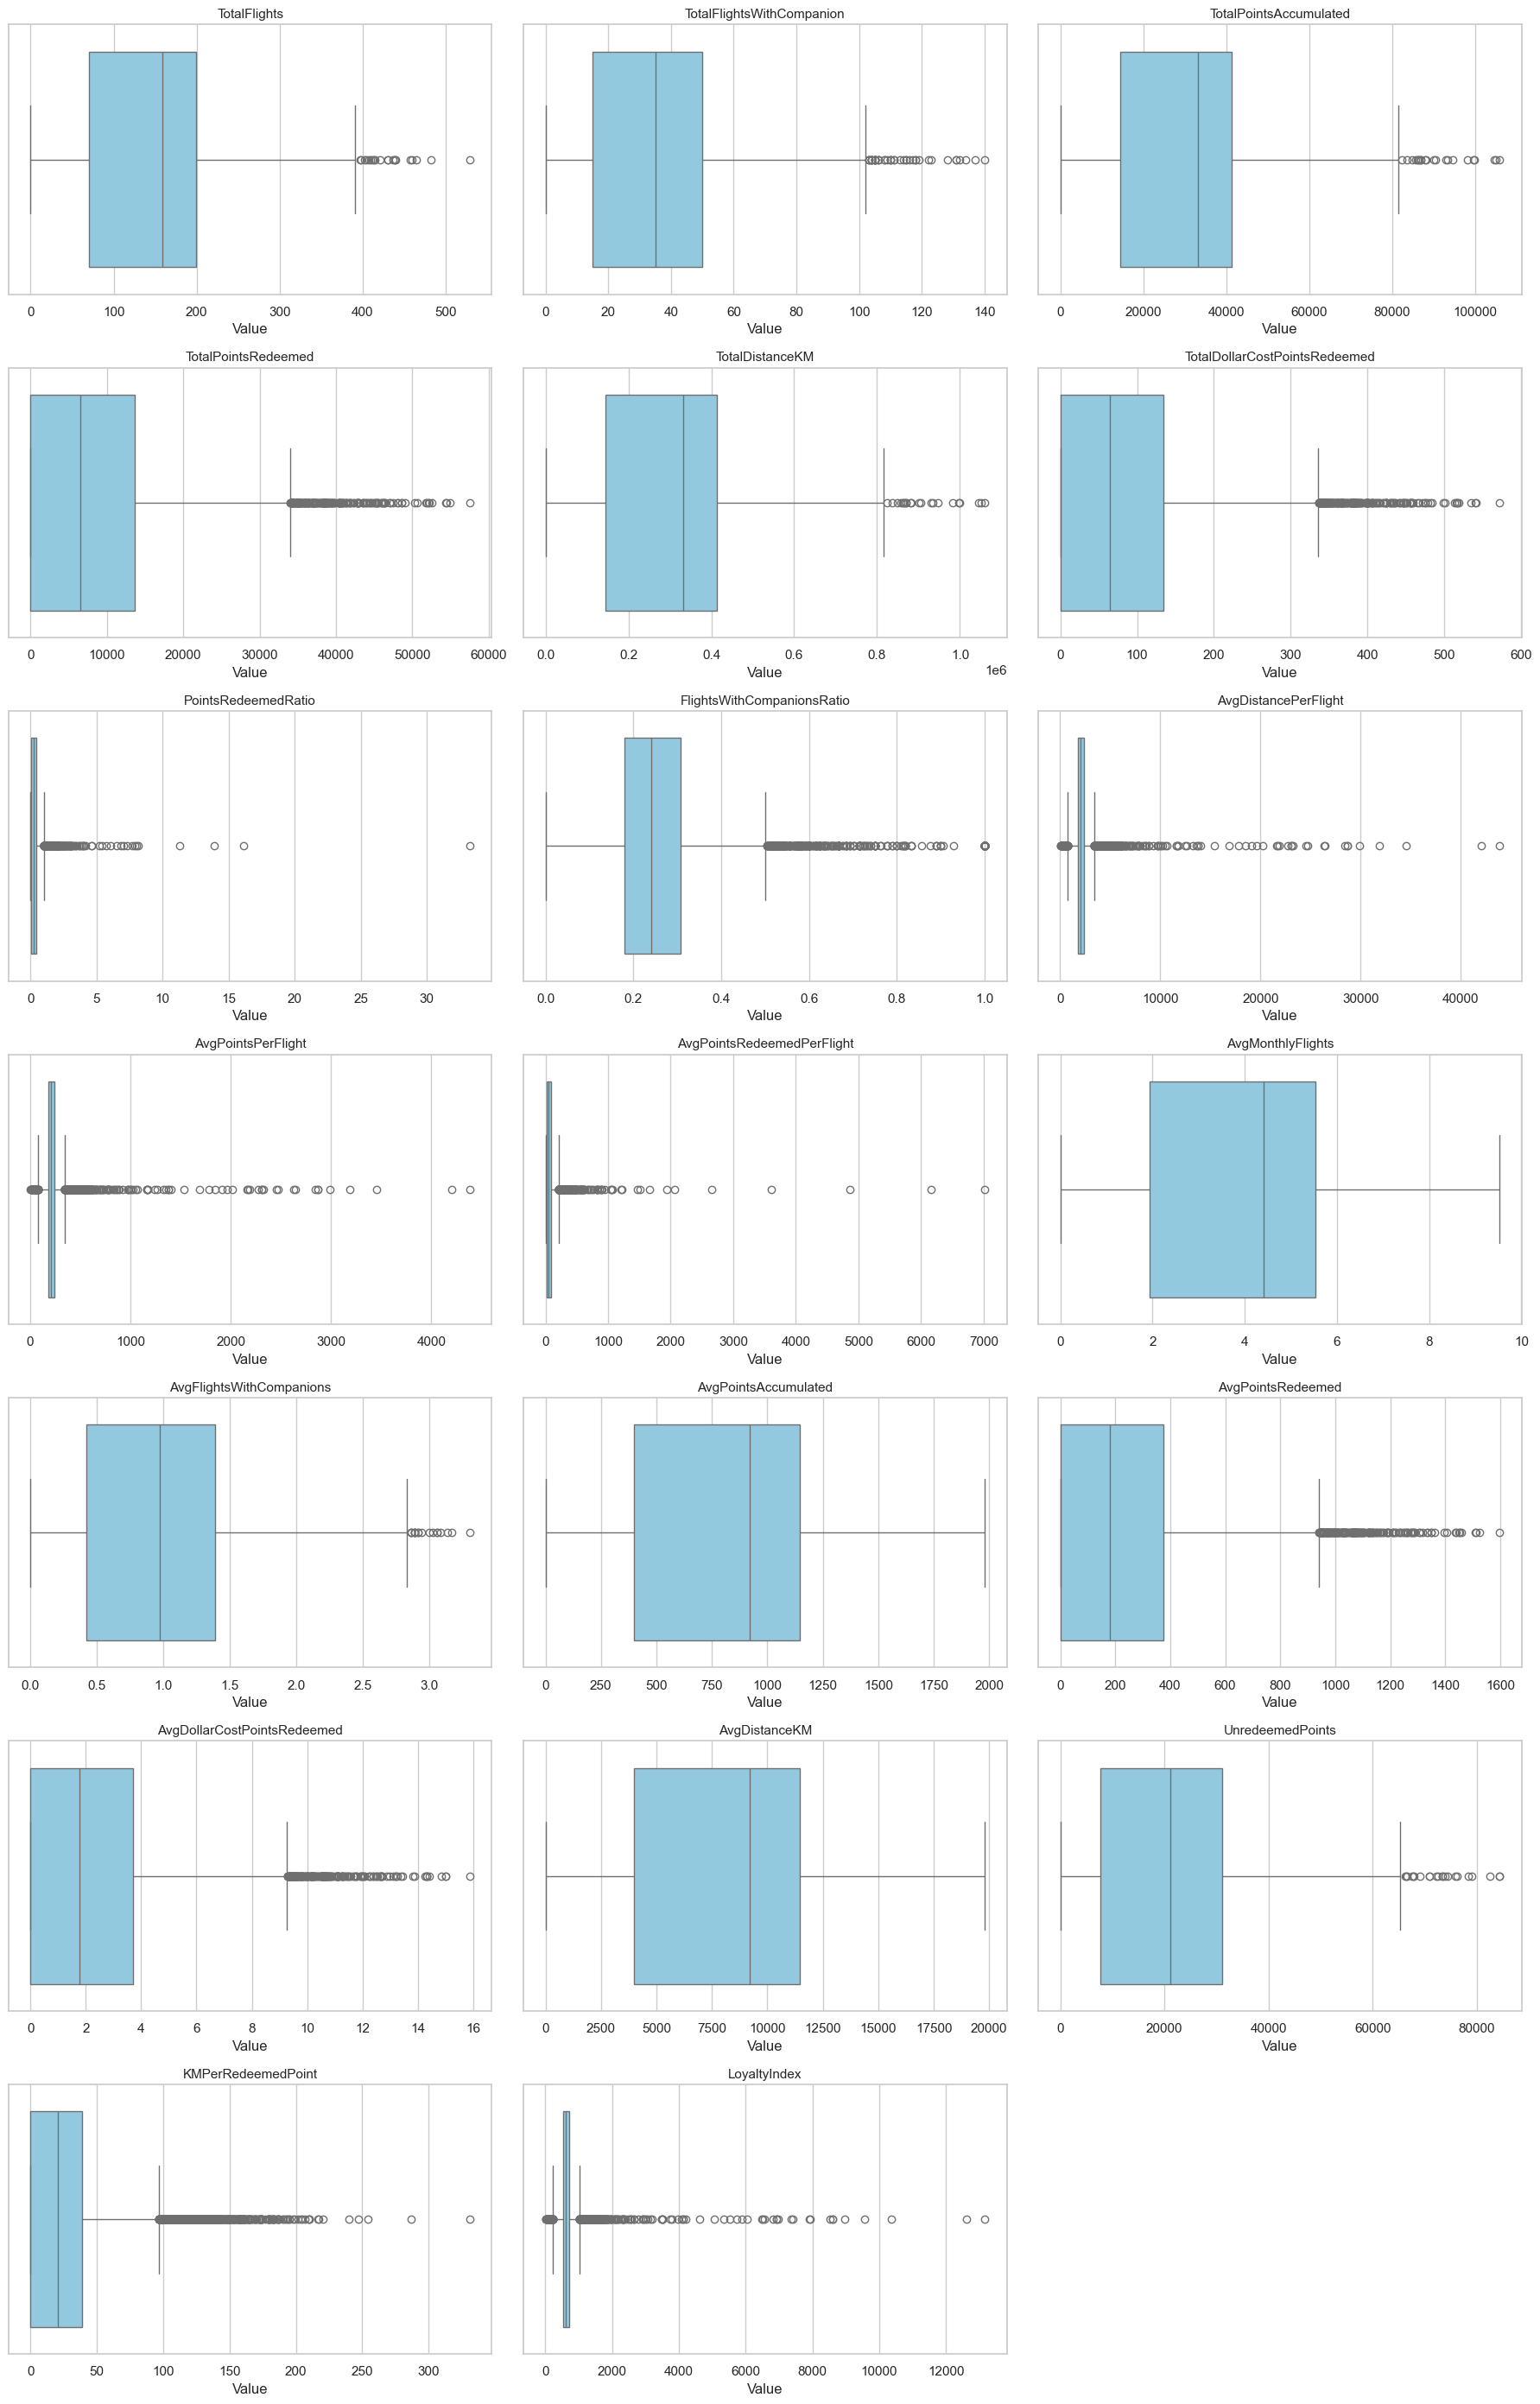

In [120]:
sns.set_style('whitegrid')

numerical_cols = FlightsDB_agg.select_dtypes(include='number').columns
n_metrics = len(numerical_cols)
n_cols = 3
n_rows = math.ceil(n_metrics / n_cols)

plt.figure(figsize=(18, n_rows * 4))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=FlightsDB_agg, x=col, color='skyblue', orient='h')
    plt.title(col, fontsize=11)
    plt.xlabel('Value')
    plt.ylabel('')

plt.tight_layout()
plt.show()


#### Bivariate and Multivariate Analysis

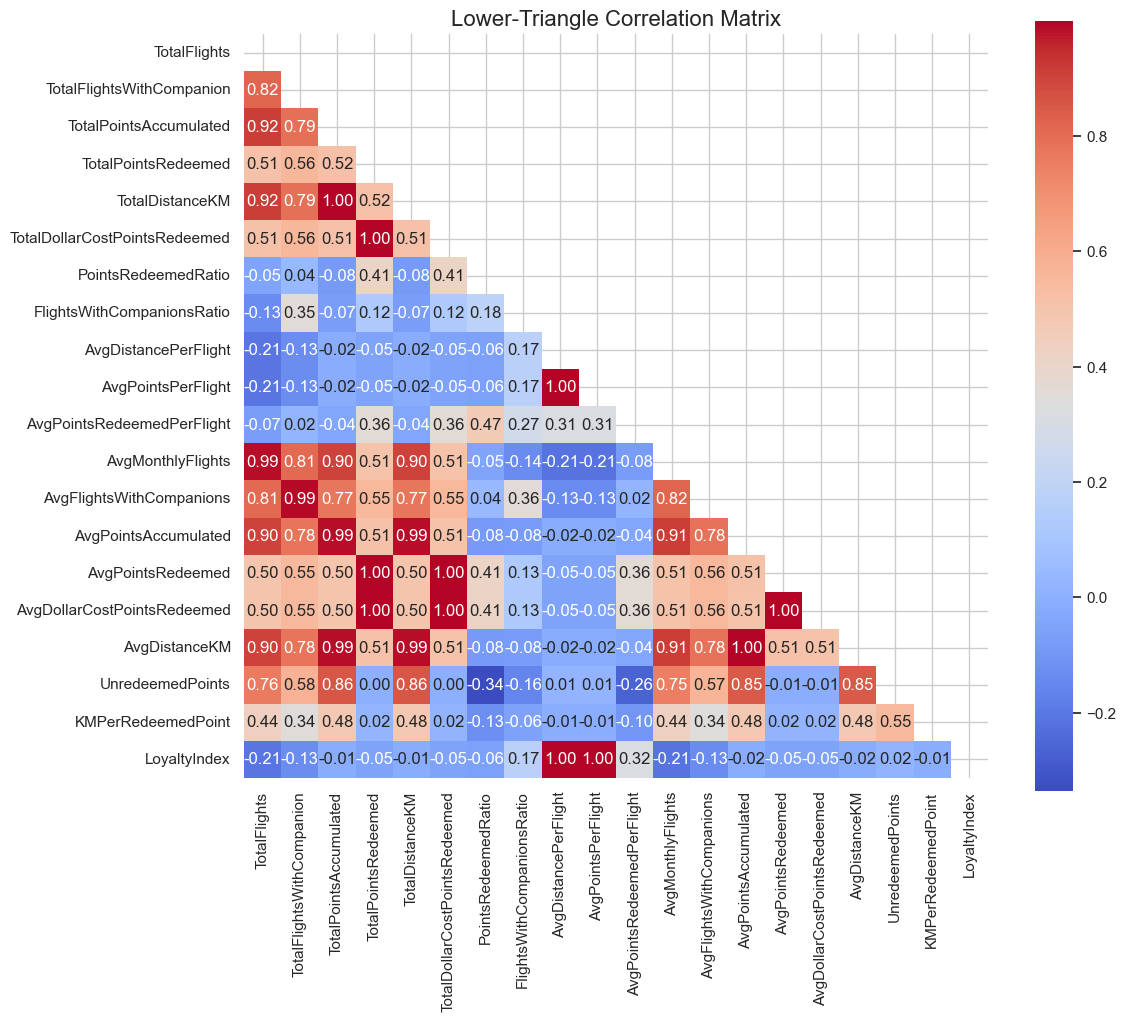

In [121]:
# Select numeric columns
numeric_cols = FlightsDB_agg.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = FlightsDB_agg[numeric_cols].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot the lower-triangle heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title('Lower-Triangle Correlation Matrix', fontsize=16)
plt.show()


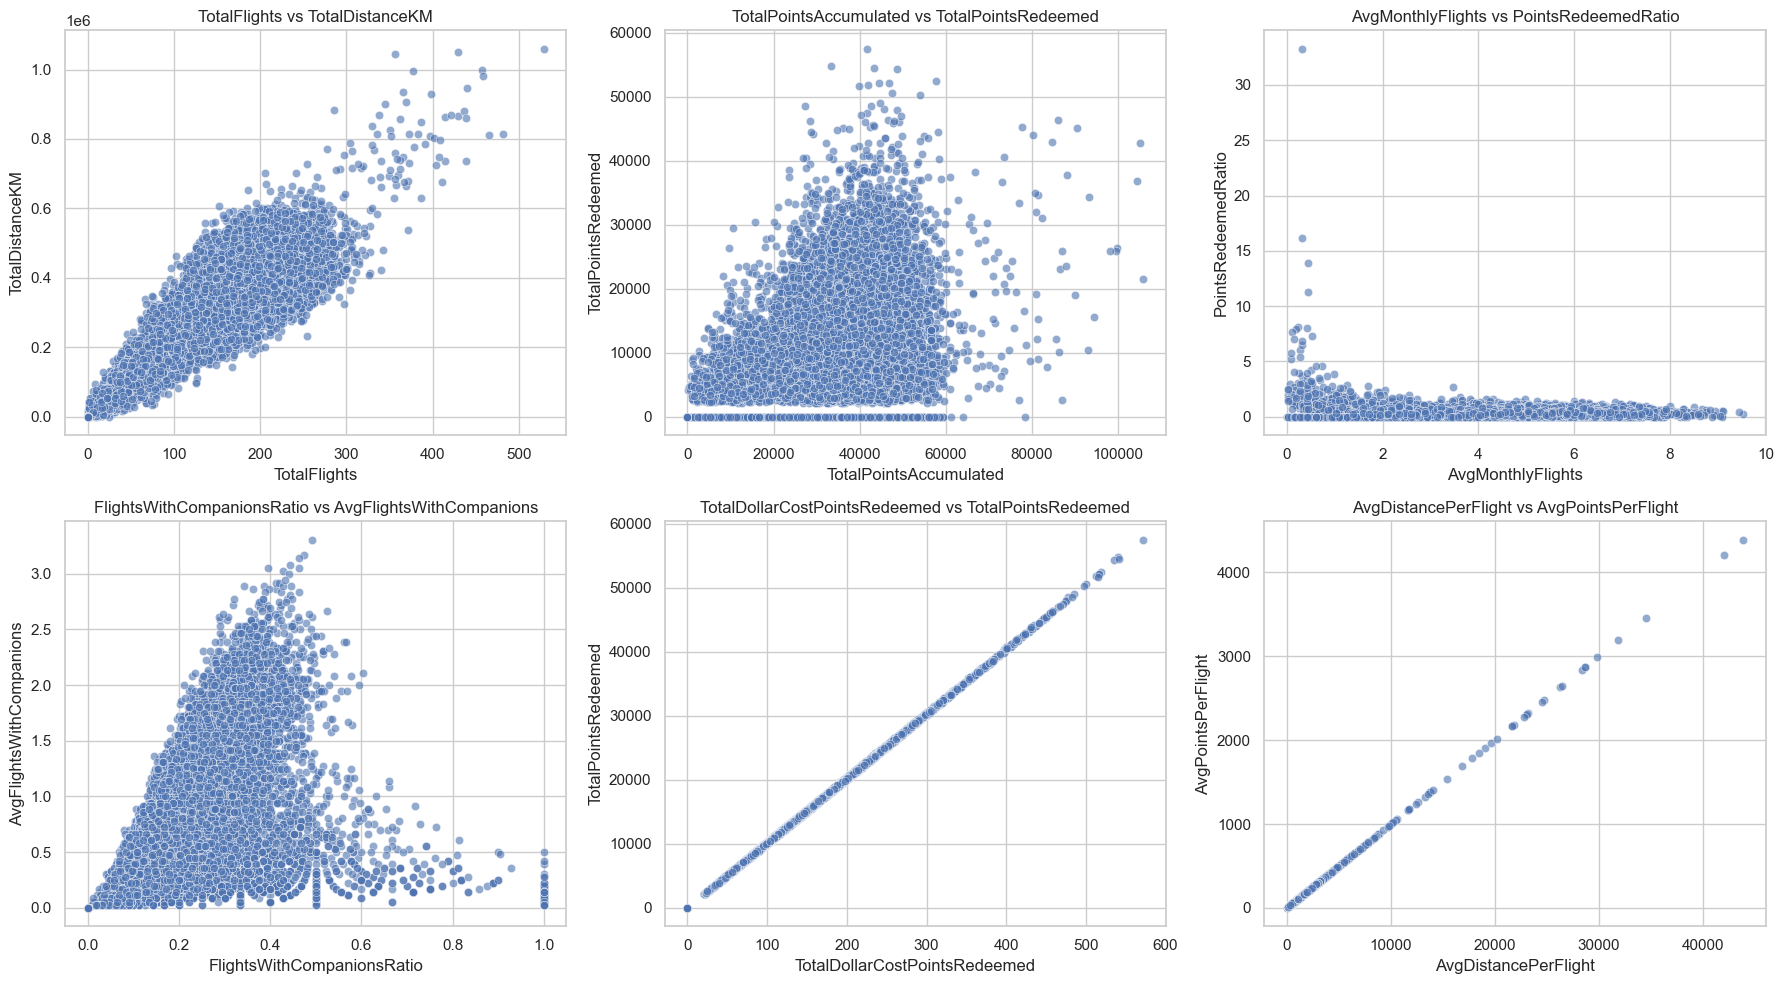

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_pairs = [
    ('TotalFlights', 'TotalDistanceKM'),
    ('TotalPointsAccumulated', 'TotalPointsRedeemed'),
    ('AvgMonthlyFlights', 'PointsRedeemedRatio'),
    ('FlightsWithCompanionsRatio', 'AvgFlightsWithCompanions'),
    ('TotalDollarCostPointsRedeemed', 'TotalPointsRedeemed'),
    ('AvgDistancePerFlight', 'AvgPointsPerFlight')
]

n_pairs = len(numeric_pairs)
n_cols = 3  
n_rows = (n_pairs + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*5))
axes = axes.flatten() 

for i, (x_var, y_var) in enumerate(numeric_pairs):
    sns.scatterplot(
        x=x_var, y=y_var, data=FlightsDB_agg, ax=axes[i], alpha=0.6
    )
    axes[i].set_title(f'{x_var} vs {y_var}')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### High Value Customer

In [123]:
median_total_flights = FlightsDB_agg['TotalFlights'].median()
median_total_points = FlightsDB_agg['TotalPointsAccumulated'].median()
median_avg_flights = FlightsDB_agg['AvgMonthlyFlights'].median()
median_redemption_rate =  FlightsDB_agg['PointsRedeemedRatio'].median()

def customer_segment(row):
    if (row['TotalFlights'] >= median_total_flights and
    row['TotalPointsAccumulated'] >= median_total_points and
    row['AvgMonthlyFlights'] >= median_avg_flights and
    row['PointsRedeemedRatio'] >= median_redemption_rate):
        return 'VIP / Active Redeemer'
    
    elif row['TotalFlights'] >= median_total_flights and row['TotalPointsAccumulated'] >= median_total_points:
        return 'High Volume / Low Redeemer'
    
    elif row['AvgMonthlyFlights'] >= median_avg_flights or row['PointsRedeemedRatio'] >= median_redemption_rate:
        return 'Low Volume / Active Redeemer'
    
    else:
        return 'Low Volume / Low Redeemer'

FlightsDB_agg['CustomerSegment'] = FlightsDB_agg.apply(customer_segment, axis=1)

segment_counts = FlightsDB_agg['CustomerSegment'].value_counts()
print("\nCustomer Segments:")
print(segment_counts)



Customer Segments:
CustomerSegment
Low Volume / Low Redeemer       5215
Low Volume / Active Redeemer    4448
VIP / Active Redeemer           3694
High Volume / Low Redeemer      3380
Name: count, dtype: int64


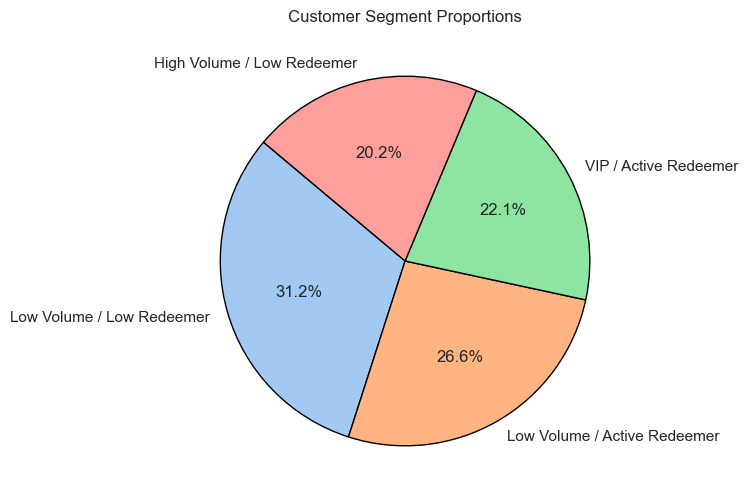

In [124]:
plt.figure(figsize=(6,6))
FlightsDB_agg['CustomerSegment'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=sns.color_palette('pastel'),
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)
plt.ylabel('')
plt.title('Customer Segment Proportions')
plt.show()


**VIP / Active Redeemer** → Offer exclusive rewards, priority services, and tailored promotions to reinforce loyalty and maintain high engagement.

**High Volume / Low Redeemer** → Encourage points redemption through targeted campaigns, limited-time offers, and personalized incentives to increase engagement.

**Low Volume / Active Redeemer** → Strengthen loyalty by promoting flight frequency, offering travel bundles, and providing tailored perks to motivate more bookings.

**Low Volume / Low Redeemer** → Implement low-cost engagement initiatives, such as newsletters or seasonal offers, and monitor activity to identify potential future opportunities.

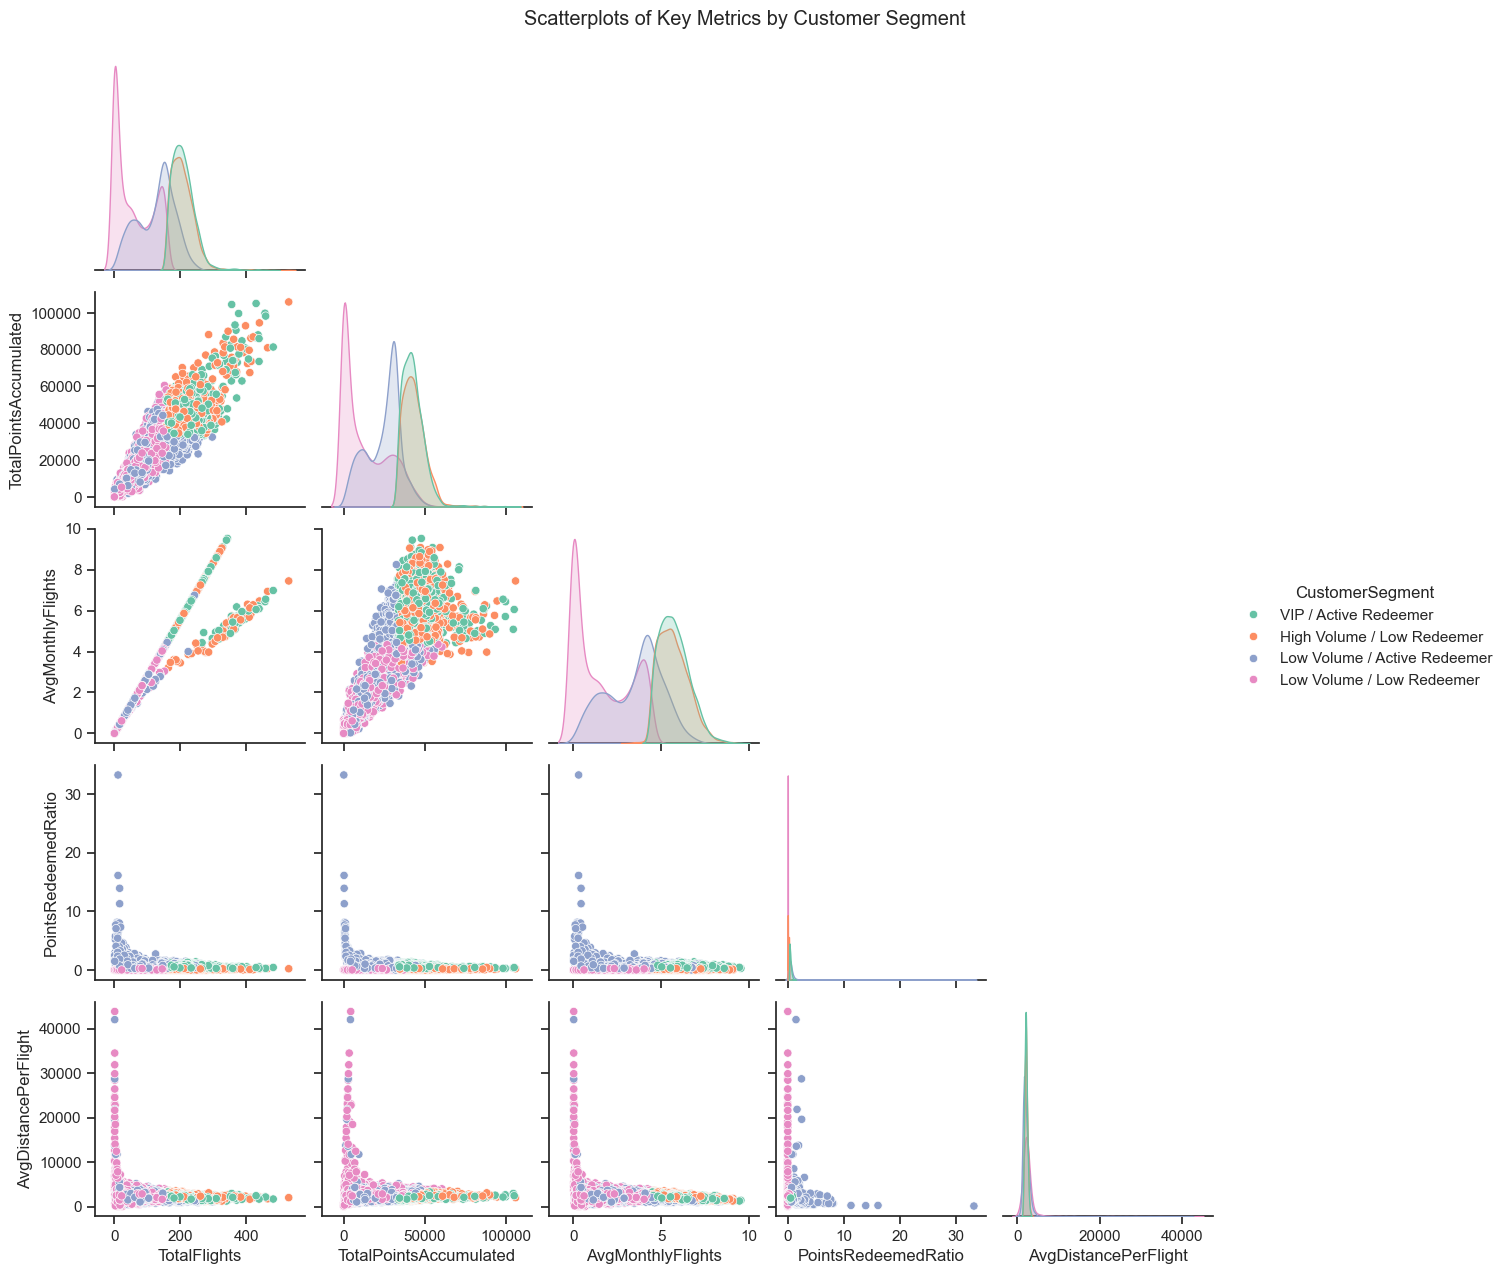

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = ['TotalFlights', 'TotalPointsAccumulated', 'AvgMonthlyFlights', 'PointsRedeemedRatio', 'AvgDistancePerFlight', 'CustomerSegment']

df_plot = FlightsDB_agg[cols]

sns.set(style="ticks", palette="Set2")
pairplot = sns.pairplot(df_plot, hue='CustomerSegment', diag_kind='kde', corner=True)
pairplot.fig.suptitle("Scatterplots of Key Metrics by Customer Segment", y=1.02)
plt.show()


#### Sazonality

##### Per total

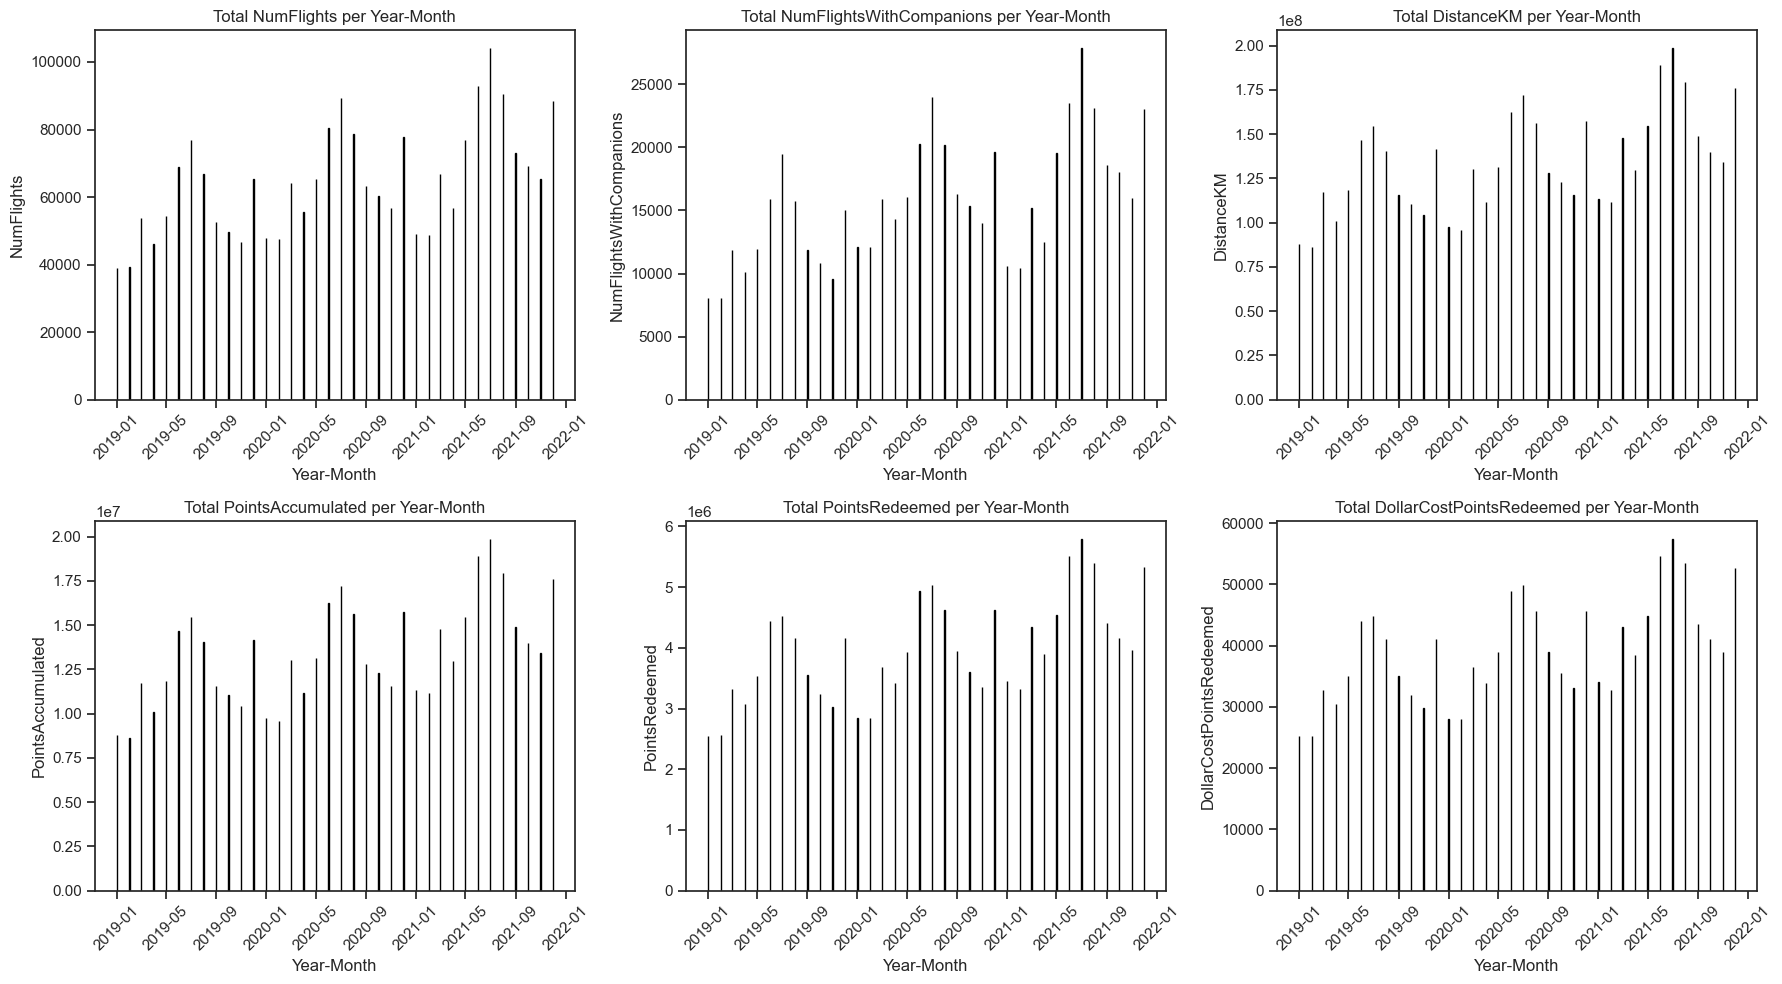

In [126]:
FlightsDB = FlightsDB.copy()

numerical_cols = ['NumFlights', 'NumFlightsWithCompanions', 
                'DistanceKM', 'PointsAccumulated', 
                'PointsRedeemed', 'DollarCostPointsRedeemed']

monthly_sum = FlightsDB.groupby('YearMonthDate')[numerical_cols].sum().reset_index()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,10))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    axes[i].bar(monthly_sum['YearMonthDate'], monthly_sum[col], color='skyblue', edgecolor='black')
    axes[i].set_title(f'Total {col} per Year-Month')
    axes[i].set_xlabel('Year-Month')
    axes[i].set_ylabel(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()




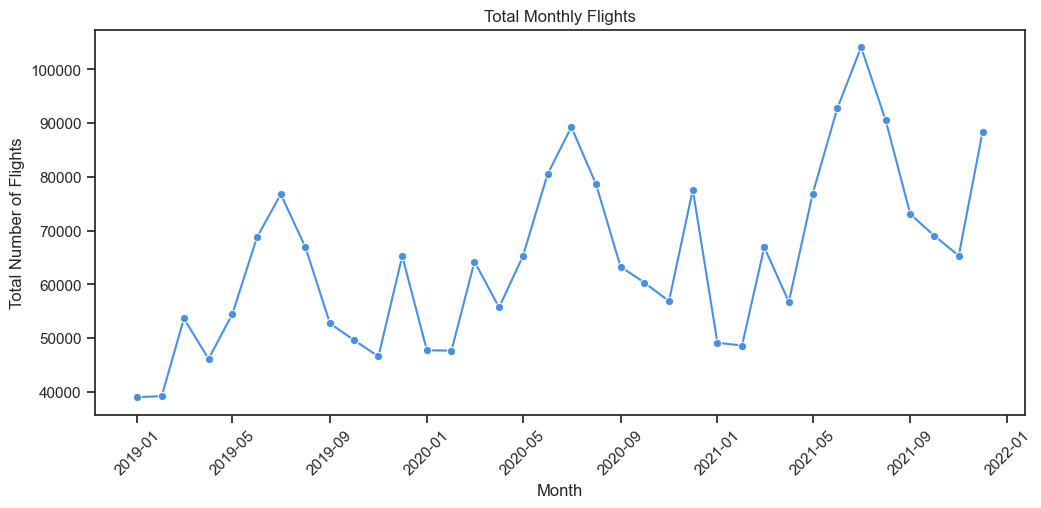

In [127]:
plt.figure(figsize=(12,5))
sns.lineplot(data=monthly_sum, x='YearMonthDate', y='NumFlights', marker='o', color='#4A90E2')
plt.title('Total Monthly Flights')
plt.xlabel('Month')
plt.ylabel('Total Number of Flights')
plt.xticks(rotation=45)
plt.show()


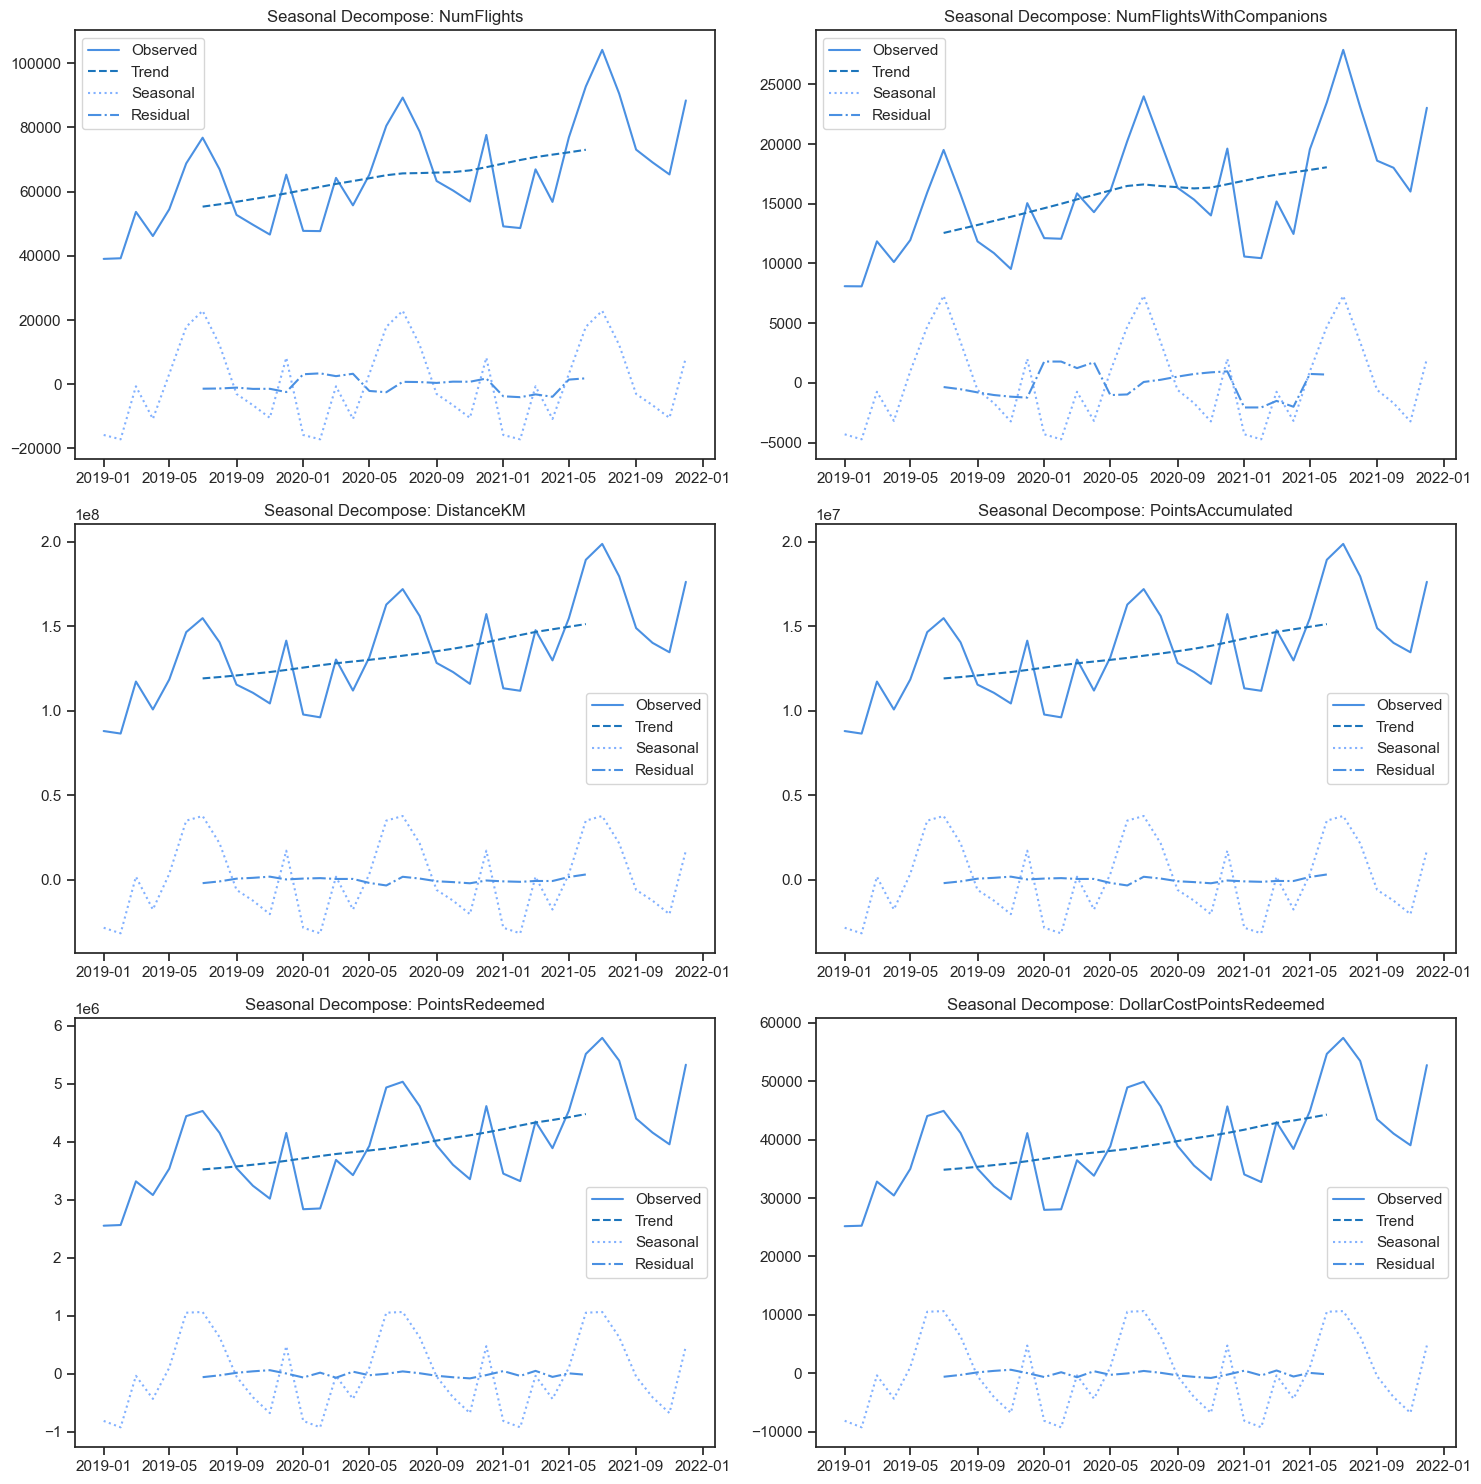

In [128]:
n_cols = 2  
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  

for i, col in enumerate(numerical_cols):
    monthly_total = monthly_sum.set_index('YearMonthDate')[col]
    result = seasonal_decompose(monthly_total, model='additive', period=12)
    
    
    axes[i].plot(result.observed, label='Observed', color='#4A90E2')
    axes[i].plot(result.trend, label='Trend', color='#1C75BC', linestyle='--')
    axes[i].plot(result.seasonal, label='Seasonal', color='#82B1FF', linestyle=':')
    axes[i].plot(result.resid, label='Residual', color='#4A90E2', linestyle='-.')
    
    axes[i].set_title(f'Seasonal Decompose: {col}')
    axes[i].legend()


for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


**Observed**: The original time series data you recorded.

**Trend**: The long-term direction or overall movement in the data.

**Seasonal**: Regular repeating patterns or cycles over time.

**Residual**: The random fluctuations or noise not explained by trend or seasonality.

##### By mean

In [129]:
FlightsDB.columns

Index(['Loyalty#', 'Year', 'Month', 'YearMonthDate', 'NumFlights',
       'NumFlightsWithCompanions', 'DistanceKM', 'PointsAccumulated',
       'PointsRedeemed', 'DollarCostPointsRedeemed', 'month', 'day', 'year'],
      dtype='object')

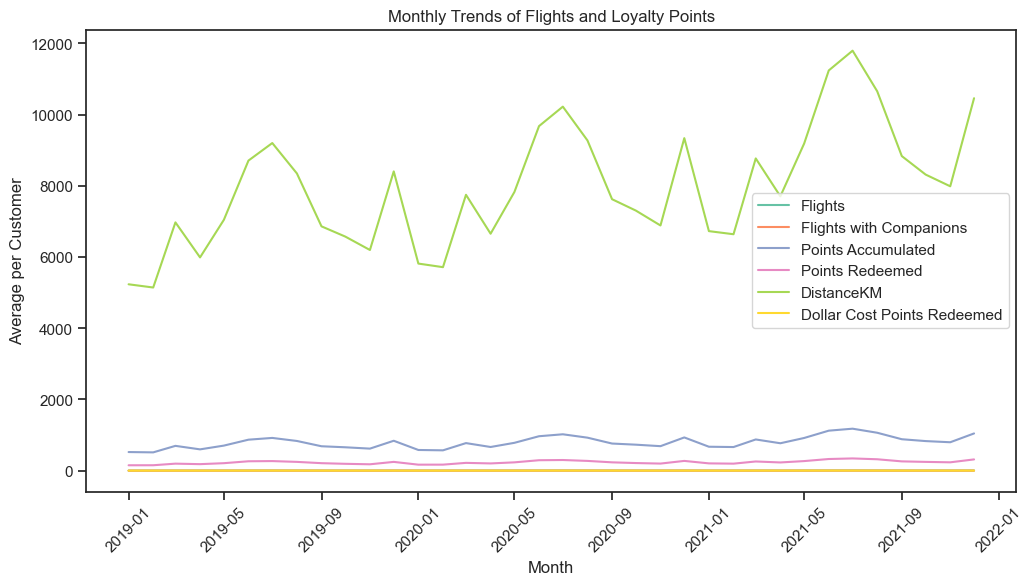

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Aggregate monthly metrics (average per customer)

FlightsDB = FlightsDB.copy()

monthly_agg = FlightsDB.groupby('YearMonthDate').agg({
    'NumFlights': 'mean',                  
    'NumFlightsWithCompanions': 'mean',    
    'PointsAccumulated': 'mean',            
    'PointsRedeemed': 'mean',
    'DistanceKM': 'mean',
    'DollarCostPointsRedeemed': 'mean'    
}).reset_index()

plt.figure(figsize=(12,6))

sns.lineplot(data=monthly_agg, x='YearMonthDate', y='NumFlights', label='Flights')
sns.lineplot(data=monthly_agg, x='YearMonthDate', y='NumFlightsWithCompanions', label='Flights with Companions')
sns.lineplot(data=monthly_agg, x='YearMonthDate', y='PointsAccumulated', label='Points Accumulated')
sns.lineplot(data=monthly_agg, x='YearMonthDate', y='PointsRedeemed', label='Points Redeemed')
sns.lineplot(data=monthly_agg, x='YearMonthDate', y='DistanceKM', label='DistanceKM')
sns.lineplot(data=monthly_agg, x='YearMonthDate', y='DollarCostPointsRedeemed', label='Dollar Cost Points Redeemed')

plt.xlabel('Month')
plt.ylabel('Average per Customer')
plt.title('Monthly Trends of Flights and Loyalty Points')
plt.xticks(rotation=45)
plt.legend()
plt.show()


# Preparing CustomerDB for merge

In [131]:
CustomerDB = CustomerDB.copy()


CustomerDB = CustomerDB.sort_values(['Loyalty#', 'EnrollmentDateOpening'], ascending=[True, True])

CustomerDB_final = CustomerDB.drop_duplicates(subset='Loyalty#', keep='first')


# Preparing FlightsDB for merge

In [132]:
FlightsDB.head()

Loyalty#  Year  Month YearMonthDate  NumFlights  NumFlightsWithCompanions  \
0   413052  2021     12    2021-12-01           2                         2   
1   464105  2021     12    2021-12-01           0                         0   
2   681785  2021     12    2021-12-01          10                         3   
3   185013  2021     12    2021-12-01          16                         4   
4   216596  2021     12    2021-12-01           9                         0   

   DistanceKM  PointsAccumulated  PointsRedeemed  DollarCostPointsRedeemed  \
0      9384.0                938               0                       0.0   
1         0.0                  0               0                       0.0   
2     14745.0               1474               0                       0.0   
3     26311.0               2631            3213                      32.0   
4     19275.0               1927               0                       0.0   

   month  day  year  
0     12    1  2021  
1     12    1  2021  
2     12    1  2021  
3     12    1  2021  
4     12    1  2021

Let's do the mean and the sum per year to have a unique Loyalty#.

In [133]:
FlightsDB= FlightsDB.copy()
id_col = 'Loyalty#'

cols = [
    'NumFlights', 
    'NumFlightsWithCompanions', 
    'DistanceKM', 
    'PointsAccumulated', 
    'PointsRedeemed', 
    'DollarCostPointsRedeemed'
]


FlightsDB_agg = FlightsDB.groupby([id_col, 'Year'])[cols].agg(['sum', 'mean']).reset_index()

FlightsDB_agg.columns = [id_col, 'Year'] + [f'{col}_{agg}' for col, agg in FlightsDB_agg.columns[2:]]

FlightsDB_wide = FlightsDB_agg.pivot(index=id_col, columns='Year')

FlightsDB_wide.columns = [f'{col}_{year}' for col, year in FlightsDB_wide.columns]

FlightsDB_final1 = FlightsDB_wide.reset_index()


In [134]:
FlightsDB = FlightsDB.copy()

monthly_stats = FlightsDB.groupby(['Loyalty#', 'Year']).agg(
    months_active=('NumFlights', lambda x: (x > 0).sum()),   # meses com pelo menos 1 voo
    max_monthly_points=('PointsRedeemed', 'max'),            # máximo de pontos resgatados em um mês
    std_monthly_flights=('NumFlights', 'std')               # variabilidade do número de voos
).reset_index()

monthly_stats_wide = monthly_stats.pivot(index='Loyalty#', columns='Year')

monthly_stats_wide.columns = [f'{col}_{year}' for col, year in monthly_stats_wide.columns]

monthly_stats_wide = monthly_stats_wide.reset_index()

In [135]:
FlightsDB_final = pd.merge(
    FlightsDB_final1, 
    monthly_stats_wide, 
    on='Loyalty#',        
    how='outer'           
)

In [136]:
FlightsDB_final.head()

Loyalty#  NumFlights_sum_2019  NumFlights_sum_2020  NumFlights_sum_2021  \
0   100018                   68                   81                   76   
1   100102                   72                   83                   90   
2   100140                   59                   72                   80   
3   100214                   29                   37                   42   
4   100272                   54                   66                   61   

   NumFlights_mean_2019  NumFlights_mean_2020  NumFlights_mean_2021  \
0              5.666667              6.750000              6.333333   
1              6.000000              6.916667              7.500000   
2              4.916667              6.000000              6.666667   
3              2.416667              3.083333              3.500000   
4              4.500000              5.500000              5.083333   

   NumFlightsWithCompanions_sum_2019  NumFlightsWithCompanions_sum_2020  \
0                                 10                                 16   
1                                 13                                 18   
2                                 13                                 18   
3                                  0                                  3   
4                                 14                                 19   

   NumFlightsWithCompanions_sum_2021  ...  DollarCostPointsRedeemed_mean_2021  \
0                                 19  ...                            2.416667   
1                                 24  ...                            0.000000   
2                                 20  ...                            4.000000   
3                                 14  ...                            0.000000   
4                                 17  ...                            4.166667   

   months_active_2019  months_active_2020  months_active_2021  \
0                  11                  11                   9   
1                   8                   8                   9   
2                   9                  10                   8   
3                   5                   7                   7   
4                   6                   8                   9   

   max_monthly_points_2019  max_monthly_points_2020  max_monthly_points_2021  \
0                     5205                     5784                     2984   
1                     5166                     5741                        0   
2                        0                        0                     4896   
3                     3294                     3661                        0   
4                     2750                     3056                     5085   

   std_monthly_flights_2019  std_monthly_flights_2020  \
0                  4.030189                  4.433857   
1                  4.935953                  5.680242   
2                  4.420167                  5.027199   
3                  3.604501                  4.100074   
4                  5.664884                  6.431457   

   std_monthly_flights_2021  
0                  5.662209  
1                  5.231026  
2                  5.710172  
3                  4.582576  
4                  5.282188  

[5 rows x 46 columns]

In [137]:
has_duplicates = FlightsDB_final['Loyalty#'].duplicated().any()
if has_duplicates:
    print("There are duplicated Loyalty# in the final dataset.")

In [138]:
num_cols = FlightsDB_final.columns.tolist()

all_zero_rows = FlightsDB_final[(FlightsDB_final[num_cols] == 0).all(axis=1)]

print(all_zero_rows)
print("Rows number:", all_zero_rows.shape[0])


Empty DataFrame
Columns: [Loyalty#, NumFlights_sum_2019, NumFlights_sum_2020, NumFlights_sum_2021, NumFlights_mean_2019, NumFlights_mean_2020, NumFlights_mean_2021, NumFlightsWithCompanions_sum_2019, NumFlightsWithCompanions_sum_2020, NumFlightsWithCompanions_sum_2021, NumFlightsWithCompanions_mean_2019, NumFlightsWithCompanions_mean_2020, NumFlightsWithCompanions_mean_2021, DistanceKM_sum_2019, DistanceKM_sum_2020, DistanceKM_sum_2021, DistanceKM_mean_2019, DistanceKM_mean_2020, DistanceKM_mean_2021, PointsAccumulated_sum_2019, PointsAccumulated_sum_2020, PointsAccumulated_sum_2021, PointsAccumulated_mean_2019, PointsAccumulated_mean_2020, PointsAccumulated_mean_2021, PointsRedeemed_sum_2019, PointsRedeemed_sum_2020, PointsRedeemed_sum_2021, PointsRedeemed_mean_2019, PointsRedeemed_mean_2020, PointsRedeemed_mean_2021, DollarCostPointsRedeemed_sum_2019, DollarCostPointsRedeemed_sum_2020, DollarCostPointsRedeemed_sum_2021, DollarCostPointsRedeemed_mean_2019, DollarCostPointsRedeemed_mea

# FINAL DATASET

what I did is wrong.
what merges we can do:
- inner
- left
- right

In [139]:
finalDB = FlightsDB_final.merge(CustomerDB_final, on='Loyalty#', how='left')

In [140]:
finalDB.shape

(16737, 70)

In [141]:
finalDB.head(10)

Loyalty#  NumFlights_sum_2019  NumFlights_sum_2020  NumFlights_sum_2021  \
0   100018                   68                   81                   76   
1   100102                   72                   83                   90   
2   100140                   59                   72                   80   
3   100214                   29                   37                   42   
4   100272                   54                   66                   61   
5   100301                   91                  104                   41   
6   100364                   60                   71                   40   
7   100380                   48                   59                   57   
8   100428                   35                   43                   78   
9   100504                   38                   44                   23   

   NumFlights_mean_2019  NumFlights_mean_2020  NumFlights_mean_2021  \
0              5.666667              6.750000              6.333333   
1              6.000000              6.916667              7.500000   
2              4.916667              6.000000              6.666667   
3              2.416667              3.083333              3.500000   
4              4.500000              5.500000              5.083333   
5              7.583333              8.666667              3.416667   
6              5.000000              5.916667              3.333333   
7              4.000000              4.916667              4.750000   
8              2.916667              3.583333              6.500000   
9              3.166667              3.666667              1.916667   

   NumFlightsWithCompanions_sum_2019  NumFlightsWithCompanions_sum_2020  \
0                                 10                                 16   
1                                 13                                 18   
2                                 13                                 18   
3                                  0                                  3   
4                                 14                                 19   
5                                 22                                 26   
6                                 15                                 18   
7                                 17                                 23   
8                                  6                                  8   
9                                  3                                  4   

   NumFlightsWithCompanions_sum_2021  ...  LoyaltyStatus  \
0                                 19  ...         Aurora   
1                                 24  ...           Nova   
2                                 20  ...           Nova   
3                                 14  ...           Star   
4                                 17  ...           Star   
5                                 20  ...           Nova   
6                                 10  ...           Nova   
7                                 20  ...           Star   
8                                 14  ...         Aurora   
9                                  2  ...           Nova   

   EnrollmentDateOpening  CancellationDate  Customer Lifetime Value  \
0             2019-08-09               NaT                  7919.20   
1             2016-03-09               NaT                  2887.74   
2             2019-07-30               NaT                  2838.07   
3             2018-08-06               NaT                  4170.57   
4             2017-01-09               NaT                  6622.05   
5             2016-09-17               NaT                 48356.96   
6             2018-05-05               NaT                  5143.88   
7             2015-10-29               NaT                  2465.62   
8             2015-08-11               NaT                  5845.43   
9             2020-07-17        2021-03-17                  8807.61   

   EnrollmentType  ValidPostalCode            FullName  distance_to_ref_km  \
0        Standard        

In [142]:
new_features_list = []

## Redemption Rate

In [143]:
DB_clean['Redemption Rate'] = DB_clean['PointsRedeemed'] / DB_clean['PointsAccumulated']

DB_clean['Redemption Rate'].replace([np.inf, -np.inf], np.nan, inplace=True)

new_features_list.append('Redemption Rate')

NameError: name 'DB_clean' is not defined

## Renroll

In [ ]:
DB_clean['Renroll'] = np.where(DB_clean['CancellationDate'] < DB_clean['EnrollmentDateOpening'], 1, 0)
new_features_list.append('Renroll')

## Has canceled

In [ ]:
def compute_final_canceled(group):
    # Sort by EnrollmentDateOpening
    group = group.sort_values('EnrollmentDateOpening')
    
    # Check if there is any active period after a cancellation
    # Iterate over the records from first to last
    canceled = 1  # assume canceled initially
    for i, row in group.iterrows():
        if pd.isna(row['CancellationDate']):
            canceled = 0  # still active
            break
        # check if there is a subsequent period with EnrollmentDate > CancellationDate
        later_periods = group[group['EnrollmentDateOpening'] > row['CancellationDate']]
        if not later_periods.empty:
            canceled = 0
            break
    return pd.Series({'Has Canceled': canceled})



In [ ]:
new_features_list.append('Has Canceled')
new_features_list

## Active Days

In [ ]:
import pandas as pd
import numpy as np

today = pd.Timestamp('today')

# Make sure Renroll exists per customer
# 1 = customer re-enrolled at least once, 0 = no re-enrollment
# Example: DB['Renroll'] already calculated per customer

# Merge Renroll flag to DB if needed
# DB = DB.merge(DB_reenroll, on='Loyalty#', how='left')

# Function to compute ActiveDays considering re-enrollment
def compute_active_days(row):
    if row['Renroll'] == 1:
        # Sum days before cancellation + days after re-enrollment
        days_before_cancel = 0
        if pd.notna(row['CancellationDate']):
            days_before_cancel = (row['CancellationDate'] - row['EnrollmentDateOpening']).days
        days_after_enroll = (today - row['EnrollmentDateOpening']).days
        return max(days_before_cancel, 0) + max(days_after_enroll, 0)
    else:
        # Normal calculation
        if pd.notna(row['CancellationDate']):
            return max((row['CancellationDate'] - row['EnrollmentDateOpening']).days, 0)
        else:
            return max((today - row['EnrollmentDateOpening']).days, 0)

# Convert to years if needed
DB_clean['ActiveYears'] = DB_clean['ActiveDays'] / 365

# Add to feature list if not already
if 'ActiveDays' not in new_features_list:
    new_features_list.append('ActiveDays')

## Net Points

In [ ]:
DB_clean['Net Points'] = DB_clean['PointsAccumulated']-DB_clean['PointsRedeemed']
new_features_list.append('Net Points')

Before going to preprocessing, let's drop some columns we will not need

In [ ]:
#drop columns that are not necessary